# Libraries

In [1]:
# imports
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
from collections import Counter

import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Import models from another notebook
%run model.ipynb
%run util.ipynb

# Preprocessing

In [3]:
# load inputs
sudokus = pd.read_csv('./datasets/sudoku-kaggle.csv').values
print("Full shape:", sudokus.shape)

Full shape: (1000000, 2)


In [4]:
# Examine first 5 rows
sudokus[:5]

array([['004300209005009001070060043006002087190007400050083000600000105003508690042910300',
        '864371259325849761971265843436192587198657432257483916689734125713528694542916378'],
       ['040100050107003960520008000000000017000906800803050620090060543600080700250097100',
        '346179258187523964529648371965832417472916835813754629798261543631485792254397186'],
       ['600120384008459072000006005000264030070080006940003000310000050089700000502000190',
        '695127384138459672724836915851264739273981546946573821317692458489715263562348197'],
       ['497200000100400005000016098620300040300900000001072600002005870000600004530097061',
        '497258316186439725253716498629381547375964182841572639962145873718623954534897261'],
       ['005910308009403060027500100030000201000820007006007004000080000640150700890000420',
        '465912378189473562327568149738645291954821637216397854573284916642159783891736425']],
      dtype=object)

In [5]:
# Preprocess
X_kaggle, y_kaggle = sudokus[:, 0], sudokus[:, 1]
X_kaggle, y_kaggle = preprocess(X_kaggle, y_kaggle, 
                                from_string=True, 
                                reshape=True, 
                                one_hot=False)

Initial shape of X: (1000000,)
Initial shape of y: (1000000,)
Convert strings in X to: (1000000, 81)
Convert strings in y to: (1000000, 81)
Reshape X to: (1000000, 9, 9)
Reshape y to: (1000000, 9, 9)


In [6]:
# After reshape
X_kaggle[0]

array([[0, 0, 4, 3, 0, 0, 2, 0, 9],
       [0, 0, 5, 0, 0, 9, 0, 0, 1],
       [0, 7, 0, 0, 6, 0, 0, 4, 3],
       [0, 0, 6, 0, 0, 2, 0, 8, 7],
       [1, 9, 0, 0, 0, 7, 4, 0, 0],
       [0, 5, 0, 0, 8, 3, 0, 0, 0],
       [6, 0, 0, 0, 0, 0, 1, 0, 5],
       [0, 0, 3, 5, 0, 8, 6, 9, 0],
       [0, 4, 2, 9, 1, 0, 3, 0, 0]])

Maximum #clues: 37
Minimum #clues: 29
Average #clues: 33.81279


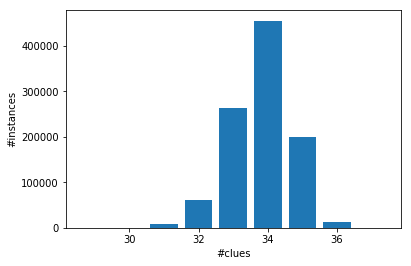

In [7]:
# Count clues
clues = np.sum(X_kaggle != 0, axis=(1, 2))
print("Maximum #clues:", np.max(clues))
print("Minimum #clues:", np.min(clues))
print("Average #clues:", np.mean(clues))

# plot bar
counter = Counter(clues)
plt.bar(counter.keys(), counter.values())
plt.xlabel('#clues')
plt.ylabel('#instances')
plt.show()

In [7]:
# One-hot encoding
X_kaggle, y_kaggle = preprocess(X_kaggle, y_kaggle, 
                                from_string=False, 
                                reshape=False, 
                                one_hot=True)

Initial shape of X: (1000000, 9, 9)
Initial shape of y: (1000000, 9, 9)
Shape of one-hot X: (1000000, 9, 9, 10)
Shape of one-hot y: (1000000, 9, 9, 9)


In [8]:
# Get 50000 for training and testing only
X_kaggle_used, X_kaggle_hold, y_kaggle_used, y_kaggle_hold = train_test_split(X_kaggle, y_kaggle, 
                                                                              test_size=0.95,
                                                                              random_state=42)
print("Used X shape:", X_kaggle_used.shape)
print("Used y shape:", y_kaggle_used.shape)
print("Hold X shape:", X_kaggle_hold.shape)
print("Hold X shape:", y_kaggle_hold.shape)

Used X shape: (50000, 9, 9, 10)
Used y shape: (50000, 9, 9, 9)
Hold X shape: (950000, 9, 9, 10)
Hold X shape: (950000, 9, 9, 9)


In [13]:
#   DEGREE OF DIFFICULTY   |  SCORE                                                
# -------------------------+------------------------------------------             
#   TRIVIAL                |  80 points or less                                    
#   EASY                   |  81 - 150 points                                      
#   MEDIUM                 |  151 - 250 points                                     
#   HARD                   |  251 - 400 points                                     
#   VERY HARD              |  401 - 900 points                                     
#   DIABOLICAL             |  901 and up          
X_kaggle_reshape = from_one_hot(X_kaggle_used)

start = time.time()
evals = calculate_difficulty(X_kaggle_reshape)
print("Runtime: {} seconds".format(time.time() - start))

Runtime: 1690.8879973888397 seconds


In [6]:
# Number of solutions
counts = list(map(lambda x: int(x['counts'][0]), evals))
print("Maximum #solutions:", np.max(counts))
print("Minimum #solutions:", np.min(counts))
print("Average #solutions:", np.mean(counts))

Maximum #solutions: 1
Minimum #solutions: 1
Average #solutions: 1.0


Maximum score: 119
Minimum score: 44
Average score: 47.19684
Std score: 1.0226895982652802


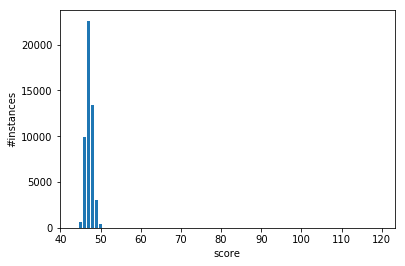

In [7]:
# scores
scores = list(map(lambda x: int(x['scores'][0]), evals))
print("Maximum score:", np.max(scores))
print("Minimum score:", np.min(scores))
print("Average score:", np.mean(scores))
print("Std score:", np.std(scores))

# plot bar
counter = Counter(scores)
plt.bar(counter.keys(), counter.values())
plt.xlabel('score')
plt.ylabel('#instances')
plt.show()

In [10]:
# train, test, validation split
X_kaggle_train, X_kaggle_test, y_kaggle_train, y_kaggle_test = train_test_split(X_kaggle_used,
                                                                                y_kaggle_used,
                                                                                test_size=0.2, 
                                                                                random_state=42)
X_kaggle_train, X_kaggle_val, y_kaggle_train, y_kaggle_val = train_test_split(X_kaggle_train, 
                                                                              y_kaggle_train, 
                                                                              test_size=0.2, 
                                                                              random_state=42)
print("Training data shape:", X_kaggle_train.shape)
print("Training labels shape:", y_kaggle_train.shape)
print("Validation data shape:", X_kaggle_val.shape)
print("Validation labels shape:", y_kaggle_val.shape)
print("Testing data shape:", X_kaggle_test.shape)
print("Testing labels shape:", y_kaggle_test.shape)

Training data shape: (32000, 9, 9, 10)
Training labels shape: (32000, 9, 9, 9)
Validation data shape: (8000, 9, 9, 10)
Validation labels shape: (8000, 9, 9, 9)
Testing data shape: (10000, 9, 9, 10)
Testing labels shape: (10000, 9, 9, 9)


In [11]:
# Completed puzzles create from solutions
X_kaggle_train_completed = to_puzzles(y_kaggle_train)
print("Completed training data shape:", X_kaggle_train_completed.shape)

Completed training data shape: (32000, 9, 9, 10)


# Training

### Dense model

In [12]:
dense = get_model(input_shape=X_kaggle_train.shape[1:], model_id='dense_model')
dense.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_4 (Dense)      

In [13]:
# hidden architecture
dense.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9, 9, 64)          704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
_________________________________________________________________


In [12]:
# mini-batches with #epochs and #blanks
n_epochs = [1, 1, 2, 3, 5, 7, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
n_blanks = [0, 1, 2, 3, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
batch_size = [256] * len(n_epochs)

In [15]:
# train models
start = time.time()
dense_losses = train_model(dense, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val, y_kaggle_val,
                           True, False, n_blanks, n_epochs, batch_size, return_loss=True, 
                           save_prefix='./models/dense_model')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 61s 2ms/step - loss: 87.8843 - dense_3_loss: 1.0806 - dense_4_loss: 1.0831 - dense_5_loss: 1.0695 - dense_6_loss: 1.0796 - dense_7_loss: 1.0833 - dense_8_loss: 1.0859 - dense_9_loss: 1.0752 - dense_10_loss: 1.0735 - dense_11_loss: 1.0886 - dense_12_loss: 1.0749 - dense_13_loss: 1.0851 - dense_14_loss: 1.0896 - dense_15_loss: 1.0997 - dense_16_loss: 1.0864 - dense_17_loss: 1.0910 - dense_18_loss: 1.0942 - dense_19_loss: 1.0824 - dense_20_loss: 1.0891 - dense_21_loss: 1.0870 - dense_22_loss: 1.0809 - dense_23_loss: 1.0835 - dense_24_loss: 1.0702 - dense_25_loss: 1.0803 - dense_26_loss: 1.0853 - dense_27_loss: 1.0890 - dense_28_loss: 1.0834 - dense_29_loss: 1.0843 - dense_30_loss: 1.0823 - dense_31_loss: 1.0847 - dense_32_loss: 1.0796 - dense_33_loss: 1.0952 - dense_34_loss: 1.0883 - dense_35_loss: 1.0693 - dense_36_loss: 1.

8000/8000 [==============================] - 1s 145us/step
Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 50s 2ms/step - loss: 3.8029 - dense_3_loss: 0.0469 - dense_4_loss: 0.0476 - dense_5_loss: 0.0449 - dense_6_loss: 0.0459 - dense_7_loss: 0.0470 - dense_8_loss: 0.0469 - dense_9_loss: 0.0446 - dense_10_loss: 0.0450 - dense_11_loss: 0.0485 - dense_12_loss: 0.0450 - dense_13_loss: 0.0481 - dense_14_loss: 0.0480 - dense_15_loss: 0.0483 - dense_16_loss: 0.0493 - dense_17_loss: 0.0485 - dense_18_loss: 0.0485 - dense_19_loss: 0.0476 - dense_20_loss: 0.0502 - dense_21_loss: 0.0461 - dense_22_loss: 0.0475 - dense_23_loss: 0.0471 - dense_24_loss: 0.0455 - dense_25_loss: 0.0479 - dense_26_loss: 0.0478 - dense_27_loss: 0.0481 - dense_28_loss: 0.0451 - dense_29_loss: 0.0467 - dense_30_loss: 0.0467 - dense_31_loss: 0.0459 - dense_32_loss: 0.0454 - dense_33_loss: 0.0480 - dense_34_loss: 0.0477 - dense_35_loss: 0.0443 - dense_3

8000/8000 [==============================] - 1s 154us/step
Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 52s 2ms/step - loss: 2.0642 - dense_3_loss: 0.0246 - dense_4_loss: 0.0264 - dense_5_loss: 0.0245 - dense_6_loss: 0.0250 - dense_7_loss: 0.0250 - dense_8_loss: 0.0245 - dense_9_loss: 0.0248 - dense_10_loss: 0.0255 - dense_11_loss: 0.0244 - dense_12_loss: 0.0269 - dense_13_loss: 0.0257 - dense_14_loss: 0.0254 - dense_15_loss: 0.0277 - dense_16_loss: 0.0258 - dense_17_loss: 0.0263 - dense_18_loss: 0.0255 - dense_19_loss: 0.0261 - dense_20_loss: 0.0251 - dense_21_loss: 0.0256 - dense_22_loss: 0.0239 - dense_23_loss: 0.0245 - dense_24_loss: 0.0240 - dense_25_loss: 0.0272 - dense_26_loss: 0.0255 - dense_27_loss: 0.0243 - dense_28_loss: 0.0253 - dense_29_loss: 0.0249 - dense_30_loss: 0.0246 - dense_31_loss: 0.0263 - dense_32_loss: 0.0252 - dense_33_loss: 0.0273 - dense_34_loss: 0.0256 - dense_35_loss: 0.0233 - dense_3

Epoch 2/2
32000/32000 [==============================] - 48s 2ms/step - loss: 1.2523 - dense_3_loss: 0.0146 - dense_4_loss: 0.0163 - dense_5_loss: 0.0149 - dense_6_loss: 0.0142 - dense_7_loss: 0.0149 - dense_8_loss: 0.0158 - dense_9_loss: 0.0154 - dense_10_loss: 0.0154 - dense_11_loss: 0.0160 - dense_12_loss: 0.0153 - dense_13_loss: 0.0151 - dense_14_loss: 0.0159 - dense_15_loss: 0.0144 - dense_16_loss: 0.0151 - dense_17_loss: 0.0163 - dense_18_loss: 0.0156 - dense_19_loss: 0.0154 - dense_20_loss: 0.0152 - dense_21_loss: 0.0162 - dense_22_loss: 0.0137 - dense_23_loss: 0.0153 - dense_24_loss: 0.0164 - dense_25_loss: 0.0151 - dense_26_loss: 0.0161 - dense_27_loss: 0.0157 - dense_28_loss: 0.0159 - dense_29_loss: 0.0139 - dense_30_loss: 0.0161 - dense_31_loss: 0.0154 - dense_32_loss: 0.0160 - dense_33_loss: 0.0148 - dense_34_loss: 0.0153 - dense_35_loss: 0.0162 - dense_36_loss: 0.0150 - dense_37_loss: 0.0147 - dense_38_loss: 0.0170 - dense_39_loss: 0.0165 - dense_40_loss: 0.0149 - dense_41

8000/8000 [==============================] - 1s 149us/step
Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 47s 1ms/step - loss: 1.6872 - dense_3_loss: 0.0212 - dense_4_loss: 0.0209 - dense_5_loss: 0.0219 - dense_6_loss: 0.0198 - dense_7_loss: 0.0234 - dense_8_loss: 0.0226 - dense_9_loss: 0.0199 - dense_10_loss: 0.0202 - dense_11_loss: 0.0214 - dense_12_loss: 0.0188 - dense_13_loss: 0.0188 - dense_14_loss: 0.0212 - dense_15_loss: 0.0193 - dense_16_loss: 0.0209 - dense_17_loss: 0.0209 - dense_18_loss: 0.0213 - dense_19_loss: 0.0218 - dense_20_loss: 0.0197 - dense_21_loss: 0.0206 - dense_22_loss: 0.0213 - dense_23_loss: 0.0219 - dense_24_loss: 0.0195 - dense_25_loss: 0.0267 - dense_26_loss: 0.0200 - dense_27_loss: 0.0195 - dense_28_loss: 0.0207 - dense_29_loss: 0.0218 - dense_30_loss: 0.0213 - dense_31_loss: 0.0217 - dense_32_loss: 0.0194 - dense_33_loss: 0.0213 - dense_34_loss: 0.0206 - dense_35_loss: 0.0233 - dense_3

Epoch 2/3
32000/32000 [==============================] - 48s 1ms/step - loss: 1.2367 - dense_3_loss: 0.0174 - dense_4_loss: 0.0154 - dense_5_loss: 0.0156 - dense_6_loss: 0.0133 - dense_7_loss: 0.0143 - dense_8_loss: 0.0151 - dense_9_loss: 0.0155 - dense_10_loss: 0.0163 - dense_11_loss: 0.0139 - dense_12_loss: 0.0149 - dense_13_loss: 0.0172 - dense_14_loss: 0.0153 - dense_15_loss: 0.0163 - dense_16_loss: 0.0146 - dense_17_loss: 0.0141 - dense_18_loss: 0.0186 - dense_19_loss: 0.0135 - dense_20_loss: 0.0177 - dense_21_loss: 0.0152 - dense_22_loss: 0.0136 - dense_23_loss: 0.0151 - dense_24_loss: 0.0179 - dense_25_loss: 0.0151 - dense_26_loss: 0.0159 - dense_27_loss: 0.0158 - dense_28_loss: 0.0152 - dense_29_loss: 0.0152 - dense_30_loss: 0.0174 - dense_31_loss: 0.0141 - dense_32_loss: 0.0146 - dense_33_loss: 0.0152 - dense_34_loss: 0.0169 - dense_35_loss: 0.0149 - dense_36_loss: 0.0154 - dense_37_loss: 0.0164 - dense_38_loss: 0.0171 - dense_39_loss: 0.0143 - dense_40_loss: 0.0134 - dense_41

Epoch 3/3
32000/32000 [==============================] - 48s 1ms/step - loss: 1.0490 - dense_3_loss: 0.0140 - dense_4_loss: 0.0131 - dense_5_loss: 0.0142 - dense_6_loss: 0.0117 - dense_7_loss: 0.0160 - dense_8_loss: 0.0129 - dense_9_loss: 0.0105 - dense_10_loss: 0.0116 - dense_11_loss: 0.0122 - dense_12_loss: 0.0114 - dense_13_loss: 0.0123 - dense_14_loss: 0.0094 - dense_15_loss: 0.0137 - dense_16_loss: 0.0132 - dense_17_loss: 0.0126 - dense_18_loss: 0.0135 - dense_19_loss: 0.0139 - dense_20_loss: 0.0151 - dense_21_loss: 0.0122 - dense_22_loss: 0.0129 - dense_23_loss: 0.0144 - dense_24_loss: 0.0135 - dense_25_loss: 0.0142 - dense_26_loss: 0.0127 - dense_27_loss: 0.0133 - dense_28_loss: 0.0153 - dense_29_loss: 0.0124 - dense_30_loss: 0.0141 - dense_31_loss: 0.0129 - dense_32_loss: 0.0106 - dense_33_loss: 0.0135 - dense_34_loss: 0.0151 - dense_35_loss: 0.0138 - dense_36_loss: 0.0124 - dense_37_loss: 0.0148 - dense_38_loss: 0.0119 - dense_39_loss: 0.0144 - dense_40_loss: 0.0123 - dense_41

8000/8000 [==============================] - 1s 150us/step
Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 48s 1ms/step - loss: 2.6426 - dense_3_loss: 0.0311 - dense_4_loss: 0.0314 - dense_5_loss: 0.0322 - dense_6_loss: 0.0361 - dense_7_loss: 0.0340 - dense_8_loss: 0.0304 - dense_9_loss: 0.0331 - dense_10_loss: 0.0338 - dense_11_loss: 0.0331 - dense_12_loss: 0.0340 - dense_13_loss: 0.0291 - dense_14_loss: 0.0293 - dense_15_loss: 0.0362 - dense_16_loss: 0.0323 - dense_17_loss: 0.0355 - dense_18_loss: 0.0348 - dense_19_loss: 0.0328 - dense_20_loss: 0.0314 - dense_21_loss: 0.0345 - dense_22_loss: 0.0287 - dense_23_loss: 0.0306 - dense_24_loss: 0.0298 - dense_25_loss: 0.0307 - dense_26_loss: 0.0332 - dense_27_loss: 0.0315 - dense_28_loss: 0.0323 - dense_29_loss: 0.0338 - dense_30_loss: 0.0339 - dense_31_loss: 0.0349 - dense_32_loss: 0.0316 - dense_33_loss: 0.0344 - dense_34_loss: 0.0314 - dense_35_loss: 0.0302 - dense_3

Epoch 2/5
32000/32000 [==============================] - 47s 1ms/step - loss: 2.0097 - dense_3_loss: 0.0281 - dense_4_loss: 0.0286 - dense_5_loss: 0.0239 - dense_6_loss: 0.0204 - dense_7_loss: 0.0294 - dense_8_loss: 0.0233 - dense_9_loss: 0.0199 - dense_10_loss: 0.0254 - dense_11_loss: 0.0263 - dense_12_loss: 0.0254 - dense_13_loss: 0.0243 - dense_14_loss: 0.0243 - dense_15_loss: 0.0212 - dense_16_loss: 0.0229 - dense_17_loss: 0.0254 - dense_18_loss: 0.0235 - dense_19_loss: 0.0239 - dense_20_loss: 0.0212 - dense_21_loss: 0.0264 - dense_22_loss: 0.0254 - dense_23_loss: 0.0230 - dense_24_loss: 0.0244 - dense_25_loss: 0.0260 - dense_26_loss: 0.0254 - dense_27_loss: 0.0233 - dense_28_loss: 0.0238 - dense_29_loss: 0.0250 - dense_30_loss: 0.0260 - dense_31_loss: 0.0267 - dense_32_loss: 0.0224 - dense_33_loss: 0.0250 - dense_34_loss: 0.0246 - dense_35_loss: 0.0237 - dense_36_loss: 0.0246 - dense_37_loss: 0.0296 - dense_38_loss: 0.0210 - dense_39_loss: 0.0292 - dense_40_loss: 0.0244 - dense_41

Epoch 3/5
32000/32000 [==============================] - 48s 2ms/step - loss: 1.6723 - dense_3_loss: 0.0229 - dense_4_loss: 0.0192 - dense_5_loss: 0.0188 - dense_6_loss: 0.0201 - dense_7_loss: 0.0201 - dense_8_loss: 0.0225 - dense_9_loss: 0.0188 - dense_10_loss: 0.0215 - dense_11_loss: 0.0264 - dense_12_loss: 0.0179 - dense_13_loss: 0.0203 - dense_14_loss: 0.0255 - dense_15_loss: 0.0214 - dense_16_loss: 0.0198 - dense_17_loss: 0.0219 - dense_18_loss: 0.0205 - dense_19_loss: 0.0198 - dense_20_loss: 0.0212 - dense_21_loss: 0.0234 - dense_22_loss: 0.0226 - dense_23_loss: 0.0198 - dense_24_loss: 0.0226 - dense_25_loss: 0.0183 - dense_26_loss: 0.0226 - dense_27_loss: 0.0197 - dense_28_loss: 0.0191 - dense_29_loss: 0.0220 - dense_30_loss: 0.0172 - dense_31_loss: 0.0221 - dense_32_loss: 0.0181 - dense_33_loss: 0.0206 - dense_34_loss: 0.0214 - dense_35_loss: 0.0182 - dense_36_loss: 0.0212 - dense_37_loss: 0.0218 - dense_38_loss: 0.0192 - dense_39_loss: 0.0197 - dense_40_loss: 0.0232 - dense_41

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 149us/step
Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 47s 1ms/step - loss: 3.7795 - dense_3_loss: 0.0484 - dense_4_loss: 0.0522 - dense_5_loss: 0.0480 - dense_6_loss: 0.0439 - dense_7_loss: 0.0392 - dense_8_loss: 0.0466 - dense_9_loss: 0.0455 - dense_10_loss: 0.0490 - dense_11_loss: 0.0488 - dense_12_loss: 0.0493 - dense_13_loss: 0.0445 - dense_14_loss: 0.0457 - dense_15_loss: 0.0388 - dense_16_loss: 0.0444 - dense_17_loss: 0.0445 - dense_18_loss: 0.0482 - dense_19_loss: 0.0408 - dense_20_loss: 0.0444 - dense_21_loss: 0.0526 - dense_22_loss: 0.0496 - dense_23_loss: 0.0459 - dense_24_loss: 0.0484 - dense_25_loss: 0.0507 - dense_26_loss: 0.0475 - dense_27_loss: 0.0457 - dense_28_loss: 0.0475 - dense_29_loss: 0.0444 - dense_30_loss: 0.0487 - dense_31_loss: 0.0456 - dense_32_loss: 0.0491 - dense_33_loss: 0.0441 - dense_34_loss: 0.0563 - den

Epoch 2/7
32000/32000 [==============================] - 47s 1ms/step - loss: 2.6197 - dense_3_loss: 0.0297 - dense_4_loss: 0.0317 - dense_5_loss: 0.0302 - dense_6_loss: 0.0323 - dense_7_loss: 0.0322 - dense_8_loss: 0.0321 - dense_9_loss: 0.0381 - dense_10_loss: 0.0353 - dense_11_loss: 0.0300 - dense_12_loss: 0.0345 - dense_13_loss: 0.0330 - dense_14_loss: 0.0305 - dense_15_loss: 0.0314 - dense_16_loss: 0.0392 - dense_17_loss: 0.0309 - dense_18_loss: 0.0309 - dense_19_loss: 0.0311 - dense_20_loss: 0.0284 - dense_21_loss: 0.0299 - dense_22_loss: 0.0338 - dense_23_loss: 0.0379 - dense_24_loss: 0.0342 - dense_25_loss: 0.0358 - dense_26_loss: 0.0303 - dense_27_loss: 0.0387 - dense_28_loss: 0.0318 - dense_29_loss: 0.0280 - dense_30_loss: 0.0293 - dense_31_loss: 0.0326 - dense_32_loss: 0.0322 - dense_33_loss: 0.0335 - dense_34_loss: 0.0357 - dense_35_loss: 0.0318 - dense_36_loss: 0.0325 - dense_37_loss: 0.0253 - dense_38_loss: 0.0310 - dense_39_loss: 0.0313 - dense_40_loss: 0.0359 - dense_41

Epoch 3/7
32000/32000 [==============================] - 47s 1ms/step - loss: 2.1477 - dense_3_loss: 0.0242 - dense_4_loss: 0.0267 - dense_5_loss: 0.0242 - dense_6_loss: 0.0275 - dense_7_loss: 0.0266 - dense_8_loss: 0.0222 - dense_9_loss: 0.0289 - dense_10_loss: 0.0268 - dense_11_loss: 0.0244 - dense_12_loss: 0.0256 - dense_13_loss: 0.0285 - dense_14_loss: 0.0244 - dense_15_loss: 0.0253 - dense_16_loss: 0.0254 - dense_17_loss: 0.0273 - dense_18_loss: 0.0265 - dense_19_loss: 0.0243 - dense_20_loss: 0.0240 - dense_21_loss: 0.0258 - dense_22_loss: 0.0264 - dense_23_loss: 0.0287 - dense_24_loss: 0.0253 - dense_25_loss: 0.0248 - dense_26_loss: 0.0271 - dense_27_loss: 0.0309 - dense_28_loss: 0.0293 - dense_29_loss: 0.0265 - dense_30_loss: 0.0248 - dense_31_loss: 0.0239 - dense_32_loss: 0.0243 - dense_33_loss: 0.0268 - dense_34_loss: 0.0265 - dense_35_loss: 0.0252 - dense_36_loss: 0.0254 - dense_37_loss: 0.0253 - dense_38_loss: 0.0258 - dense_39_loss: 0.0252 - dense_40_loss: 0.0310 - dense_41

Epoch 4/7
32000/32000 [==============================] - 47s 1ms/step - loss: 1.9162 - dense_3_loss: 0.0231 - dense_4_loss: 0.0214 - dense_5_loss: 0.0235 - dense_6_loss: 0.0234 - dense_7_loss: 0.0234 - dense_8_loss: 0.0250 - dense_9_loss: 0.0224 - dense_10_loss: 0.0231 - dense_11_loss: 0.0242 - dense_12_loss: 0.0212 - dense_13_loss: 0.0228 - dense_14_loss: 0.0236 - dense_15_loss: 0.0248 - dense_16_loss: 0.0242 - dense_17_loss: 0.0210 - dense_18_loss: 0.0245 - dense_19_loss: 0.0230 - dense_20_loss: 0.0219 - dense_21_loss: 0.0218 - dense_22_loss: 0.0225 - dense_23_loss: 0.0214 - dense_24_loss: 0.0230 - dense_25_loss: 0.0236 - dense_26_loss: 0.0228 - dense_27_loss: 0.0244 - dense_28_loss: 0.0253 - dense_29_loss: 0.0235 - dense_30_loss: 0.0226 - dense_31_loss: 0.0236 - dense_32_loss: 0.0248 - dense_33_loss: 0.0228 - dense_34_loss: 0.0243 - dense_35_loss: 0.0211 - dense_36_loss: 0.0265 - dense_37_loss: 0.0228 - dense_38_loss: 0.0238 - dense_39_loss: 0.0202 - dense_40_loss: 0.0245 - dense_41

Epoch 00004: early stopping
8000/8000 [==============================] - 1s 149us/step
Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 48s 1ms/step - loss: 4.4304 - dense_3_loss: 0.0520 - dense_4_loss: 0.0562 - dense_5_loss: 0.0596 - dense_6_loss: 0.0623 - dense_7_loss: 0.0530 - dense_8_loss: 0.0549 - dense_9_loss: 0.0514 - dense_10_loss: 0.0558 - dense_11_loss: 0.0541 - dense_12_loss: 0.0504 - dense_13_loss: 0.0531 - dense_14_loss: 0.0571 - dense_15_loss: 0.0552 - dense_16_loss: 0.0546 - dense_17_loss: 0.0534 - dense_18_loss: 0.0482 - dense_19_loss: 0.0558 - dense_20_loss: 0.0564 - dense_21_loss: 0.0551 - dense_22_loss: 0.0571 - dense_23_loss: 0.0565 - dense_24_loss: 0.0608 - dense_25_loss: 0.0496 - dense_26_loss: 0.0561 - dense_27_loss: 0.0492 - dense_28_loss: 0.0594 - dense_29_loss: 0.0586 - dense_30_loss: 0.0506 - dense_31_loss: 0.0546 - dense_32_loss: 0.0549 - dense_33_loss: 0.0574 - dense_34_loss: 0.0536 - den

Epoch 2/9
32000/32000 [==============================] - 47s 1ms/step - loss: 2.8451 - dense_3_loss: 0.0353 - dense_4_loss: 0.0343 - dense_5_loss: 0.0401 - dense_6_loss: 0.0397 - dense_7_loss: 0.0383 - dense_8_loss: 0.0336 - dense_9_loss: 0.0344 - dense_10_loss: 0.0348 - dense_11_loss: 0.0355 - dense_12_loss: 0.0321 - dense_13_loss: 0.0336 - dense_14_loss: 0.0347 - dense_15_loss: 0.0361 - dense_16_loss: 0.0390 - dense_17_loss: 0.0338 - dense_18_loss: 0.0337 - dense_19_loss: 0.0391 - dense_20_loss: 0.0365 - dense_21_loss: 0.0295 - dense_22_loss: 0.0313 - dense_23_loss: 0.0394 - dense_24_loss: 0.0394 - dense_25_loss: 0.0340 - dense_26_loss: 0.0323 - dense_27_loss: 0.0341 - dense_28_loss: 0.0346 - dense_29_loss: 0.0339 - dense_30_loss: 0.0344 - dense_31_loss: 0.0356 - dense_32_loss: 0.0351 - dense_33_loss: 0.0333 - dense_34_loss: 0.0314 - dense_35_loss: 0.0333 - dense_36_loss: 0.0383 - dense_37_loss: 0.0373 - dense_38_loss: 0.0353 - dense_39_loss: 0.0338 - dense_40_loss: 0.0334 - dense_41

Epoch 3/9
32000/32000 [==============================] - 47s 1ms/step - loss: 2.2949 - dense_3_loss: 0.0294 - dense_4_loss: 0.0265 - dense_5_loss: 0.0322 - dense_6_loss: 0.0322 - dense_7_loss: 0.0273 - dense_8_loss: 0.0300 - dense_9_loss: 0.0308 - dense_10_loss: 0.0266 - dense_11_loss: 0.0273 - dense_12_loss: 0.0278 - dense_13_loss: 0.0264 - dense_14_loss: 0.0262 - dense_15_loss: 0.0318 - dense_16_loss: 0.0279 - dense_17_loss: 0.0277 - dense_18_loss: 0.0319 - dense_19_loss: 0.0300 - dense_20_loss: 0.0271 - dense_21_loss: 0.0300 - dense_22_loss: 0.0294 - dense_23_loss: 0.0275 - dense_24_loss: 0.0308 - dense_25_loss: 0.0259 - dense_26_loss: 0.0260 - dense_27_loss: 0.0266 - dense_28_loss: 0.0269 - dense_29_loss: 0.0287 - dense_30_loss: 0.0281 - dense_31_loss: 0.0270 - dense_32_loss: 0.0316 - dense_33_loss: 0.0305 - dense_34_loss: 0.0260 - dense_35_loss: 0.0311 - dense_36_loss: 0.0272 - dense_37_loss: 0.0332 - dense_38_loss: 0.0294 - dense_39_loss: 0.0271 - dense_40_loss: 0.0271 - dense_41

Epoch 4/9
32000/32000 [==============================] - 47s 1ms/step - loss: 2.0277 - dense_3_loss: 0.0246 - dense_4_loss: 0.0249 - dense_5_loss: 0.0290 - dense_6_loss: 0.0266 - dense_7_loss: 0.0250 - dense_8_loss: 0.0258 - dense_9_loss: 0.0236 - dense_10_loss: 0.0267 - dense_11_loss: 0.0235 - dense_12_loss: 0.0239 - dense_13_loss: 0.0239 - dense_14_loss: 0.0264 - dense_15_loss: 0.0255 - dense_16_loss: 0.0287 - dense_17_loss: 0.0294 - dense_18_loss: 0.0244 - dense_19_loss: 0.0229 - dense_20_loss: 0.0253 - dense_21_loss: 0.0215 - dense_22_loss: 0.0246 - dense_23_loss: 0.0263 - dense_24_loss: 0.0219 - dense_25_loss: 0.0251 - dense_26_loss: 0.0256 - dense_27_loss: 0.0257 - dense_28_loss: 0.0253 - dense_29_loss: 0.0268 - dense_30_loss: 0.0272 - dense_31_loss: 0.0254 - dense_32_loss: 0.0248 - dense_33_loss: 0.0250 - dense_34_loss: 0.0250 - dense_35_loss: 0.0252 - dense_36_loss: 0.0246 - dense_37_loss: 0.0259 - dense_38_loss: 0.0259 - dense_39_loss: 0.0224 - dense_40_loss: 0.0232 - dense_41

Epoch 00004: early stopping
8000/8000 [==============================] - 1s 149us/step
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 5.4649 - dense_3_loss: 0.0601 - dense_4_loss: 0.0607 - dense_5_loss: 0.0687 - dense_6_loss: 0.0642 - dense_7_loss: 0.0649 - dense_8_loss: 0.0682 - dense_9_loss: 0.0649 - dense_10_loss: 0.0766 - dense_11_loss: 0.0635 - dense_12_loss: 0.0674 - dense_13_loss: 0.0700 - dense_14_loss: 0.0654 - dense_15_loss: 0.0674 - dense_16_loss: 0.0680 - dense_17_loss: 0.0675 - dense_18_loss: 0.0639 - dense_19_loss: 0.0677 - dense_20_loss: 0.0690 - dense_21_loss: 0.0686 - dense_22_loss: 0.0679 - dense_23_loss: 0.0715 - dense_24_loss: 0.0657 - dense_25_loss: 0.0676 - dense_26_loss: 0.0758 - dense_27_loss: 0.0682 - dense_28_loss: 0.0678 - dense_29_loss: 0.0674 - dense_30_loss: 0.0714 - dense_31_loss: 0.0694 - dense_32_loss: 0.0625 - dense_33_loss: 0.0616 - dense_34_loss: 0.0692 - de

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 3.4764 - dense_3_loss: 0.0409 - dense_4_loss: 0.0398 - dense_5_loss: 0.0406 - dense_6_loss: 0.0439 - dense_7_loss: 0.0436 - dense_8_loss: 0.0464 - dense_9_loss: 0.0442 - dense_10_loss: 0.0395 - dense_11_loss: 0.0445 - dense_12_loss: 0.0406 - dense_13_loss: 0.0428 - dense_14_loss: 0.0394 - dense_15_loss: 0.0459 - dense_16_loss: 0.0419 - dense_17_loss: 0.0485 - dense_18_loss: 0.0398 - dense_19_loss: 0.0412 - dense_20_loss: 0.0416 - dense_21_loss: 0.0451 - dense_22_loss: 0.0425 - dense_23_loss: 0.0424 - dense_24_loss: 0.0434 - dense_25_loss: 0.0433 - dense_26_loss: 0.0417 - dense_27_loss: 0.0438 - dense_28_loss: 0.0405 - dense_29_loss: 0.0421 - dense_30_loss: 0.0398 - dense_31_loss: 0.0408 - dense_32_loss: 0.0408 - dense_33_loss: 0.0416 - dense_34_loss: 0.0421 - dense_35_loss: 0.0463 - dense_36_loss: 0.0426 - dense_37_loss: 0.0426 - dense_38_loss: 0.0415 - dense_39_loss: 0.0446 - dense_40_loss: 0.0440 - dense_4

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 2.8545 - dense_3_loss: 0.0331 - dense_4_loss: 0.0351 - dense_5_loss: 0.0324 - dense_6_loss: 0.0355 - dense_7_loss: 0.0333 - dense_8_loss: 0.0355 - dense_9_loss: 0.0356 - dense_10_loss: 0.0376 - dense_11_loss: 0.0369 - dense_12_loss: 0.0346 - dense_13_loss: 0.0370 - dense_14_loss: 0.0351 - dense_15_loss: 0.0363 - dense_16_loss: 0.0344 - dense_17_loss: 0.0377 - dense_18_loss: 0.0365 - dense_19_loss: 0.0338 - dense_20_loss: 0.0362 - dense_21_loss: 0.0326 - dense_22_loss: 0.0343 - dense_23_loss: 0.0354 - dense_24_loss: 0.0322 - dense_25_loss: 0.0349 - dense_26_loss: 0.0351 - dense_27_loss: 0.0325 - dense_28_loss: 0.0340 - dense_29_loss: 0.0380 - dense_30_loss: 0.0347 - dense_31_loss: 0.0359 - dense_32_loss: 0.0332 - dense_33_loss: 0.0361 - dense_34_loss: 0.0362 - dense_35_loss: 0.0329 - dense_36_loss: 0.0352 - dense_37_loss: 0.0371 - dense_38_loss: 0.0349 - dense_39_loss: 0.0370 - dense_40_loss: 0.0350 - dense_4

Epoch 4/10
32000/32000 [==============================] - 47s 1ms/step - loss: 2.5537 - dense_3_loss: 0.0294 - dense_4_loss: 0.0309 - dense_5_loss: 0.0327 - dense_6_loss: 0.0320 - dense_7_loss: 0.0304 - dense_8_loss: 0.0322 - dense_9_loss: 0.0313 - dense_10_loss: 0.0329 - dense_11_loss: 0.0340 - dense_12_loss: 0.0343 - dense_13_loss: 0.0327 - dense_14_loss: 0.0307 - dense_15_loss: 0.0321 - dense_16_loss: 0.0313 - dense_17_loss: 0.0314 - dense_18_loss: 0.0326 - dense_19_loss: 0.0303 - dense_20_loss: 0.0296 - dense_21_loss: 0.0286 - dense_22_loss: 0.0290 - dense_23_loss: 0.0296 - dense_24_loss: 0.0314 - dense_25_loss: 0.0359 - dense_26_loss: 0.0326 - dense_27_loss: 0.0325 - dense_28_loss: 0.0296 - dense_29_loss: 0.0322 - dense_30_loss: 0.0303 - dense_31_loss: 0.0306 - dense_32_loss: 0.0293 - dense_33_loss: 0.0282 - dense_34_loss: 0.0350 - dense_35_loss: 0.0331 - dense_36_loss: 0.0330 - dense_37_loss: 0.0303 - dense_38_loss: 0.0291 - dense_39_loss: 0.0321 - dense_40_loss: 0.0314 - dense_4

Epoch 00004: early stopping
8000/8000 [==============================] - 1s 150us/step
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 6.4482 - dense_3_loss: 0.0836 - dense_4_loss: 0.0827 - dense_5_loss: 0.0834 - dense_6_loss: 0.0780 - dense_7_loss: 0.0799 - dense_8_loss: 0.0812 - dense_9_loss: 0.0832 - dense_10_loss: 0.0794 - dense_11_loss: 0.0821 - dense_12_loss: 0.0832 - dense_13_loss: 0.0819 - dense_14_loss: 0.0837 - dense_15_loss: 0.0773 - dense_16_loss: 0.0792 - dense_17_loss: 0.0799 - dense_18_loss: 0.0793 - dense_19_loss: 0.0742 - dense_20_loss: 0.0780 - dense_21_loss: 0.0823 - dense_22_loss: 0.0818 - dense_23_loss: 0.0753 - dense_24_loss: 0.0791 - dense_25_loss: 0.0814 - dense_26_loss: 0.0816 - dense_27_loss: 0.0771 - dense_28_loss: 0.0789 - dense_29_loss: 0.0792 - dense_30_loss: 0.0807 - dense_31_loss: 0.0816 - dense_32_loss: 0.0782 - dense_33_loss: 0.0821 - dense_34_loss: 0.0771 - de

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 4.1788 - dense_3_loss: 0.0525 - dense_4_loss: 0.0530 - dense_5_loss: 0.0505 - dense_6_loss: 0.0531 - dense_7_loss: 0.0541 - dense_8_loss: 0.0500 - dense_9_loss: 0.0504 - dense_10_loss: 0.0510 - dense_11_loss: 0.0533 - dense_12_loss: 0.0514 - dense_13_loss: 0.0482 - dense_14_loss: 0.0498 - dense_15_loss: 0.0501 - dense_16_loss: 0.0536 - dense_17_loss: 0.0518 - dense_18_loss: 0.0525 - dense_19_loss: 0.0544 - dense_20_loss: 0.0540 - dense_21_loss: 0.0525 - dense_22_loss: 0.0517 - dense_23_loss: 0.0487 - dense_24_loss: 0.0559 - dense_25_loss: 0.0500 - dense_26_loss: 0.0503 - dense_27_loss: 0.0509 - dense_28_loss: 0.0523 - dense_29_loss: 0.0498 - dense_30_loss: 0.0545 - dense_31_loss: 0.0515 - dense_32_loss: 0.0498 - dense_33_loss: 0.0537 - dense_34_loss: 0.0538 - dense_35_loss: 0.0500 - dense_36_loss: 0.0520 - dense_37_loss: 0.0498 - dense_38_loss: 0.0497 - dense_39_loss: 0.0488 - dense_40_loss: 0.0512 - dense_4

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 3.5790 - dense_3_loss: 0.0441 - dense_4_loss: 0.0452 - dense_5_loss: 0.0465 - dense_6_loss: 0.0436 - dense_7_loss: 0.0454 - dense_8_loss: 0.0444 - dense_9_loss: 0.0462 - dense_10_loss: 0.0439 - dense_11_loss: 0.0411 - dense_12_loss: 0.0418 - dense_13_loss: 0.0415 - dense_14_loss: 0.0433 - dense_15_loss: 0.0460 - dense_16_loss: 0.0446 - dense_17_loss: 0.0448 - dense_18_loss: 0.0454 - dense_19_loss: 0.0453 - dense_20_loss: 0.0444 - dense_21_loss: 0.0458 - dense_22_loss: 0.0442 - dense_23_loss: 0.0455 - dense_24_loss: 0.0439 - dense_25_loss: 0.0451 - dense_26_loss: 0.0486 - dense_27_loss: 0.0451 - dense_28_loss: 0.0416 - dense_29_loss: 0.0425 - dense_30_loss: 0.0446 - dense_31_loss: 0.0470 - dense_32_loss: 0.0441 - dense_33_loss: 0.0433 - dense_34_loss: 0.0397 - dense_35_loss: 0.0469 - dense_36_loss: 0.0431 - dense_37_loss: 0.0436 - dense_38_loss: 0.0433 - dense_39_loss: 0.0429 - dense_40_loss: 0.0449 - dense_4

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 151us/step
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 9.7634 - dense_3_loss: 0.1167 - dense_4_loss: 0.1201 - dense_5_loss: 0.1228 - dense_6_loss: 0.1171 - dense_7_loss: 0.1190 - dense_8_loss: 0.1218 - dense_9_loss: 0.1185 - dense_10_loss: 0.1212 - dense_11_loss: 0.1206 - dense_12_loss: 0.1149 - dense_13_loss: 0.1181 - dense_14_loss: 0.1168 - dense_15_loss: 0.1235 - dense_16_loss: 0.1209 - dense_17_loss: 0.1235 - dense_18_loss: 0.1190 - dense_19_loss: 0.1212 - dense_20_loss: 0.1202 - dense_21_loss: 0.1203 - dense_22_loss: 0.1197 - dense_23_loss: 0.1220 - dense_24_loss: 0.1191 - dense_25_loss: 0.1203 - dense_26_loss: 0.1165 - dense_27_loss: 0.1184 - dense_28_loss: 0.1240 - dense_29_loss: 0.1208 - dense_30_loss: 0.1187 - dense_31_loss: 0.1208 - dense_32_loss: 0.1248 - dense_33_loss: 0.1220 - dense_34_loss: 0.1254 - d

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 6.9372 - dense_3_loss: 0.0856 - dense_4_loss: 0.0845 - dense_5_loss: 0.0893 - dense_6_loss: 0.0828 - dense_7_loss: 0.0891 - dense_8_loss: 0.0869 - dense_9_loss: 0.0852 - dense_10_loss: 0.0846 - dense_11_loss: 0.0877 - dense_12_loss: 0.0811 - dense_13_loss: 0.0849 - dense_14_loss: 0.0873 - dense_15_loss: 0.0885 - dense_16_loss: 0.0822 - dense_17_loss: 0.0881 - dense_18_loss: 0.0845 - dense_19_loss: 0.0857 - dense_20_loss: 0.0852 - dense_21_loss: 0.0809 - dense_22_loss: 0.0844 - dense_23_loss: 0.0843 - dense_24_loss: 0.0879 - dense_25_loss: 0.0839 - dense_26_loss: 0.0863 - dense_27_loss: 0.0882 - dense_28_loss: 0.0859 - dense_29_loss: 0.0845 - dense_30_loss: 0.0885 - dense_31_loss: 0.0894 - dense_32_loss: 0.0845 - dense_33_loss: 0.0836 - dense_34_loss: 0.0858 - dense_35_loss: 0.0860 - dense_36_loss: 0.0885 - dense_37_loss: 0.0802 - dense_38_loss: 0.0888 - dense_39_loss: 0.0840 - dense_40_loss: 0.0844 - dense_4

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 6.1615 - dense_3_loss: 0.0719 - dense_4_loss: 0.0773 - dense_5_loss: 0.0752 - dense_6_loss: 0.0742 - dense_7_loss: 0.0779 - dense_8_loss: 0.0757 - dense_9_loss: 0.0794 - dense_10_loss: 0.0734 - dense_11_loss: 0.0791 - dense_12_loss: 0.0722 - dense_13_loss: 0.0755 - dense_14_loss: 0.0735 - dense_15_loss: 0.0839 - dense_16_loss: 0.0734 - dense_17_loss: 0.0788 - dense_18_loss: 0.0765 - dense_19_loss: 0.0728 - dense_20_loss: 0.0755 - dense_21_loss: 0.0751 - dense_22_loss: 0.0759 - dense_23_loss: 0.0766 - dense_24_loss: 0.0766 - dense_25_loss: 0.0751 - dense_26_loss: 0.0753 - dense_27_loss: 0.0794 - dense_28_loss: 0.0767 - dense_29_loss: 0.0763 - dense_30_loss: 0.0761 - dense_31_loss: 0.0783 - dense_32_loss: 0.0776 - dense_33_loss: 0.0750 - dense_34_loss: 0.0782 - dense_35_loss: 0.0743 - dense_36_loss: 0.0748 - dense_37_loss: 0.0732 - dense_38_loss: 0.0759 - dense_39_loss: 0.0793 - dense_40_loss: 0.0741 - dense_4

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 151us/step
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 14.1282 - dense_3_loss: 0.1709 - dense_4_loss: 0.1743 - dense_5_loss: 0.1729 - dense_6_loss: 0.1773 - dense_7_loss: 0.1768 - dense_8_loss: 0.1703 - dense_9_loss: 0.1784 - dense_10_loss: 0.1711 - dense_11_loss: 0.1760 - dense_12_loss: 0.1795 - dense_13_loss: 0.1737 - dense_14_loss: 0.1758 - dense_15_loss: 0.1753 - dense_16_loss: 0.1777 - dense_17_loss: 0.1684 - dense_18_loss: 0.1757 - dense_19_loss: 0.1779 - dense_20_loss: 0.1778 - dense_21_loss: 0.1653 - dense_22_loss: 0.1736 - dense_23_loss: 0.1705 - dense_24_loss: 0.1779 - dense_25_loss: 0.1701 - dense_26_loss: 0.1743 - dense_27_loss: 0.1691 - dense_28_loss: 0.1774 - dense_29_loss: 0.1738 - dense_30_loss: 0.1736 - dense_31_loss: 0.1822 - dense_32_loss: 0.1771 - dense_33_loss: 0.1768 - dense_34_loss: 0.1763 - 

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 10.8412 - dense_3_loss: 0.1338 - dense_4_loss: 0.1306 - dense_5_loss: 0.1342 - dense_6_loss: 0.1389 - dense_7_loss: 0.1327 - dense_8_loss: 0.1268 - dense_9_loss: 0.1327 - dense_10_loss: 0.1289 - dense_11_loss: 0.1303 - dense_12_loss: 0.1356 - dense_13_loss: 0.1348 - dense_14_loss: 0.1391 - dense_15_loss: 0.1401 - dense_16_loss: 0.1349 - dense_17_loss: 0.1259 - dense_18_loss: 0.1342 - dense_19_loss: 0.1326 - dense_20_loss: 0.1321 - dense_21_loss: 0.1297 - dense_22_loss: 0.1298 - dense_23_loss: 0.1372 - dense_24_loss: 0.1368 - dense_25_loss: 0.1335 - dense_26_loss: 0.1318 - dense_27_loss: 0.1337 - dense_28_loss: 0.1324 - dense_29_loss: 0.1324 - dense_30_loss: 0.1289 - dense_31_loss: 0.1398 - dense_32_loss: 0.1356 - dense_33_loss: 0.1332 - dense_34_loss: 0.1394 - dense_35_loss: 0.1328 - dense_36_loss: 0.1345 - dense_37_loss: 0.1315 - dense_38_loss: 0.1284 - dense_39_loss: 0.1370 - dense_40_loss: 0.1311 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 9.8312 - dense_3_loss: 0.1167 - dense_4_loss: 0.1205 - dense_5_loss: 0.1227 - dense_6_loss: 0.1245 - dense_7_loss: 0.1213 - dense_8_loss: 0.1168 - dense_9_loss: 0.1209 - dense_10_loss: 0.1181 - dense_11_loss: 0.1229 - dense_12_loss: 0.1252 - dense_13_loss: 0.1220 - dense_14_loss: 0.1277 - dense_15_loss: 0.1215 - dense_16_loss: 0.1248 - dense_17_loss: 0.1152 - dense_18_loss: 0.1195 - dense_19_loss: 0.1217 - dense_20_loss: 0.1225 - dense_21_loss: 0.1180 - dense_22_loss: 0.1190 - dense_23_loss: 0.1158 - dense_24_loss: 0.1226 - dense_25_loss: 0.1231 - dense_26_loss: 0.1185 - dense_27_loss: 0.1194 - dense_28_loss: 0.1232 - dense_29_loss: 0.1172 - dense_30_loss: 0.1199 - dense_31_loss: 0.1298 - dense_32_loss: 0.1284 - dense_33_loss: 0.1198 - dense_34_loss: 0.1233 - dense_35_loss: 0.1211 - dense_36_loss: 0.1211 - dense_37_loss: 0.1187 - dense_38_loss: 0.1170 - dense_39_loss: 0.1224 - dense_40_loss: 0.1199 - dense_4

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 150us/step
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 19.7756 - dense_3_loss: 0.2408 - dense_4_loss: 0.2461 - dense_5_loss: 0.2381 - dense_6_loss: 0.2449 - dense_7_loss: 0.2414 - dense_8_loss: 0.2470 - dense_9_loss: 0.2447 - dense_10_loss: 0.2427 - dense_11_loss: 0.2413 - dense_12_loss: 0.2445 - dense_13_loss: 0.2436 - dense_14_loss: 0.2448 - dense_15_loss: 0.2430 - dense_16_loss: 0.2414 - dense_17_loss: 0.2361 - dense_18_loss: 0.2486 - dense_19_loss: 0.2457 - dense_20_loss: 0.2470 - dense_21_loss: 0.2438 - dense_22_loss: 0.2457 - dense_23_loss: 0.2499 - dense_24_loss: 0.2459 - dense_25_loss: 0.2435 - dense_26_loss: 0.2460 - dense_27_loss: 0.2373 - dense_28_loss: 0.2437 - dense_29_loss: 0.2477 - dense_30_loss: 0.2441 - dense_31_loss: 0.2454 - dense_32_loss: 0.2449 - dense_33_loss: 0.2461 - dense_34_loss: 0.2442 - 

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 16.1601 - dense_3_loss: 0.2007 - dense_4_loss: 0.1973 - dense_5_loss: 0.1979 - dense_6_loss: 0.2003 - dense_7_loss: 0.2002 - dense_8_loss: 0.1979 - dense_9_loss: 0.1988 - dense_10_loss: 0.1994 - dense_11_loss: 0.2014 - dense_12_loss: 0.1998 - dense_13_loss: 0.2046 - dense_14_loss: 0.2023 - dense_15_loss: 0.2001 - dense_16_loss: 0.1964 - dense_17_loss: 0.1916 - dense_18_loss: 0.2010 - dense_19_loss: 0.2000 - dense_20_loss: 0.2012 - dense_21_loss: 0.1977 - dense_22_loss: 0.1988 - dense_23_loss: 0.1997 - dense_24_loss: 0.2014 - dense_25_loss: 0.1966 - dense_26_loss: 0.1974 - dense_27_loss: 0.1958 - dense_28_loss: 0.1990 - dense_29_loss: 0.2045 - dense_30_loss: 0.2020 - dense_31_loss: 0.2009 - dense_32_loss: 0.2009 - dense_33_loss: 0.2001 - dense_34_loss: 0.2004 - dense_35_loss: 0.1973 - dense_36_loss: 0.1992 - dense_37_loss: 0.1938 - dense_38_loss: 0.1936 - dense_39_loss: 0.2054 - dense_40_loss: 0.1988 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 14.9803 - dense_3_loss: 0.1840 - dense_4_loss: 0.1806 - dense_5_loss: 0.1819 - dense_6_loss: 0.1844 - dense_7_loss: 0.1832 - dense_8_loss: 0.1834 - dense_9_loss: 0.1919 - dense_10_loss: 0.1835 - dense_11_loss: 0.1843 - dense_12_loss: 0.1852 - dense_13_loss: 0.1877 - dense_14_loss: 0.1847 - dense_15_loss: 0.1826 - dense_16_loss: 0.1789 - dense_17_loss: 0.1839 - dense_18_loss: 0.1857 - dense_19_loss: 0.1838 - dense_20_loss: 0.1864 - dense_21_loss: 0.1864 - dense_22_loss: 0.1859 - dense_23_loss: 0.1856 - dense_24_loss: 0.1878 - dense_25_loss: 0.1805 - dense_26_loss: 0.1842 - dense_27_loss: 0.1805 - dense_28_loss: 0.1825 - dense_29_loss: 0.1910 - dense_30_loss: 0.1860 - dense_31_loss: 0.1889 - dense_32_loss: 0.1900 - dense_33_loss: 0.1846 - dense_34_loss: 0.1820 - dense_35_loss: 0.1843 - dense_36_loss: 0.1794 - dense_37_loss: 0.1829 - dense_38_loss: 0.1825 - dense_39_loss: 0.1911 - dense_40_loss: 0.1849 - dense_

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 153us/step
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 27.1291 - dense_3_loss: 0.3375 - dense_4_loss: 0.3327 - dense_5_loss: 0.3321 - dense_6_loss: 0.3291 - dense_7_loss: 0.3330 - dense_8_loss: 0.3406 - dense_9_loss: 0.3369 - dense_10_loss: 0.3421 - dense_11_loss: 0.3428 - dense_12_loss: 0.3366 - dense_13_loss: 0.3328 - dense_14_loss: 0.3302 - dense_15_loss: 0.3296 - dense_16_loss: 0.3278 - dense_17_loss: 0.3379 - dense_18_loss: 0.3407 - dense_19_loss: 0.3343 - dense_20_loss: 0.3400 - dense_21_loss: 0.3289 - dense_22_loss: 0.3393 - dense_23_loss: 0.3322 - dense_24_loss: 0.3320 - dense_25_loss: 0.3327 - dense_26_loss: 0.3359 - dense_27_loss: 0.3346 - dense_28_loss: 0.3356 - dense_29_loss: 0.3336 - dense_30_loss: 0.3313 - dense_31_loss: 0.3342 - dense_32_loss: 0.3343 - dense_33_loss: 0.3371 - dense_34_loss: 0.3383 - 

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 23.2776 - dense_3_loss: 0.2980 - dense_4_loss: 0.2837 - dense_5_loss: 0.2866 - dense_6_loss: 0.2874 - dense_7_loss: 0.2868 - dense_8_loss: 0.2913 - dense_9_loss: 0.2885 - dense_10_loss: 0.2938 - dense_11_loss: 0.2899 - dense_12_loss: 0.2918 - dense_13_loss: 0.2890 - dense_14_loss: 0.2862 - dense_15_loss: 0.2862 - dense_16_loss: 0.2852 - dense_17_loss: 0.2875 - dense_18_loss: 0.2942 - dense_19_loss: 0.2846 - dense_20_loss: 0.2928 - dense_21_loss: 0.2818 - dense_22_loss: 0.2862 - dense_23_loss: 0.2826 - dense_24_loss: 0.2802 - dense_25_loss: 0.2841 - dense_26_loss: 0.2823 - dense_27_loss: 0.2823 - dense_28_loss: 0.2934 - dense_29_loss: 0.2818 - dense_30_loss: 0.2891 - dense_31_loss: 0.2861 - dense_32_loss: 0.2872 - dense_33_loss: 0.2876 - dense_34_loss: 0.2860 - dense_35_loss: 0.2877 - dense_36_loss: 0.2844 - dense_37_loss: 0.2893 - dense_38_loss: 0.2898 - dense_39_loss: 0.2869 - dense_40_loss: 0.2916 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 21.9210 - dense_3_loss: 0.2746 - dense_4_loss: 0.2709 - dense_5_loss: 0.2684 - dense_6_loss: 0.2706 - dense_7_loss: 0.2681 - dense_8_loss: 0.2772 - dense_9_loss: 0.2706 - dense_10_loss: 0.2786 - dense_11_loss: 0.2746 - dense_12_loss: 0.2725 - dense_13_loss: 0.2716 - dense_14_loss: 0.2665 - dense_15_loss: 0.2657 - dense_16_loss: 0.2676 - dense_17_loss: 0.2717 - dense_18_loss: 0.2762 - dense_19_loss: 0.2709 - dense_20_loss: 0.2705 - dense_21_loss: 0.2620 - dense_22_loss: 0.2753 - dense_23_loss: 0.2695 - dense_24_loss: 0.2644 - dense_25_loss: 0.2700 - dense_26_loss: 0.2721 - dense_27_loss: 0.2671 - dense_28_loss: 0.2750 - dense_29_loss: 0.2676 - dense_30_loss: 0.2712 - dense_31_loss: 0.2670 - dense_32_loss: 0.2714 - dense_33_loss: 0.2700 - dense_34_loss: 0.2734 - dense_35_loss: 0.2715 - dense_36_loss: 0.2713 - dense_37_loss: 0.2746 - dense_38_loss: 0.2737 - dense_39_loss: 0.2717 - dense_40_loss: 0.2722 - dense_

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 151us/step
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 48s 1ms/step - loss: 36.3192 - dense_3_loss: 0.4470 - dense_4_loss: 0.4489 - dense_5_loss: 0.4441 - dense_6_loss: 0.4485 - dense_7_loss: 0.4427 - dense_8_loss: 0.4497 - dense_9_loss: 0.4518 - dense_10_loss: 0.4448 - dense_11_loss: 0.4518 - dense_12_loss: 0.4451 - dense_13_loss: 0.4515 - dense_14_loss: 0.4496 - dense_15_loss: 0.4489 - dense_16_loss: 0.4405 - dense_17_loss: 0.4475 - dense_18_loss: 0.4479 - dense_19_loss: 0.4561 - dense_20_loss: 0.4476 - dense_21_loss: 0.4423 - dense_22_loss: 0.4511 - dense_23_loss: 0.4422 - dense_24_loss: 0.4518 - dense_25_loss: 0.4464 - dense_26_loss: 0.4480 - dense_27_loss: 0.4495 - dense_28_loss: 0.4420 - dense_29_loss: 0.4443 - dense_30_loss: 0.4426 - dense_31_loss: 0.4454 - dense_32_loss: 0.4579 - dense_33_loss: 0.4504 - dense_34_loss: 0.4454 - 

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 32.3354 - dense_3_loss: 0.3970 - dense_4_loss: 0.4006 - dense_5_loss: 0.3992 - dense_6_loss: 0.4015 - dense_7_loss: 0.3936 - dense_8_loss: 0.3992 - dense_9_loss: 0.4037 - dense_10_loss: 0.3924 - dense_11_loss: 0.3995 - dense_12_loss: 0.3973 - dense_13_loss: 0.4020 - dense_14_loss: 0.3994 - dense_15_loss: 0.3996 - dense_16_loss: 0.3915 - dense_17_loss: 0.3981 - dense_18_loss: 0.3977 - dense_19_loss: 0.4048 - dense_20_loss: 0.3980 - dense_21_loss: 0.3931 - dense_22_loss: 0.3993 - dense_23_loss: 0.3927 - dense_24_loss: 0.4061 - dense_25_loss: 0.3941 - dense_26_loss: 0.4023 - dense_27_loss: 0.3941 - dense_28_loss: 0.4014 - dense_29_loss: 0.3989 - dense_30_loss: 0.3951 - dense_31_loss: 0.3938 - dense_32_loss: 0.4063 - dense_33_loss: 0.4007 - dense_34_loss: 0.3987 - dense_35_loss: 0.3958 - dense_36_loss: 0.4078 - dense_37_loss: 0.3988 - dense_38_loss: 0.4069 - dense_39_loss: 0.4017 - dense_40_loss: 0.3945 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 31.0112 - dense_3_loss: 0.3820 - dense_4_loss: 0.3855 - dense_5_loss: 0.3764 - dense_6_loss: 0.3884 - dense_7_loss: 0.3786 - dense_8_loss: 0.3858 - dense_9_loss: 0.3864 - dense_10_loss: 0.3766 - dense_11_loss: 0.3830 - dense_12_loss: 0.3818 - dense_13_loss: 0.3850 - dense_14_loss: 0.3854 - dense_15_loss: 0.3800 - dense_16_loss: 0.3739 - dense_17_loss: 0.3798 - dense_18_loss: 0.3810 - dense_19_loss: 0.3883 - dense_20_loss: 0.3823 - dense_21_loss: 0.3775 - dense_22_loss: 0.3831 - dense_23_loss: 0.3796 - dense_24_loss: 0.3847 - dense_25_loss: 0.3810 - dense_26_loss: 0.3886 - dense_27_loss: 0.3738 - dense_28_loss: 0.3819 - dense_29_loss: 0.3804 - dense_30_loss: 0.3759 - dense_31_loss: 0.3780 - dense_32_loss: 0.3936 - dense_33_loss: 0.3822 - dense_34_loss: 0.3784 - dense_35_loss: 0.3826 - dense_36_loss: 0.3895 - dense_37_loss: 0.3884 - dense_38_loss: 0.3884 - dense_39_loss: 0.3814 - dense_40_loss: 0.3767 - dense_

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 150us/step
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 48s 1ms/step - loss: 47.4337 - dense_3_loss: 0.5883 - dense_4_loss: 0.5836 - dense_5_loss: 0.5854 - dense_6_loss: 0.5817 - dense_7_loss: 0.5899 - dense_8_loss: 0.5802 - dense_9_loss: 0.5848 - dense_10_loss: 0.5864 - dense_11_loss: 0.5850 - dense_12_loss: 0.5805 - dense_13_loss: 0.5819 - dense_14_loss: 0.5836 - dense_15_loss: 0.5853 - dense_16_loss: 0.5789 - dense_17_loss: 0.5836 - dense_18_loss: 0.5860 - dense_19_loss: 0.5880 - dense_20_loss: 0.5850 - dense_21_loss: 0.5876 - dense_22_loss: 0.5828 - dense_23_loss: 0.5892 - dense_24_loss: 0.5790 - dense_25_loss: 0.5893 - dense_26_loss: 0.5880 - dense_27_loss: 0.5885 - dense_28_loss: 0.5865 - dense_29_loss: 0.5844 - dense_30_loss: 0.5900 - dense_31_loss: 0.5855 - dense_32_loss: 0.5785 - dense_33_loss: 0.5905 - dense_34_loss: 0.5832 - 

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 43.5000 - dense_3_loss: 0.5378 - dense_4_loss: 0.5354 - dense_5_loss: 0.5330 - dense_6_loss: 0.5301 - dense_7_loss: 0.5373 - dense_8_loss: 0.5350 - dense_9_loss: 0.5353 - dense_10_loss: 0.5372 - dense_11_loss: 0.5377 - dense_12_loss: 0.5310 - dense_13_loss: 0.5303 - dense_14_loss: 0.5327 - dense_15_loss: 0.5330 - dense_16_loss: 0.5324 - dense_17_loss: 0.5330 - dense_18_loss: 0.5353 - dense_19_loss: 0.5435 - dense_20_loss: 0.5375 - dense_21_loss: 0.5399 - dense_22_loss: 0.5394 - dense_23_loss: 0.5387 - dense_24_loss: 0.5302 - dense_25_loss: 0.5386 - dense_26_loss: 0.5395 - dense_27_loss: 0.5370 - dense_28_loss: 0.5393 - dense_29_loss: 0.5315 - dense_30_loss: 0.5427 - dense_31_loss: 0.5384 - dense_32_loss: 0.5298 - dense_33_loss: 0.5419 - dense_34_loss: 0.5355 - dense_35_loss: 0.5433 - dense_36_loss: 0.5306 - dense_37_loss: 0.5378 - dense_38_loss: 0.5414 - dense_39_loss: 0.5358 - dense_40_loss: 0.5402 - dense_

Epoch 3/10
32000/32000 [==============================] - 50s 2ms/step - loss: 42.0839 - dense_3_loss: 0.5148 - dense_4_loss: 0.5137 - dense_5_loss: 0.5158 - dense_6_loss: 0.5105 - dense_7_loss: 0.5190 - dense_8_loss: 0.5200 - dense_9_loss: 0.5195 - dense_10_loss: 0.5197 - dense_11_loss: 0.5243 - dense_12_loss: 0.5132 - dense_13_loss: 0.5173 - dense_14_loss: 0.5125 - dense_15_loss: 0.5156 - dense_16_loss: 0.5134 - dense_17_loss: 0.5138 - dense_18_loss: 0.5191 - dense_19_loss: 0.5220 - dense_20_loss: 0.5183 - dense_21_loss: 0.5240 - dense_22_loss: 0.5214 - dense_23_loss: 0.5227 - dense_24_loss: 0.5149 - dense_25_loss: 0.5212 - dense_26_loss: 0.5184 - dense_27_loss: 0.5187 - dense_28_loss: 0.5232 - dense_29_loss: 0.5152 - dense_30_loss: 0.5246 - dense_31_loss: 0.5217 - dense_32_loss: 0.5138 - dense_33_loss: 0.5245 - dense_34_loss: 0.5195 - dense_35_loss: 0.5277 - dense_36_loss: 0.5121 - dense_37_loss: 0.5239 - dense_38_loss: 0.5210 - dense_39_loss: 0.5190 - dense_40_loss: 0.5241 - dense_

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 152us/step
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 48s 1ms/step - loss: 60.4501 - dense_3_loss: 0.7459 - dense_4_loss: 0.7477 - dense_5_loss: 0.7458 - dense_6_loss: 0.7486 - dense_7_loss: 0.7454 - dense_8_loss: 0.7363 - dense_9_loss: 0.7369 - dense_10_loss: 0.7385 - dense_11_loss: 0.7468 - dense_12_loss: 0.7458 - dense_13_loss: 0.7475 - dense_14_loss: 0.7473 - dense_15_loss: 0.7454 - dense_16_loss: 0.7398 - dense_17_loss: 0.7523 - dense_18_loss: 0.7552 - dense_19_loss: 0.7531 - dense_20_loss: 0.7471 - dense_21_loss: 0.7518 - dense_22_loss: 0.7427 - dense_23_loss: 0.7509 - dense_24_loss: 0.7378 - dense_25_loss: 0.7434 - dense_26_loss: 0.7410 - dense_27_loss: 0.7383 - dense_28_loss: 0.7396 - dense_29_loss: 0.7409 - dense_30_loss: 0.7473 - dense_31_loss: 0.7500 - dense_32_loss: 0.7458 - dense_33_loss: 0.7414 - dense_34_loss: 0.7400 - 

Epoch 2/10
32000/32000 [==============================] - 48s 2ms/step - loss: 56.6326 - dense_3_loss: 0.6956 - dense_4_loss: 0.7003 - dense_5_loss: 0.7022 - dense_6_loss: 0.7009 - dense_7_loss: 0.6982 - dense_8_loss: 0.6890 - dense_9_loss: 0.6846 - dense_10_loss: 0.6923 - dense_11_loss: 0.7020 - dense_12_loss: 0.7038 - dense_13_loss: 0.7002 - dense_14_loss: 0.6997 - dense_15_loss: 0.6931 - dense_16_loss: 0.6985 - dense_17_loss: 0.7004 - dense_18_loss: 0.7043 - dense_19_loss: 0.7046 - dense_20_loss: 0.6962 - dense_21_loss: 0.7086 - dense_22_loss: 0.7021 - dense_23_loss: 0.7049 - dense_24_loss: 0.6935 - dense_25_loss: 0.6929 - dense_26_loss: 0.6947 - dense_27_loss: 0.6917 - dense_28_loss: 0.6899 - dense_29_loss: 0.6964 - dense_30_loss: 0.6983 - dense_31_loss: 0.7034 - dense_32_loss: 0.6962 - dense_33_loss: 0.6933 - dense_34_loss: 0.6973 - dense_35_loss: 0.7054 - dense_36_loss: 0.6982 - dense_37_loss: 0.6918 - dense_38_loss: 0.6929 - dense_39_loss: 0.7043 - dense_40_loss: 0.7052 - dense_

Epoch 3/10
32000/32000 [==============================] - 48s 1ms/step - loss: 55.2099 - dense_3_loss: 0.6814 - dense_4_loss: 0.6810 - dense_5_loss: 0.6817 - dense_6_loss: 0.6833 - dense_7_loss: 0.6778 - dense_8_loss: 0.6701 - dense_9_loss: 0.6664 - dense_10_loss: 0.6744 - dense_11_loss: 0.6825 - dense_12_loss: 0.6849 - dense_13_loss: 0.6845 - dense_14_loss: 0.6819 - dense_15_loss: 0.6762 - dense_16_loss: 0.6813 - dense_17_loss: 0.6822 - dense_18_loss: 0.6883 - dense_19_loss: 0.6845 - dense_20_loss: 0.6810 - dense_21_loss: 0.6915 - dense_22_loss: 0.6832 - dense_23_loss: 0.6871 - dense_24_loss: 0.6775 - dense_25_loss: 0.6767 - dense_26_loss: 0.6784 - dense_27_loss: 0.6728 - dense_28_loss: 0.6734 - dense_29_loss: 0.6762 - dense_30_loss: 0.6851 - dense_31_loss: 0.6880 - dense_32_loss: 0.6801 - dense_33_loss: 0.6737 - dense_34_loss: 0.6799 - dense_35_loss: 0.6899 - dense_36_loss: 0.6826 - dense_37_loss: 0.6742 - dense_38_loss: 0.6790 - dense_39_loss: 0.6839 - dense_40_loss: 0.6893 - dense_

Epoch 00003: early stopping
8000/8000 [==============================] - 1s 149us/step
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 48s 1ms/step - loss: 75.4607 - dense_3_loss: 0.9333 - dense_4_loss: 0.9328 - dense_5_loss: 0.9342 - dense_6_loss: 0.9335 - dense_7_loss: 0.9402 - dense_8_loss: 0.9400 - dense_9_loss: 0.9318 - dense_10_loss: 0.9256 - dense_11_loss: 0.9331 - dense_12_loss: 0.9247 - dense_13_loss: 0.9273 - dense_14_loss: 0.9355 - dense_15_loss: 0.9431 - dense_16_loss: 0.9315 - dense_17_loss: 0.9367 - dense_18_loss: 0.9338 - dense_19_loss: 0.9356 - dense_20_loss: 0.9270 - dense_21_loss: 0.9301 - dense_22_loss: 0.9250 - dense_23_loss: 0.9248 - dense_24_loss: 0.9236 - dense_25_loss: 0.9252 - dense_26_loss: 0.9300 - dense_27_loss: 0.9266 - dense_28_loss: 0.9303 - dense_29_loss: 0.9294 - dense_30_loss: 0.9283 - dense_31_loss: 0.9351 - dense_32_loss: 0.9297 - dense_33_loss: 0.9422 - dense_34_loss: 0.9320 - 

Epoch 2/10
32000/32000 [==============================] - 48s 2ms/step - loss: 71.7777 - dense_3_loss: 0.8868 - dense_4_loss: 0.8867 - dense_5_loss: 0.8911 - dense_6_loss: 0.8852 - dense_7_loss: 0.8957 - dense_8_loss: 0.8927 - dense_9_loss: 0.8829 - dense_10_loss: 0.8766 - dense_11_loss: 0.8882 - dense_12_loss: 0.8801 - dense_13_loss: 0.8849 - dense_14_loss: 0.8903 - dense_15_loss: 0.8996 - dense_16_loss: 0.8865 - dense_17_loss: 0.8876 - dense_18_loss: 0.8912 - dense_19_loss: 0.8890 - dense_20_loss: 0.8826 - dense_21_loss: 0.8856 - dense_22_loss: 0.8825 - dense_23_loss: 0.8791 - dense_24_loss: 0.8802 - dense_25_loss: 0.8811 - dense_26_loss: 0.8836 - dense_27_loss: 0.8756 - dense_28_loss: 0.8867 - dense_29_loss: 0.8871 - dense_30_loss: 0.8844 - dense_31_loss: 0.8880 - dense_32_loss: 0.8826 - dense_33_loss: 0.8929 - dense_34_loss: 0.8869 - dense_35_loss: 0.8845 - dense_36_loss: 0.8806 - dense_37_loss: 0.8880 - dense_38_loss: 0.8851 - dense_39_loss: 0.8940 - dense_40_loss: 0.8872 - dense_

Epoch 3/10
32000/32000 [==============================] - 48s 1ms/step - loss: 70.3214 - dense_3_loss: 0.8688 - dense_4_loss: 0.8702 - dense_5_loss: 0.8719 - dense_6_loss: 0.8719 - dense_7_loss: 0.8794 - dense_8_loss: 0.8764 - dense_9_loss: 0.8673 - dense_10_loss: 0.8646 - dense_11_loss: 0.8652 - dense_12_loss: 0.8654 - dense_13_loss: 0.8654 - dense_14_loss: 0.8717 - dense_15_loss: 0.8797 - dense_16_loss: 0.8663 - dense_17_loss: 0.8664 - dense_18_loss: 0.8730 - dense_19_loss: 0.8733 - dense_20_loss: 0.8635 - dense_21_loss: 0.8670 - dense_22_loss: 0.8602 - dense_23_loss: 0.8601 - dense_24_loss: 0.8603 - dense_25_loss: 0.8638 - dense_26_loss: 0.8662 - dense_27_loss: 0.8596 - dense_28_loss: 0.8679 - dense_29_loss: 0.8664 - dense_30_loss: 0.8661 - dense_31_loss: 0.8719 - dense_32_loss: 0.8653 - dense_33_loss: 0.8778 - dense_34_loss: 0.8692 - dense_35_loss: 0.8686 - dense_36_loss: 0.8607 - dense_37_loss: 0.8716 - dense_38_loss: 0.8664 - dense_39_loss: 0.8723 - dense_40_loss: 0.8707 - dense_

Epoch 4/10
32000/32000 [==============================] - 48s 1ms/step - loss: 69.6618 - dense_3_loss: 0.8585 - dense_4_loss: 0.8624 - dense_5_loss: 0.8626 - dense_6_loss: 0.8604 - dense_7_loss: 0.8720 - dense_8_loss: 0.8659 - dense_9_loss: 0.8585 - dense_10_loss: 0.8565 - dense_11_loss: 0.8564 - dense_12_loss: 0.8532 - dense_13_loss: 0.8577 - dense_14_loss: 0.8674 - dense_15_loss: 0.8706 - dense_16_loss: 0.8572 - dense_17_loss: 0.8625 - dense_18_loss: 0.8628 - dense_19_loss: 0.8645 - dense_20_loss: 0.8536 - dense_21_loss: 0.8585 - dense_22_loss: 0.8518 - dense_23_loss: 0.8527 - dense_24_loss: 0.8554 - dense_25_loss: 0.8544 - dense_26_loss: 0.8562 - dense_27_loss: 0.8488 - dense_28_loss: 0.8610 - dense_29_loss: 0.8607 - dense_30_loss: 0.8563 - dense_31_loss: 0.8634 - dense_32_loss: 0.8564 - dense_33_loss: 0.8688 - dense_34_loss: 0.8574 - dense_35_loss: 0.8611 - dense_36_loss: 0.8556 - dense_37_loss: 0.8580 - dense_38_loss: 0.8586 - dense_39_loss: 0.8655 - dense_40_loss: 0.8640 - dense_

Epoch 00004: early stopping
8000/8000 [==============================] - 1s 151us/step
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 48s 1ms/step - loss: 92.4240 - dense_3_loss: 1.1379 - dense_4_loss: 1.1456 - dense_5_loss: 1.1426 - dense_6_loss: 1.1347 - dense_7_loss: 1.1396 - dense_8_loss: 1.1417 - dense_9_loss: 1.1369 - dense_10_loss: 1.1413 - dense_11_loss: 1.1388 - dense_12_loss: 1.1432 - dense_13_loss: 1.1368 - dense_14_loss: 1.1357 - dense_15_loss: 1.1423 - dense_16_loss: 1.1405 - dense_17_loss: 1.1401 - dense_18_loss: 1.1398 - dense_19_loss: 1.1415 - dense_20_loss: 1.1406 - dense_21_loss: 1.1343 - dense_22_loss: 1.1535 - dense_23_loss: 1.1461 - dense_24_loss: 1.1368 - dense_25_loss: 1.1393 - dense_26_loss: 1.1444 - dense_27_loss: 1.1389 - dense_28_loss: 1.1365 - dense_29_loss: 1.1428 - dense_30_loss: 1.1468 - dense_31_loss: 1.1404 - dense_32_loss: 1.1338 - dense_33_loss: 1.1305 - dense_34_loss: 1.1447 - 

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 88.8869 - dense_3_loss: 1.0954 - dense_4_loss: 1.0976 - dense_5_loss: 1.0989 - dense_6_loss: 1.0906 - dense_7_loss: 1.0942 - dense_8_loss: 1.1006 - dense_9_loss: 1.0947 - dense_10_loss: 1.0949 - dense_11_loss: 1.0962 - dense_12_loss: 1.1004 - dense_13_loss: 1.0929 - dense_14_loss: 1.0887 - dense_15_loss: 1.0992 - dense_16_loss: 1.0933 - dense_17_loss: 1.0943 - dense_18_loss: 1.0956 - dense_19_loss: 1.0998 - dense_20_loss: 1.0952 - dense_21_loss: 1.0892 - dense_22_loss: 1.1112 - dense_23_loss: 1.1013 - dense_24_loss: 1.0940 - dense_25_loss: 1.0965 - dense_26_loss: 1.1019 - dense_27_loss: 1.0970 - dense_28_loss: 1.0939 - dense_29_loss: 1.0989 - dense_30_loss: 1.1017 - dense_31_loss: 1.0956 - dense_32_loss: 1.0918 - dense_33_loss: 1.0858 - dense_34_loss: 1.1019 - dense_35_loss: 1.0920 - dense_36_loss: 1.1027 - dense_37_loss: 1.0897 - dense_38_loss: 1.0990 - dense_39_loss: 1.1002 - dense_40_loss: 1.0983 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 87.2551 - dense_3_loss: 1.0747 - dense_4_loss: 1.0791 - dense_5_loss: 1.0821 - dense_6_loss: 1.0680 - dense_7_loss: 1.0739 - dense_8_loss: 1.0791 - dense_9_loss: 1.0749 - dense_10_loss: 1.0775 - dense_11_loss: 1.0764 - dense_12_loss: 1.0778 - dense_13_loss: 1.0713 - dense_14_loss: 1.0671 - dense_15_loss: 1.0792 - dense_16_loss: 1.0761 - dense_17_loss: 1.0742 - dense_18_loss: 1.0783 - dense_19_loss: 1.0791 - dense_20_loss: 1.0772 - dense_21_loss: 1.0707 - dense_22_loss: 1.0900 - dense_23_loss: 1.0804 - dense_24_loss: 1.0742 - dense_25_loss: 1.0793 - dense_26_loss: 1.0814 - dense_27_loss: 1.0743 - dense_28_loss: 1.0729 - dense_29_loss: 1.0788 - dense_30_loss: 1.0846 - dense_31_loss: 1.0767 - dense_32_loss: 1.0675 - dense_33_loss: 1.0665 - dense_34_loss: 1.0822 - dense_35_loss: 1.0727 - dense_36_loss: 1.0846 - dense_37_loss: 1.0694 - dense_38_loss: 1.0782 - dense_39_loss: 1.0756 - dense_40_loss: 1.0782 - dense_

Epoch 4/10
32000/32000 [==============================] - 47s 1ms/step - loss: 86.5304 - dense_3_loss: 1.0655 - dense_4_loss: 1.0727 - dense_5_loss: 1.0713 - dense_6_loss: 1.0605 - dense_7_loss: 1.0675 - dense_8_loss: 1.0671 - dense_9_loss: 1.0665 - dense_10_loss: 1.0704 - dense_11_loss: 1.0653 - dense_12_loss: 1.0704 - dense_13_loss: 1.0637 - dense_14_loss: 1.0616 - dense_15_loss: 1.0694 - dense_16_loss: 1.0678 - dense_17_loss: 1.0643 - dense_18_loss: 1.0671 - dense_19_loss: 1.0681 - dense_20_loss: 1.0669 - dense_21_loss: 1.0662 - dense_22_loss: 1.0792 - dense_23_loss: 1.0742 - dense_24_loss: 1.0641 - dense_25_loss: 1.0702 - dense_26_loss: 1.0735 - dense_27_loss: 1.0651 - dense_28_loss: 1.0611 - dense_29_loss: 1.0668 - dense_30_loss: 1.0730 - dense_31_loss: 1.0695 - dense_32_loss: 1.0592 - dense_33_loss: 1.0574 - dense_34_loss: 1.0694 - dense_35_loss: 1.0658 - dense_36_loss: 1.0717 - dense_37_loss: 1.0602 - dense_38_loss: 1.0723 - dense_39_loss: 1.0686 - dense_40_loss: 1.0674 - dense_

Epoch 00004: early stopping
8000/8000 [==============================] - 1s 150us/step
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 48s 1ms/step - loss: 106.7938 - dense_3_loss: 1.3129 - dense_4_loss: 1.3159 - dense_5_loss: 1.3165 - dense_6_loss: 1.3113 - dense_7_loss: 1.3165 - dense_8_loss: 1.3115 - dense_9_loss: 1.3139 - dense_10_loss: 1.3169 - dense_11_loss: 1.3163 - dense_12_loss: 1.3153 - dense_13_loss: 1.3134 - dense_14_loss: 1.3186 - dense_15_loss: 1.3214 - dense_16_loss: 1.3143 - dense_17_loss: 1.3227 - dense_18_loss: 1.3192 - dense_19_loss: 1.3235 - dense_20_loss: 1.3142 - dense_21_loss: 1.3123 - dense_22_loss: 1.3129 - dense_23_loss: 1.3200 - dense_24_loss: 1.3186 - dense_25_loss: 1.3163 - dense_26_loss: 1.3237 - dense_27_loss: 1.3187 - dense_28_loss: 1.3161 - dense_29_loss: 1.3155 - dense_30_loss: 1.3168 - dense_31_loss: 1.3196 - dense_32_loss: 1.3210 - dense_33_loss: 1.3280 - dense_34_loss: 1.3183 -

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 103.6217 - dense_3_loss: 1.2724 - dense_4_loss: 1.2749 - dense_5_loss: 1.2782 - dense_6_loss: 1.2745 - dense_7_loss: 1.2749 - dense_8_loss: 1.2716 - dense_9_loss: 1.2735 - dense_10_loss: 1.2771 - dense_11_loss: 1.2748 - dense_12_loss: 1.2796 - dense_13_loss: 1.2742 - dense_14_loss: 1.2798 - dense_15_loss: 1.2822 - dense_16_loss: 1.2757 - dense_17_loss: 1.2826 - dense_18_loss: 1.2790 - dense_19_loss: 1.2838 - dense_20_loss: 1.2786 - dense_21_loss: 1.2765 - dense_22_loss: 1.2726 - dense_23_loss: 1.2808 - dense_24_loss: 1.2789 - dense_25_loss: 1.2743 - dense_26_loss: 1.2812 - dense_27_loss: 1.2790 - dense_28_loss: 1.2768 - dense_29_loss: 1.2765 - dense_30_loss: 1.2808 - dense_31_loss: 1.2820 - dense_32_loss: 1.2813 - dense_33_loss: 1.2907 - dense_34_loss: 1.2801 - dense_35_loss: 1.2815 - dense_36_loss: 1.2823 - dense_37_loss: 1.2804 - dense_38_loss: 1.2720 - dense_39_loss: 1.2820 - dense_40_loss: 1.2794 - dense

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 101.9589 - dense_3_loss: 1.2532 - dense_4_loss: 1.2555 - dense_5_loss: 1.2596 - dense_6_loss: 1.2547 - dense_7_loss: 1.2534 - dense_8_loss: 1.2522 - dense_9_loss: 1.2524 - dense_10_loss: 1.2555 - dense_11_loss: 1.2556 - dense_12_loss: 1.2599 - dense_13_loss: 1.2563 - dense_14_loss: 1.2594 - dense_15_loss: 1.2585 - dense_16_loss: 1.2527 - dense_17_loss: 1.2641 - dense_18_loss: 1.2580 - dense_19_loss: 1.2636 - dense_20_loss: 1.2586 - dense_21_loss: 1.2565 - dense_22_loss: 1.2541 - dense_23_loss: 1.2598 - dense_24_loss: 1.2590 - dense_25_loss: 1.2555 - dense_26_loss: 1.2592 - dense_27_loss: 1.2578 - dense_28_loss: 1.2560 - dense_29_loss: 1.2618 - dense_30_loss: 1.2608 - dense_31_loss: 1.2581 - dense_32_loss: 1.2607 - dense_33_loss: 1.2709 - dense_34_loss: 1.2552 - dense_35_loss: 1.2600 - dense_36_loss: 1.2645 - dense_37_loss: 1.2575 - dense_38_loss: 1.2507 - dense_39_loss: 1.2618 - dense_40_loss: 1.2583 - dense

Epoch 4/10
32000/32000 [==============================] - 48s 1ms/step - loss: 101.1611 - dense_3_loss: 1.2419 - dense_4_loss: 1.2464 - dense_5_loss: 1.2490 - dense_6_loss: 1.2443 - dense_7_loss: 1.2443 - dense_8_loss: 1.2438 - dense_9_loss: 1.2431 - dense_10_loss: 1.2487 - dense_11_loss: 1.2456 - dense_12_loss: 1.2486 - dense_13_loss: 1.2476 - dense_14_loss: 1.2488 - dense_15_loss: 1.2511 - dense_16_loss: 1.2442 - dense_17_loss: 1.2538 - dense_18_loss: 1.2496 - dense_19_loss: 1.2516 - dense_20_loss: 1.2471 - dense_21_loss: 1.2473 - dense_22_loss: 1.2419 - dense_23_loss: 1.2456 - dense_24_loss: 1.2476 - dense_25_loss: 1.2449 - dense_26_loss: 1.2503 - dense_27_loss: 1.2485 - dense_28_loss: 1.2472 - dense_29_loss: 1.2487 - dense_30_loss: 1.2513 - dense_31_loss: 1.2510 - dense_32_loss: 1.2456 - dense_33_loss: 1.2593 - dense_34_loss: 1.2464 - dense_35_loss: 1.2514 - dense_36_loss: 1.2542 - dense_37_loss: 1.2486 - dense_38_loss: 1.2430 - dense_39_loss: 1.2516 - dense_40_loss: 1.2491 - dense

Epoch 00004: early stopping
8000/8000 [==============================] - 1s 176us/step
Runtime: 2980.549490213394 seconds


In [ ]:
np.save('./evaluations/dense_losses.npy', dense_losses)

### Convolutional model

In [13]:
conv = get_model(input_shape=X_kaggle_train.shape[1:], model_id='conv_model')
conv.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         42752       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_2 (Dense)      

In [14]:
# hidden architecture
conv.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 64)          5824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
Total params: 42,752
Trainable params: 42,752
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train models
start = time.time()
conv_losses = train_model(conv, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val, y_kaggle_val,
                          True, False, n_blanks, n_epochs, batch_size, return_loss=True,
                          save_prefix='./models/conv_model')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 68s 2ms/step - loss: 86.9575 - dense_1_loss: 1.4569 - dense_2_loss: 1.2451 - dense_3_loss: 1.2236 - dense_4_loss: 1.2574 - dense_5_loss: 1.1962 - dense_6_loss: 1.2377 - dense_7_loss: 1.2356 - dense_8_loss: 1.2130 - dense_9_loss: 1.4610 - dense_10_loss: 1.1818 - dense_11_loss: 0.9540 - dense_12_loss: 0.9479 - dense_13_loss: 0.9667 - dense_14_loss: 0.9700 - dense_15_loss: 0.9532 - dense_16_loss: 0.9671 - dense_17_loss: 0.9529 - dense_18_loss: 1.1832 - dense_19_loss: 1.1836 - dense_20_loss: 0.9481 - dense_21_loss: 0.9657 - dense_22_loss: 0.9511 - dense_23_loss: 0.9527 - dense_24_loss: 0.9744 - dense_25_loss: 0.9478 - dense_26_loss: 0.9796 - dense_27_loss: 1.2393 - dense_28_loss: 1.2027 - dense_29_loss: 0.9825 - dense_30_loss: 0.9541 - dense_31_loss: 0.9537 - dense_32_loss: 0.9541 - dense_33_loss: 0.9678 - dense_34_loss: 0.97

8000/8000 [==============================] - 2s 238us/step
Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 55s 2ms/step - loss: 11.0576 - dense_1_loss: 0.3158 - dense_2_loss: 0.1736 - dense_3_loss: 0.1891 - dense_4_loss: 0.2039 - dense_5_loss: 0.1784 - dense_6_loss: 0.1950 - dense_7_loss: 0.1891 - dense_8_loss: 0.1702 - dense_9_loss: 0.3244 - dense_10_loss: 0.1546 - dense_11_loss: 0.0772 - dense_12_loss: 0.0890 - dense_13_loss: 0.0915 - dense_14_loss: 0.0958 - dense_15_loss: 0.0906 - dense_16_loss: 0.0928 - dense_17_loss: 0.0838 - dense_18_loss: 0.1513 - dense_19_loss: 0.1815 - dense_20_loss: 0.0880 - dense_21_loss: 0.1023 - dense_22_loss: 0.0993 - dense_23_loss: 0.1009 - dense_24_loss: 0.1079 - dense_25_loss: 0.0984 - dense_26_loss: 0.0949 - dense_27_loss: 0.1870 - dense_28_loss: 0.1844 - dense_29_loss: 0.0929 - dense_30_loss: 0.1037 - dense_31_loss: 0.1054 - dense_32_loss: 0.1042 - dense_33_loss: 0.0989 - dense_34

8000/8000 [==============================] - 2s 240us/step
Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 55s 2ms/step - loss: 7.6835 - dense_1_loss: 0.1596 - dense_2_loss: 0.1058 - dense_3_loss: 0.1216 - dense_4_loss: 0.1189 - dense_5_loss: 0.1078 - dense_6_loss: 0.1129 - dense_7_loss: 0.1084 - dense_8_loss: 0.1000 - dense_9_loss: 0.1630 - dense_10_loss: 0.0929 - dense_11_loss: 0.0685 - dense_12_loss: 0.0778 - dense_13_loss: 0.0801 - dense_14_loss: 0.0776 - dense_15_loss: 0.0819 - dense_16_loss: 0.0768 - dense_17_loss: 0.0726 - dense_18_loss: 0.0913 - dense_19_loss: 0.1157 - dense_20_loss: 0.0845 - dense_21_loss: 0.0878 - dense_22_loss: 0.0892 - dense_23_loss: 0.0815 - dense_24_loss: 0.0848 - dense_25_loss: 0.0831 - dense_26_loss: 0.0830 - dense_27_loss: 0.1109 - dense_28_loss: 0.1088 - dense_29_loss: 0.0806 - dense_30_loss: 0.0857 - dense_31_loss: 0.0878 - dense_32_loss: 0.0860 - dense_33_loss: 0.0854 - dense_34_

Epoch 2/2
32000/32000 [==============================] - 55s 2ms/step - loss: 5.6415 - dense_1_loss: 0.1062 - dense_2_loss: 0.0698 - dense_3_loss: 0.0811 - dense_4_loss: 0.0817 - dense_5_loss: 0.0835 - dense_6_loss: 0.0824 - dense_7_loss: 0.0836 - dense_8_loss: 0.0715 - dense_9_loss: 0.1061 - dense_10_loss: 0.0672 - dense_11_loss: 0.0560 - dense_12_loss: 0.0549 - dense_13_loss: 0.0586 - dense_14_loss: 0.0604 - dense_15_loss: 0.0627 - dense_16_loss: 0.0591 - dense_17_loss: 0.0527 - dense_18_loss: 0.0705 - dense_19_loss: 0.0728 - dense_20_loss: 0.0598 - dense_21_loss: 0.0670 - dense_22_loss: 0.0681 - dense_23_loss: 0.0659 - dense_24_loss: 0.0636 - dense_25_loss: 0.0669 - dense_26_loss: 0.0578 - dense_27_loss: 0.0799 - dense_28_loss: 0.0811 - dense_29_loss: 0.0592 - dense_30_loss: 0.0623 - dense_31_loss: 0.0645 - dense_32_loss: 0.0642 - dense_33_loss: 0.0666 - dense_34_loss: 0.0694 - dense_35_loss: 0.0582 - dense_36_loss: 0.0770 - dense_37_loss: 0.0745 - dense_38_loss: 0.0617 - dense_39_l

8000/8000 [==============================] - 2s 241us/step
Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 55s 2ms/step - loss: 6.8631 - dense_1_loss: 0.0962 - dense_2_loss: 0.0857 - dense_3_loss: 0.0937 - dense_4_loss: 0.0864 - dense_5_loss: 0.0905 - dense_6_loss: 0.0876 - dense_7_loss: 0.0871 - dense_8_loss: 0.0822 - dense_9_loss: 0.0982 - dense_10_loss: 0.0772 - dense_11_loss: 0.0752 - dense_12_loss: 0.0887 - dense_13_loss: 0.0799 - dense_14_loss: 0.0789 - dense_15_loss: 0.0808 - dense_16_loss: 0.0826 - dense_17_loss: 0.0692 - dense_18_loss: 0.0766 - dense_19_loss: 0.0818 - dense_20_loss: 0.0804 - dense_21_loss: 0.0850 - dense_22_loss: 0.0887 - dense_23_loss: 0.0861 - dense_24_loss: 0.0799 - dense_25_loss: 0.0964 - dense_26_loss: 0.0829 - dense_27_loss: 0.0874 - dense_28_loss: 0.0889 - dense_29_loss: 0.0801 - dense_30_loss: 0.0804 - dense_31_loss: 0.0849 - dense_32_loss: 0.0805 - dense_33_loss: 0.0825 - dense_34_

Epoch 2/3
32000/32000 [==============================] - 55s 2ms/step - loss: 5.3469 - dense_1_loss: 0.0773 - dense_2_loss: 0.0628 - dense_3_loss: 0.0718 - dense_4_loss: 0.0700 - dense_5_loss: 0.0665 - dense_6_loss: 0.0725 - dense_7_loss: 0.0700 - dense_8_loss: 0.0637 - dense_9_loss: 0.0723 - dense_10_loss: 0.0612 - dense_11_loss: 0.0584 - dense_12_loss: 0.0680 - dense_13_loss: 0.0676 - dense_14_loss: 0.0603 - dense_15_loss: 0.0594 - dense_16_loss: 0.0641 - dense_17_loss: 0.0538 - dense_18_loss: 0.0571 - dense_19_loss: 0.0685 - dense_20_loss: 0.0636 - dense_21_loss: 0.0676 - dense_22_loss: 0.0670 - dense_23_loss: 0.0650 - dense_24_loss: 0.0684 - dense_25_loss: 0.0658 - dense_26_loss: 0.0624 - dense_27_loss: 0.0666 - dense_28_loss: 0.0748 - dense_29_loss: 0.0612 - dense_30_loss: 0.0638 - dense_31_loss: 0.0646 - dense_32_loss: 0.0667 - dense_33_loss: 0.0679 - dense_34_loss: 0.0688 - dense_35_loss: 0.0659 - dense_36_loss: 0.0692 - dense_37_loss: 0.0636 - dense_38_loss: 0.0619 - dense_39_l

Epoch 3/3
32000/32000 [==============================] - 55s 2ms/step - loss: 4.5185 - dense_1_loss: 0.0624 - dense_2_loss: 0.0519 - dense_3_loss: 0.0623 - dense_4_loss: 0.0565 - dense_5_loss: 0.0566 - dense_6_loss: 0.0615 - dense_7_loss: 0.0600 - dense_8_loss: 0.0530 - dense_9_loss: 0.0623 - dense_10_loss: 0.0536 - dense_11_loss: 0.0474 - dense_12_loss: 0.0536 - dense_13_loss: 0.0557 - dense_14_loss: 0.0518 - dense_15_loss: 0.0511 - dense_16_loss: 0.0543 - dense_17_loss: 0.0491 - dense_18_loss: 0.0485 - dense_19_loss: 0.0579 - dense_20_loss: 0.0512 - dense_21_loss: 0.0531 - dense_22_loss: 0.0627 - dense_23_loss: 0.0616 - dense_24_loss: 0.0545 - dense_25_loss: 0.0552 - dense_26_loss: 0.0517 - dense_27_loss: 0.0593 - dense_28_loss: 0.0608 - dense_29_loss: 0.0508 - dense_30_loss: 0.0589 - dense_31_loss: 0.0561 - dense_32_loss: 0.0592 - dense_33_loss: 0.0543 - dense_34_loss: 0.0593 - dense_35_loss: 0.0529 - dense_36_loss: 0.0612 - dense_37_loss: 0.0567 - dense_38_loss: 0.0583 - dense_39_l

8000/8000 [==============================] - 2s 239us/step
Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 55s 2ms/step - loss: 7.5698 - dense_1_loss: 0.0841 - dense_2_loss: 0.0917 - dense_3_loss: 0.0920 - dense_4_loss: 0.0850 - dense_5_loss: 0.0876 - dense_6_loss: 0.0926 - dense_7_loss: 0.0928 - dense_8_loss: 0.0900 - dense_9_loss: 0.0858 - dense_10_loss: 0.0860 - dense_11_loss: 0.1004 - dense_12_loss: 0.0902 - dense_13_loss: 0.0934 - dense_14_loss: 0.0969 - dense_15_loss: 0.0938 - dense_16_loss: 0.0986 - dense_17_loss: 0.0938 - dense_18_loss: 0.0874 - dense_19_loss: 0.0905 - dense_20_loss: 0.0972 - dense_21_loss: 0.0994 - dense_22_loss: 0.0946 - dense_23_loss: 0.0951 - dense_24_loss: 0.0917 - dense_25_loss: 0.0962 - dense_26_loss: 0.0940 - dense_27_loss: 0.0911 - dense_28_loss: 0.0898 - dense_29_loss: 0.0987 - dense_30_loss: 0.0938 - dense_31_loss: 0.1034 - dense_32_loss: 0.0963 - dense_33_loss: 0.0928 - dense_34_

Epoch 2/5
32000/32000 [==============================] - 56s 2ms/step - loss: 5.4929 - dense_1_loss: 0.0635 - dense_2_loss: 0.0667 - dense_3_loss: 0.0687 - dense_4_loss: 0.0655 - dense_5_loss: 0.0662 - dense_6_loss: 0.0660 - dense_7_loss: 0.0686 - dense_8_loss: 0.0619 - dense_9_loss: 0.0660 - dense_10_loss: 0.0658 - dense_11_loss: 0.0612 - dense_12_loss: 0.0682 - dense_13_loss: 0.0693 - dense_14_loss: 0.0671 - dense_15_loss: 0.0659 - dense_16_loss: 0.0656 - dense_17_loss: 0.0658 - dense_18_loss: 0.0702 - dense_19_loss: 0.0698 - dense_20_loss: 0.0763 - dense_21_loss: 0.0681 - dense_22_loss: 0.0753 - dense_23_loss: 0.0699 - dense_24_loss: 0.0671 - dense_25_loss: 0.0696 - dense_26_loss: 0.0656 - dense_27_loss: 0.0651 - dense_28_loss: 0.0671 - dense_29_loss: 0.0684 - dense_30_loss: 0.0717 - dense_31_loss: 0.0698 - dense_32_loss: 0.0689 - dense_33_loss: 0.0677 - dense_34_loss: 0.0658 - dense_35_loss: 0.0685 - dense_36_loss: 0.0655 - dense_37_loss: 0.0658 - dense_38_loss: 0.0697 - dense_39_l

Epoch 3/5
32000/32000 [==============================] - 55s 2ms/step - loss: 4.4810 - dense_1_loss: 0.0506 - dense_2_loss: 0.0518 - dense_3_loss: 0.0588 - dense_4_loss: 0.0551 - dense_5_loss: 0.0520 - dense_6_loss: 0.0527 - dense_7_loss: 0.0540 - dense_8_loss: 0.0466 - dense_9_loss: 0.0539 - dense_10_loss: 0.0551 - dense_11_loss: 0.0538 - dense_12_loss: 0.0564 - dense_13_loss: 0.0566 - dense_14_loss: 0.0560 - dense_15_loss: 0.0533 - dense_16_loss: 0.0573 - dense_17_loss: 0.0518 - dense_18_loss: 0.0515 - dense_19_loss: 0.0586 - dense_20_loss: 0.0574 - dense_21_loss: 0.0581 - dense_22_loss: 0.0590 - dense_23_loss: 0.0597 - dense_24_loss: 0.0557 - dense_25_loss: 0.0533 - dense_26_loss: 0.0526 - dense_27_loss: 0.0548 - dense_28_loss: 0.0514 - dense_29_loss: 0.0555 - dense_30_loss: 0.0577 - dense_31_loss: 0.0618 - dense_32_loss: 0.0566 - dense_33_loss: 0.0642 - dense_34_loss: 0.0544 - dense_35_loss: 0.0576 - dense_36_loss: 0.0517 - dense_37_loss: 0.0562 - dense_38_loss: 0.0557 - dense_39_l

Epoch 4/5
32000/32000 [==============================] - 55s 2ms/step - loss: 3.8831 - dense_1_loss: 0.0373 - dense_2_loss: 0.0449 - dense_3_loss: 0.0497 - dense_4_loss: 0.0476 - dense_5_loss: 0.0466 - dense_6_loss: 0.0484 - dense_7_loss: 0.0447 - dense_8_loss: 0.0453 - dense_9_loss: 0.0451 - dense_10_loss: 0.0495 - dense_11_loss: 0.0428 - dense_12_loss: 0.0471 - dense_13_loss: 0.0452 - dense_14_loss: 0.0440 - dense_15_loss: 0.0473 - dense_16_loss: 0.0492 - dense_17_loss: 0.0507 - dense_18_loss: 0.0454 - dense_19_loss: 0.0489 - dense_20_loss: 0.0476 - dense_21_loss: 0.0473 - dense_22_loss: 0.0546 - dense_23_loss: 0.0499 - dense_24_loss: 0.0489 - dense_25_loss: 0.0509 - dense_26_loss: 0.0519 - dense_27_loss: 0.0513 - dense_28_loss: 0.0472 - dense_29_loss: 0.0517 - dense_30_loss: 0.0530 - dense_31_loss: 0.0502 - dense_32_loss: 0.0467 - dense_33_loss: 0.0487 - dense_34_loss: 0.0492 - dense_35_loss: 0.0477 - dense_36_loss: 0.0444 - dense_37_loss: 0.0474 - dense_38_loss: 0.0489 - dense_39_l

Epoch 5/5
32000/32000 [==============================] - 55s 2ms/step - loss: 3.3128 - dense_1_loss: 0.0349 - dense_2_loss: 0.0372 - dense_3_loss: 0.0392 - dense_4_loss: 0.0409 - dense_5_loss: 0.0392 - dense_6_loss: 0.0367 - dense_7_loss: 0.0389 - dense_8_loss: 0.0375 - dense_9_loss: 0.0386 - dense_10_loss: 0.0378 - dense_11_loss: 0.0363 - dense_12_loss: 0.0408 - dense_13_loss: 0.0418 - dense_14_loss: 0.0416 - dense_15_loss: 0.0409 - dense_16_loss: 0.0418 - dense_17_loss: 0.0389 - dense_18_loss: 0.0387 - dense_19_loss: 0.0434 - dense_20_loss: 0.0426 - dense_21_loss: 0.0426 - dense_22_loss: 0.0416 - dense_23_loss: 0.0434 - dense_24_loss: 0.0428 - dense_25_loss: 0.0428 - dense_26_loss: 0.0439 - dense_27_loss: 0.0410 - dense_28_loss: 0.0382 - dense_29_loss: 0.0443 - dense_30_loss: 0.0439 - dense_31_loss: 0.0414 - dense_32_loss: 0.0430 - dense_33_loss: 0.0419 - dense_34_loss: 0.0409 - dense_35_loss: 0.0384 - dense_36_loss: 0.0412 - dense_37_loss: 0.0413 - dense_38_loss: 0.0432 - dense_39_l

8000/8000 [==============================] - 2s 241us/step
Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 55s 2ms/step - loss: 5.9982 - dense_1_loss: 0.0675 - dense_2_loss: 0.0669 - dense_3_loss: 0.0676 - dense_4_loss: 0.0717 - dense_5_loss: 0.0651 - dense_6_loss: 0.0689 - dense_7_loss: 0.0697 - dense_8_loss: 0.0755 - dense_9_loss: 0.0624 - dense_10_loss: 0.0708 - dense_11_loss: 0.0722 - dense_12_loss: 0.0765 - dense_13_loss: 0.0769 - dense_14_loss: 0.0764 - dense_15_loss: 0.0764 - dense_16_loss: 0.0805 - dense_17_loss: 0.0797 - dense_18_loss: 0.0748 - dense_19_loss: 0.0684 - dense_20_loss: 0.0744 - dense_21_loss: 0.0761 - dense_22_loss: 0.0807 - dense_23_loss: 0.0729 - dense_24_loss: 0.0732 - dense_25_loss: 0.0822 - dense_26_loss: 0.0772 - dense_27_loss: 0.0663 - dense_28_loss: 0.0711 - dense_29_loss: 0.0811 - dense_30_loss: 0.0781 - dense_31_loss: 0.0791 - dense_32_loss: 0.0832 - dense_33_loss: 0.0789 - dense_34_

Epoch 2/7
32000/32000 [==============================] - 55s 2ms/step - loss: 4.0994 - dense_1_loss: 0.0455 - dense_2_loss: 0.0448 - dense_3_loss: 0.0497 - dense_4_loss: 0.0489 - dense_5_loss: 0.0475 - dense_6_loss: 0.0472 - dense_7_loss: 0.0488 - dense_8_loss: 0.0447 - dense_9_loss: 0.0428 - dense_10_loss: 0.0456 - dense_11_loss: 0.0502 - dense_12_loss: 0.0510 - dense_13_loss: 0.0530 - dense_14_loss: 0.0505 - dense_15_loss: 0.0537 - dense_16_loss: 0.0537 - dense_17_loss: 0.0512 - dense_18_loss: 0.0487 - dense_19_loss: 0.0496 - dense_20_loss: 0.0453 - dense_21_loss: 0.0526 - dense_22_loss: 0.0521 - dense_23_loss: 0.0508 - dense_24_loss: 0.0545 - dense_25_loss: 0.0577 - dense_26_loss: 0.0493 - dense_27_loss: 0.0479 - dense_28_loss: 0.0514 - dense_29_loss: 0.0539 - dense_30_loss: 0.0549 - dense_31_loss: 0.0488 - dense_32_loss: 0.0548 - dense_33_loss: 0.0531 - dense_34_loss: 0.0592 - dense_35_loss: 0.0551 - dense_36_loss: 0.0539 - dense_37_loss: 0.0542 - dense_38_loss: 0.0546 - dense_39_l

Epoch 3/7
32000/32000 [==============================] - 55s 2ms/step - loss: 3.3582 - dense_1_loss: 0.0356 - dense_2_loss: 0.0412 - dense_3_loss: 0.0408 - dense_4_loss: 0.0396 - dense_5_loss: 0.0412 - dense_6_loss: 0.0362 - dense_7_loss: 0.0403 - dense_8_loss: 0.0369 - dense_9_loss: 0.0366 - dense_10_loss: 0.0424 - dense_11_loss: 0.0439 - dense_12_loss: 0.0389 - dense_13_loss: 0.0472 - dense_14_loss: 0.0431 - dense_15_loss: 0.0405 - dense_16_loss: 0.0465 - dense_17_loss: 0.0456 - dense_18_loss: 0.0406 - dense_19_loss: 0.0400 - dense_20_loss: 0.0431 - dense_21_loss: 0.0400 - dense_22_loss: 0.0441 - dense_23_loss: 0.0413 - dense_24_loss: 0.0435 - dense_25_loss: 0.0422 - dense_26_loss: 0.0416 - dense_27_loss: 0.0371 - dense_28_loss: 0.0384 - dense_29_loss: 0.0426 - dense_30_loss: 0.0450 - dense_31_loss: 0.0440 - dense_32_loss: 0.0430 - dense_33_loss: 0.0427 - dense_34_loss: 0.0425 - dense_35_loss: 0.0419 - dense_36_loss: 0.0417 - dense_37_loss: 0.0408 - dense_38_loss: 0.0407 - dense_39_l

Epoch 4/7
32000/32000 [==============================] - 55s 2ms/step - loss: 2.9478 - dense_1_loss: 0.0316 - dense_2_loss: 0.0344 - dense_3_loss: 0.0345 - dense_4_loss: 0.0338 - dense_5_loss: 0.0346 - dense_6_loss: 0.0361 - dense_7_loss: 0.0334 - dense_8_loss: 0.0332 - dense_9_loss: 0.0320 - dense_10_loss: 0.0357 - dense_11_loss: 0.0364 - dense_12_loss: 0.0406 - dense_13_loss: 0.0330 - dense_14_loss: 0.0415 - dense_15_loss: 0.0347 - dense_16_loss: 0.0439 - dense_17_loss: 0.0381 - dense_18_loss: 0.0390 - dense_19_loss: 0.0345 - dense_20_loss: 0.0348 - dense_21_loss: 0.0354 - dense_22_loss: 0.0411 - dense_23_loss: 0.0397 - dense_24_loss: 0.0358 - dense_25_loss: 0.0419 - dense_26_loss: 0.0375 - dense_27_loss: 0.0360 - dense_28_loss: 0.0351 - dense_29_loss: 0.0318 - dense_30_loss: 0.0362 - dense_31_loss: 0.0386 - dense_32_loss: 0.0355 - dense_33_loss: 0.0353 - dense_34_loss: 0.0412 - dense_35_loss: 0.0341 - dense_36_loss: 0.0378 - dense_37_loss: 0.0367 - dense_38_loss: 0.0346 - dense_39_l

Epoch 5/7
32000/32000 [==============================] - 55s 2ms/step - loss: 2.5859 - dense_1_loss: 0.0308 - dense_2_loss: 0.0264 - dense_3_loss: 0.0299 - dense_4_loss: 0.0312 - dense_5_loss: 0.0344 - dense_6_loss: 0.0290 - dense_7_loss: 0.0325 - dense_8_loss: 0.0267 - dense_9_loss: 0.0304 - dense_10_loss: 0.0335 - dense_11_loss: 0.0347 - dense_12_loss: 0.0323 - dense_13_loss: 0.0347 - dense_14_loss: 0.0329 - dense_15_loss: 0.0326 - dense_16_loss: 0.0377 - dense_17_loss: 0.0322 - dense_18_loss: 0.0301 - dense_19_loss: 0.0280 - dense_20_loss: 0.0324 - dense_21_loss: 0.0318 - dense_22_loss: 0.0363 - dense_23_loss: 0.0336 - dense_24_loss: 0.0312 - dense_25_loss: 0.0326 - dense_26_loss: 0.0306 - dense_27_loss: 0.0295 - dense_28_loss: 0.0308 - dense_29_loss: 0.0332 - dense_30_loss: 0.0334 - dense_31_loss: 0.0337 - dense_32_loss: 0.0339 - dense_33_loss: 0.0324 - dense_34_loss: 0.0323 - dense_35_loss: 0.0373 - dense_36_loss: 0.0302 - dense_37_loss: 0.0310 - dense_38_loss: 0.0306 - dense_39_l

Epoch 00005: early stopping
8000/8000 [==============================] - 2s 240us/step
Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 55s 2ms/step - loss: 5.0240 - dense_1_loss: 0.0532 - dense_2_loss: 0.0611 - dense_3_loss: 0.0582 - dense_4_loss: 0.0562 - dense_5_loss: 0.0694 - dense_6_loss: 0.0580 - dense_7_loss: 0.0591 - dense_8_loss: 0.0606 - dense_9_loss: 0.0559 - dense_10_loss: 0.0619 - dense_11_loss: 0.0661 - dense_12_loss: 0.0619 - dense_13_loss: 0.0620 - dense_14_loss: 0.0619 - dense_15_loss: 0.0692 - dense_16_loss: 0.0646 - dense_17_loss: 0.0643 - dense_18_loss: 0.0592 - dense_19_loss: 0.0613 - dense_20_loss: 0.0659 - dense_21_loss: 0.0641 - dense_22_loss: 0.0672 - dense_23_loss: 0.0616 - dense_24_loss: 0.0622 - dense_25_loss: 0.0633 - dense_26_loss: 0.0641 - dense_27_loss: 0.0547 - dense_28_loss: 0.0578 - dense_29_loss: 0.0627 - dense_30_loss: 0.0633 - dense_31_loss: 0.0663 - dense_32_loss: 0.0621 - dense

Epoch 2/9
32000/32000 [==============================] - 55s 2ms/step - loss: 3.4728 - dense_1_loss: 0.0368 - dense_2_loss: 0.0399 - dense_3_loss: 0.0409 - dense_4_loss: 0.0404 - dense_5_loss: 0.0398 - dense_6_loss: 0.0425 - dense_7_loss: 0.0386 - dense_8_loss: 0.0385 - dense_9_loss: 0.0389 - dense_10_loss: 0.0422 - dense_11_loss: 0.0425 - dense_12_loss: 0.0480 - dense_13_loss: 0.0426 - dense_14_loss: 0.0464 - dense_15_loss: 0.0422 - dense_16_loss: 0.0406 - dense_17_loss: 0.0459 - dense_18_loss: 0.0404 - dense_19_loss: 0.0408 - dense_20_loss: 0.0466 - dense_21_loss: 0.0431 - dense_22_loss: 0.0469 - dense_23_loss: 0.0449 - dense_24_loss: 0.0431 - dense_25_loss: 0.0460 - dense_26_loss: 0.0459 - dense_27_loss: 0.0402 - dense_28_loss: 0.0428 - dense_29_loss: 0.0432 - dense_30_loss: 0.0451 - dense_31_loss: 0.0459 - dense_32_loss: 0.0437 - dense_33_loss: 0.0439 - dense_34_loss: 0.0409 - dense_35_loss: 0.0442 - dense_36_loss: 0.0386 - dense_37_loss: 0.0436 - dense_38_loss: 0.0405 - dense_39_l

Epoch 3/9
32000/32000 [==============================] - 55s 2ms/step - loss: 2.9324 - dense_1_loss: 0.0316 - dense_2_loss: 0.0348 - dense_3_loss: 0.0341 - dense_4_loss: 0.0369 - dense_5_loss: 0.0372 - dense_6_loss: 0.0349 - dense_7_loss: 0.0369 - dense_8_loss: 0.0350 - dense_9_loss: 0.0309 - dense_10_loss: 0.0364 - dense_11_loss: 0.0326 - dense_12_loss: 0.0364 - dense_13_loss: 0.0379 - dense_14_loss: 0.0386 - dense_15_loss: 0.0393 - dense_16_loss: 0.0409 - dense_17_loss: 0.0380 - dense_18_loss: 0.0321 - dense_19_loss: 0.0340 - dense_20_loss: 0.0364 - dense_21_loss: 0.0338 - dense_22_loss: 0.0406 - dense_23_loss: 0.0367 - dense_24_loss: 0.0377 - dense_25_loss: 0.0351 - dense_26_loss: 0.0391 - dense_27_loss: 0.0332 - dense_28_loss: 0.0392 - dense_29_loss: 0.0384 - dense_30_loss: 0.0332 - dense_31_loss: 0.0399 - dense_32_loss: 0.0395 - dense_33_loss: 0.0362 - dense_34_loss: 0.0377 - dense_35_loss: 0.0388 - dense_36_loss: 0.0376 - dense_37_loss: 0.0349 - dense_38_loss: 0.0371 - dense_39_l

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 240us/step
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 5.9344 - dense_1_loss: 0.0696 - dense_2_loss: 0.0666 - dense_3_loss: 0.0723 - dense_4_loss: 0.0708 - dense_5_loss: 0.0700 - dense_6_loss: 0.0717 - dense_7_loss: 0.0733 - dense_8_loss: 0.0744 - dense_9_loss: 0.0695 - dense_10_loss: 0.0676 - dense_11_loss: 0.0744 - dense_12_loss: 0.0761 - dense_13_loss: 0.0758 - dense_14_loss: 0.0834 - dense_15_loss: 0.0795 - dense_16_loss: 0.0798 - dense_17_loss: 0.0703 - dense_18_loss: 0.0729 - dense_19_loss: 0.0684 - dense_20_loss: 0.0751 - dense_21_loss: 0.0794 - dense_22_loss: 0.0742 - dense_23_loss: 0.0774 - dense_24_loss: 0.0737 - dense_25_loss: 0.0737 - dense_26_loss: 0.0792 - dense_27_loss: 0.0695 - dense_28_loss: 0.0695 - dense_29_loss: 0.0721 - dense_30_loss: 0.0747 - dense_31_loss: 0.0762 - dense_32_loss: 0.0764 - dens

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 4.1835 - dense_1_loss: 0.0466 - dense_2_loss: 0.0485 - dense_3_loss: 0.0500 - dense_4_loss: 0.0460 - dense_5_loss: 0.0505 - dense_6_loss: 0.0483 - dense_7_loss: 0.0462 - dense_8_loss: 0.0517 - dense_9_loss: 0.0492 - dense_10_loss: 0.0515 - dense_11_loss: 0.0513 - dense_12_loss: 0.0534 - dense_13_loss: 0.0529 - dense_14_loss: 0.0552 - dense_15_loss: 0.0545 - dense_16_loss: 0.0491 - dense_17_loss: 0.0543 - dense_18_loss: 0.0556 - dense_19_loss: 0.0495 - dense_20_loss: 0.0495 - dense_21_loss: 0.0493 - dense_22_loss: 0.0525 - dense_23_loss: 0.0556 - dense_24_loss: 0.0522 - dense_25_loss: 0.0556 - dense_26_loss: 0.0524 - dense_27_loss: 0.0491 - dense_28_loss: 0.0497 - dense_29_loss: 0.0566 - dense_30_loss: 0.0520 - dense_31_loss: 0.0528 - dense_32_loss: 0.0531 - dense_33_loss: 0.0500 - dense_34_loss: 0.0517 - dense_35_loss: 0.0509 - dense_36_loss: 0.0477 - dense_37_loss: 0.0511 - dense_38_loss: 0.0561 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 3.5808 - dense_1_loss: 0.0405 - dense_2_loss: 0.0443 - dense_3_loss: 0.0427 - dense_4_loss: 0.0397 - dense_5_loss: 0.0442 - dense_6_loss: 0.0433 - dense_7_loss: 0.0455 - dense_8_loss: 0.0461 - dense_9_loss: 0.0399 - dense_10_loss: 0.0454 - dense_11_loss: 0.0436 - dense_12_loss: 0.0479 - dense_13_loss: 0.0447 - dense_14_loss: 0.0451 - dense_15_loss: 0.0469 - dense_16_loss: 0.0424 - dense_17_loss: 0.0406 - dense_18_loss: 0.0462 - dense_19_loss: 0.0379 - dense_20_loss: 0.0451 - dense_21_loss: 0.0469 - dense_22_loss: 0.0478 - dense_23_loss: 0.0409 - dense_24_loss: 0.0459 - dense_25_loss: 0.0446 - dense_26_loss: 0.0465 - dense_27_loss: 0.0409 - dense_28_loss: 0.0438 - dense_29_loss: 0.0457 - dense_30_loss: 0.0480 - dense_31_loss: 0.0480 - dense_32_loss: 0.0456 - dense_33_loss: 0.0465 - dense_34_loss: 0.0457 - dense_35_loss: 0.0485 - dense_36_loss: 0.0411 - dense_37_loss: 0.0407 - dense_38_loss: 0.0454 - dense_39_

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 239us/step
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 7.0612 - dense_1_loss: 0.0821 - dense_2_loss: 0.0819 - dense_3_loss: 0.0772 - dense_4_loss: 0.0803 - dense_5_loss: 0.0884 - dense_6_loss: 0.0851 - dense_7_loss: 0.0849 - dense_8_loss: 0.0873 - dense_9_loss: 0.0808 - dense_10_loss: 0.0849 - dense_11_loss: 0.0861 - dense_12_loss: 0.0897 - dense_13_loss: 0.0836 - dense_14_loss: 0.0917 - dense_15_loss: 0.0851 - dense_16_loss: 0.0848 - dense_17_loss: 0.0919 - dense_18_loss: 0.0868 - dense_19_loss: 0.0882 - dense_20_loss: 0.0855 - dense_21_loss: 0.0870 - dense_22_loss: 0.0838 - dense_23_loss: 0.0912 - dense_24_loss: 0.0889 - dense_25_loss: 0.0928 - dense_26_loss: 0.0927 - dense_27_loss: 0.0869 - dense_28_loss: 0.0815 - dense_29_loss: 0.0924 - dense_30_loss: 0.0912 - dense_31_loss: 0.0867 - dense_32_loss: 0.0921 - dens

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 4.9912 - dense_1_loss: 0.0564 - dense_2_loss: 0.0606 - dense_3_loss: 0.0614 - dense_4_loss: 0.0578 - dense_5_loss: 0.0598 - dense_6_loss: 0.0602 - dense_7_loss: 0.0620 - dense_8_loss: 0.0623 - dense_9_loss: 0.0575 - dense_10_loss: 0.0592 - dense_11_loss: 0.0622 - dense_12_loss: 0.0608 - dense_13_loss: 0.0644 - dense_14_loss: 0.0628 - dense_15_loss: 0.0618 - dense_16_loss: 0.0633 - dense_17_loss: 0.0614 - dense_18_loss: 0.0600 - dense_19_loss: 0.0593 - dense_20_loss: 0.0582 - dense_21_loss: 0.0614 - dense_22_loss: 0.0659 - dense_23_loss: 0.0635 - dense_24_loss: 0.0636 - dense_25_loss: 0.0639 - dense_26_loss: 0.0652 - dense_27_loss: 0.0580 - dense_28_loss: 0.0548 - dense_29_loss: 0.0659 - dense_30_loss: 0.0630 - dense_31_loss: 0.0631 - dense_32_loss: 0.0697 - dense_33_loss: 0.0654 - dense_34_loss: 0.0640 - dense_35_loss: 0.0677 - dense_36_loss: 0.0591 - dense_37_loss: 0.0614 - dense_38_loss: 0.0632 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 4.3544 - dense_1_loss: 0.0517 - dense_2_loss: 0.0514 - dense_3_loss: 0.0488 - dense_4_loss: 0.0516 - dense_5_loss: 0.0520 - dense_6_loss: 0.0498 - dense_7_loss: 0.0515 - dense_8_loss: 0.0536 - dense_9_loss: 0.0507 - dense_10_loss: 0.0552 - dense_11_loss: 0.0546 - dense_12_loss: 0.0548 - dense_13_loss: 0.0536 - dense_14_loss: 0.0574 - dense_15_loss: 0.0565 - dense_16_loss: 0.0544 - dense_17_loss: 0.0521 - dense_18_loss: 0.0552 - dense_19_loss: 0.0531 - dense_20_loss: 0.0512 - dense_21_loss: 0.0560 - dense_22_loss: 0.0507 - dense_23_loss: 0.0543 - dense_24_loss: 0.0552 - dense_25_loss: 0.0521 - dense_26_loss: 0.0544 - dense_27_loss: 0.0497 - dense_28_loss: 0.0501 - dense_29_loss: 0.0573 - dense_30_loss: 0.0537 - dense_31_loss: 0.0544 - dense_32_loss: 0.0589 - dense_33_loss: 0.0559 - dense_34_loss: 0.0512 - dense_35_loss: 0.0575 - dense_36_loss: 0.0510 - dense_37_loss: 0.0538 - dense_38_loss: 0.0552 - dense_39_

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 255us/step
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 10.3996 - dense_1_loss: 0.1272 - dense_2_loss: 0.1240 - dense_3_loss: 0.1287 - dense_4_loss: 0.1288 - dense_5_loss: 0.1270 - dense_6_loss: 0.1260 - dense_7_loss: 0.1292 - dense_8_loss: 0.1284 - dense_9_loss: 0.1225 - dense_10_loss: 0.1300 - dense_11_loss: 0.1277 - dense_12_loss: 0.1314 - dense_13_loss: 0.1286 - dense_14_loss: 0.1291 - dense_15_loss: 0.1315 - dense_16_loss: 0.1339 - dense_17_loss: 0.1356 - dense_18_loss: 0.1268 - dense_19_loss: 0.1271 - dense_20_loss: 0.1312 - dense_21_loss: 0.1316 - dense_22_loss: 0.1320 - dense_23_loss: 0.1330 - dense_24_loss: 0.1289 - dense_25_loss: 0.1354 - dense_26_loss: 0.1358 - dense_27_loss: 0.1287 - dense_28_loss: 0.1258 - dense_29_loss: 0.1311 - dense_30_loss: 0.1248 - dense_31_loss: 0.1272 - dense_32_loss: 0.1340 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 7.6403 - dense_1_loss: 0.0965 - dense_2_loss: 0.0909 - dense_3_loss: 0.0983 - dense_4_loss: 0.0935 - dense_5_loss: 0.0945 - dense_6_loss: 0.0923 - dense_7_loss: 0.0948 - dense_8_loss: 0.0923 - dense_9_loss: 0.0929 - dense_10_loss: 0.0938 - dense_11_loss: 0.1018 - dense_12_loss: 0.0915 - dense_13_loss: 0.0936 - dense_14_loss: 0.0957 - dense_15_loss: 0.0959 - dense_16_loss: 0.0957 - dense_17_loss: 0.0945 - dense_18_loss: 0.0919 - dense_19_loss: 0.0980 - dense_20_loss: 0.1016 - dense_21_loss: 0.0951 - dense_22_loss: 0.0985 - dense_23_loss: 0.0965 - dense_24_loss: 0.0943 - dense_25_loss: 0.0957 - dense_26_loss: 0.0958 - dense_27_loss: 0.0943 - dense_28_loss: 0.0942 - dense_29_loss: 0.0972 - dense_30_loss: 0.0921 - dense_31_loss: 0.0914 - dense_32_loss: 0.0981 - dense_33_loss: 0.0944 - dense_34_loss: 0.0906 - dense_35_loss: 0.0984 - dense_36_loss: 0.0926 - dense_37_loss: 0.0861 - dense_38_loss: 0.0970 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 6.7640 - dense_1_loss: 0.0842 - dense_2_loss: 0.0840 - dense_3_loss: 0.0861 - dense_4_loss: 0.0796 - dense_5_loss: 0.0832 - dense_6_loss: 0.0834 - dense_7_loss: 0.0820 - dense_8_loss: 0.0828 - dense_9_loss: 0.0760 - dense_10_loss: 0.0845 - dense_11_loss: 0.0881 - dense_12_loss: 0.0835 - dense_13_loss: 0.0826 - dense_14_loss: 0.0844 - dense_15_loss: 0.0835 - dense_16_loss: 0.0856 - dense_17_loss: 0.0837 - dense_18_loss: 0.0831 - dense_19_loss: 0.0841 - dense_20_loss: 0.0878 - dense_21_loss: 0.0853 - dense_22_loss: 0.0844 - dense_23_loss: 0.0851 - dense_24_loss: 0.0803 - dense_25_loss: 0.0802 - dense_26_loss: 0.0863 - dense_27_loss: 0.0855 - dense_28_loss: 0.0785 - dense_29_loss: 0.0842 - dense_30_loss: 0.0815 - dense_31_loss: 0.0817 - dense_32_loss: 0.0849 - dense_33_loss: 0.0849 - dense_34_loss: 0.0823 - dense_35_loss: 0.0820 - dense_36_loss: 0.0818 - dense_37_loss: 0.0817 - dense_38_loss: 0.0915 - dense_39_

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 243us/step
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 14.7252 - dense_1_loss: 0.1762 - dense_2_loss: 0.1803 - dense_3_loss: 0.1779 - dense_4_loss: 0.1761 - dense_5_loss: 0.1782 - dense_6_loss: 0.1782 - dense_7_loss: 0.1757 - dense_8_loss: 0.1762 - dense_9_loss: 0.1728 - dense_10_loss: 0.1773 - dense_11_loss: 0.1851 - dense_12_loss: 0.1815 - dense_13_loss: 0.1856 - dense_14_loss: 0.1803 - dense_15_loss: 0.1805 - dense_16_loss: 0.1841 - dense_17_loss: 0.1805 - dense_18_loss: 0.1798 - dense_19_loss: 0.1784 - dense_20_loss: 0.1817 - dense_21_loss: 0.1852 - dense_22_loss: 0.1828 - dense_23_loss: 0.1837 - dense_24_loss: 0.1854 - dense_25_loss: 0.1836 - dense_26_loss: 0.1841 - dense_27_loss: 0.1771 - dense_28_loss: 0.1838 - dense_29_loss: 0.1811 - dense_30_loss: 0.1819 - dense_31_loss: 0.1877 - dense_32_loss: 0.1843 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 11.3731 - dense_1_loss: 0.1373 - dense_2_loss: 0.1328 - dense_3_loss: 0.1371 - dense_4_loss: 0.1377 - dense_5_loss: 0.1366 - dense_6_loss: 0.1378 - dense_7_loss: 0.1335 - dense_8_loss: 0.1401 - dense_9_loss: 0.1409 - dense_10_loss: 0.1407 - dense_11_loss: 0.1436 - dense_12_loss: 0.1357 - dense_13_loss: 0.1374 - dense_14_loss: 0.1403 - dense_15_loss: 0.1369 - dense_16_loss: 0.1421 - dense_17_loss: 0.1348 - dense_18_loss: 0.1390 - dense_19_loss: 0.1358 - dense_20_loss: 0.1415 - dense_21_loss: 0.1411 - dense_22_loss: 0.1399 - dense_23_loss: 0.1397 - dense_24_loss: 0.1418 - dense_25_loss: 0.1423 - dense_26_loss: 0.1388 - dense_27_loss: 0.1372 - dense_28_loss: 0.1418 - dense_29_loss: 0.1423 - dense_30_loss: 0.1438 - dense_31_loss: 0.1474 - dense_32_loss: 0.1424 - dense_33_loss: 0.1441 - dense_34_loss: 0.1415 - dense_35_loss: 0.1432 - dense_36_loss: 0.1434 - dense_37_loss: 0.1324 - dense_38_loss: 0.1420 - dense_39

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 10.2606 - dense_1_loss: 0.1192 - dense_2_loss: 0.1201 - dense_3_loss: 0.1292 - dense_4_loss: 0.1219 - dense_5_loss: 0.1284 - dense_6_loss: 0.1259 - dense_7_loss: 0.1190 - dense_8_loss: 0.1237 - dense_9_loss: 0.1234 - dense_10_loss: 0.1235 - dense_11_loss: 0.1283 - dense_12_loss: 0.1252 - dense_13_loss: 0.1293 - dense_14_loss: 0.1293 - dense_15_loss: 0.1256 - dense_16_loss: 0.1306 - dense_17_loss: 0.1276 - dense_18_loss: 0.1256 - dense_19_loss: 0.1232 - dense_20_loss: 0.1288 - dense_21_loss: 0.1291 - dense_22_loss: 0.1271 - dense_23_loss: 0.1291 - dense_24_loss: 0.1294 - dense_25_loss: 0.1267 - dense_26_loss: 0.1252 - dense_27_loss: 0.1256 - dense_28_loss: 0.1302 - dense_29_loss: 0.1291 - dense_30_loss: 0.1335 - dense_31_loss: 0.1389 - dense_32_loss: 0.1229 - dense_33_loss: 0.1260 - dense_34_loss: 0.1283 - dense_35_loss: 0.1341 - dense_36_loss: 0.1282 - dense_37_loss: 0.1176 - dense_38_loss: 0.1296 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 239us/step
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 20.2737 - dense_1_loss: 0.2501 - dense_2_loss: 0.2517 - dense_3_loss: 0.2530 - dense_4_loss: 0.2479 - dense_5_loss: 0.2484 - dense_6_loss: 0.2513 - dense_7_loss: 0.2477 - dense_8_loss: 0.2488 - dense_9_loss: 0.2467 - dense_10_loss: 0.2476 - dense_11_loss: 0.2544 - dense_12_loss: 0.2479 - dense_13_loss: 0.2510 - dense_14_loss: 0.2510 - dense_15_loss: 0.2466 - dense_16_loss: 0.2458 - dense_17_loss: 0.2456 - dense_18_loss: 0.2483 - dense_19_loss: 0.2447 - dense_20_loss: 0.2507 - dense_21_loss: 0.2544 - dense_22_loss: 0.2599 - dense_23_loss: 0.2559 - dense_24_loss: 0.2493 - dense_25_loss: 0.2513 - dense_26_loss: 0.2479 - dense_27_loss: 0.2449 - dense_28_loss: 0.2522 - dense_29_loss: 0.2531 - dense_30_loss: 0.2480 - dense_31_loss: 0.2530 - dense_32_loss: 0.2525 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 16.5641 - dense_1_loss: 0.1988 - dense_2_loss: 0.2070 - dense_3_loss: 0.2055 - dense_4_loss: 0.2069 - dense_5_loss: 0.2036 - dense_6_loss: 0.2054 - dense_7_loss: 0.2023 - dense_8_loss: 0.2093 - dense_9_loss: 0.2069 - dense_10_loss: 0.2021 - dense_11_loss: 0.2025 - dense_12_loss: 0.2054 - dense_13_loss: 0.2058 - dense_14_loss: 0.2034 - dense_15_loss: 0.2001 - dense_16_loss: 0.2030 - dense_17_loss: 0.1997 - dense_18_loss: 0.2021 - dense_19_loss: 0.2017 - dense_20_loss: 0.2030 - dense_21_loss: 0.2039 - dense_22_loss: 0.2114 - dense_23_loss: 0.2046 - dense_24_loss: 0.2025 - dense_25_loss: 0.1969 - dense_26_loss: 0.2037 - dense_27_loss: 0.2041 - dense_28_loss: 0.2023 - dense_29_loss: 0.2052 - dense_30_loss: 0.2034 - dense_31_loss: 0.2121 - dense_32_loss: 0.2077 - dense_33_loss: 0.2092 - dense_34_loss: 0.2074 - dense_35_loss: 0.2087 - dense_36_loss: 0.2031 - dense_37_loss: 0.2057 - dense_38_loss: 0.2039 - dense_39

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 15.2609 - dense_1_loss: 0.1844 - dense_2_loss: 0.1880 - dense_3_loss: 0.1863 - dense_4_loss: 0.1905 - dense_5_loss: 0.1863 - dense_6_loss: 0.1898 - dense_7_loss: 0.1878 - dense_8_loss: 0.1927 - dense_9_loss: 0.1915 - dense_10_loss: 0.1885 - dense_11_loss: 0.1944 - dense_12_loss: 0.1862 - dense_13_loss: 0.1915 - dense_14_loss: 0.1897 - dense_15_loss: 0.1884 - dense_16_loss: 0.1906 - dense_17_loss: 0.1859 - dense_18_loss: 0.1831 - dense_19_loss: 0.1888 - dense_20_loss: 0.1860 - dense_21_loss: 0.1860 - dense_22_loss: 0.2017 - dense_23_loss: 0.1922 - dense_24_loss: 0.1904 - dense_25_loss: 0.1845 - dense_26_loss: 0.1850 - dense_27_loss: 0.1879 - dense_28_loss: 0.1857 - dense_29_loss: 0.1921 - dense_30_loss: 0.1889 - dense_31_loss: 0.1928 - dense_32_loss: 0.1903 - dense_33_loss: 0.1912 - dense_34_loss: 0.1876 - dense_35_loss: 0.1911 - dense_36_loss: 0.1891 - dense_37_loss: 0.1852 - dense_38_loss: 0.1890 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 252us/step
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 27.5278 - dense_1_loss: 0.3376 - dense_2_loss: 0.3436 - dense_3_loss: 0.3371 - dense_4_loss: 0.3343 - dense_5_loss: 0.3438 - dense_6_loss: 0.3385 - dense_7_loss: 0.3412 - dense_8_loss: 0.3367 - dense_9_loss: 0.3337 - dense_10_loss: 0.3370 - dense_11_loss: 0.3353 - dense_12_loss: 0.3409 - dense_13_loss: 0.3399 - dense_14_loss: 0.3354 - dense_15_loss: 0.3333 - dense_16_loss: 0.3429 - dense_17_loss: 0.3434 - dense_18_loss: 0.3352 - dense_19_loss: 0.3367 - dense_20_loss: 0.3321 - dense_21_loss: 0.3439 - dense_22_loss: 0.3391 - dense_23_loss: 0.3380 - dense_24_loss: 0.3379 - dense_25_loss: 0.3400 - dense_26_loss: 0.3361 - dense_27_loss: 0.3331 - dense_28_loss: 0.3373 - dense_29_loss: 0.3427 - dense_30_loss: 0.3401 - dense_31_loss: 0.3421 - dense_32_loss: 0.3461 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 23.5865 - dense_1_loss: 0.2896 - dense_2_loss: 0.2916 - dense_3_loss: 0.2972 - dense_4_loss: 0.2866 - dense_5_loss: 0.2951 - dense_6_loss: 0.2904 - dense_7_loss: 0.2957 - dense_8_loss: 0.2888 - dense_9_loss: 0.2880 - dense_10_loss: 0.2880 - dense_11_loss: 0.2874 - dense_12_loss: 0.2931 - dense_13_loss: 0.2903 - dense_14_loss: 0.2862 - dense_15_loss: 0.2838 - dense_16_loss: 0.2939 - dense_17_loss: 0.2923 - dense_18_loss: 0.2891 - dense_19_loss: 0.2896 - dense_20_loss: 0.2927 - dense_21_loss: 0.2947 - dense_22_loss: 0.2875 - dense_23_loss: 0.2909 - dense_24_loss: 0.2925 - dense_25_loss: 0.2898 - dense_26_loss: 0.2910 - dense_27_loss: 0.2819 - dense_28_loss: 0.2972 - dense_29_loss: 0.2920 - dense_30_loss: 0.2895 - dense_31_loss: 0.2939 - dense_32_loss: 0.2924 - dense_33_loss: 0.2936 - dense_34_loss: 0.2904 - dense_35_loss: 0.2910 - dense_36_loss: 0.2960 - dense_37_loss: 0.2890 - dense_38_loss: 0.2940 - dense_39

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 22.2149 - dense_1_loss: 0.2716 - dense_2_loss: 0.2769 - dense_3_loss: 0.2765 - dense_4_loss: 0.2740 - dense_5_loss: 0.2763 - dense_6_loss: 0.2736 - dense_7_loss: 0.2779 - dense_8_loss: 0.2712 - dense_9_loss: 0.2742 - dense_10_loss: 0.2713 - dense_11_loss: 0.2678 - dense_12_loss: 0.2754 - dense_13_loss: 0.2729 - dense_14_loss: 0.2692 - dense_15_loss: 0.2722 - dense_16_loss: 0.2705 - dense_17_loss: 0.2778 - dense_18_loss: 0.2741 - dense_19_loss: 0.2694 - dense_20_loss: 0.2744 - dense_21_loss: 0.2773 - dense_22_loss: 0.2729 - dense_23_loss: 0.2762 - dense_24_loss: 0.2740 - dense_25_loss: 0.2751 - dense_26_loss: 0.2742 - dense_27_loss: 0.2666 - dense_28_loss: 0.2821 - dense_29_loss: 0.2745 - dense_30_loss: 0.2777 - dense_31_loss: 0.2733 - dense_32_loss: 0.2754 - dense_33_loss: 0.2744 - dense_34_loss: 0.2713 - dense_35_loss: 0.2743 - dense_36_loss: 0.2770 - dense_37_loss: 0.2732 - dense_38_loss: 0.2757 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 237us/step
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 36.7001 - dense_1_loss: 0.4493 - dense_2_loss: 0.4469 - dense_3_loss: 0.4522 - dense_4_loss: 0.4512 - dense_5_loss: 0.4582 - dense_6_loss: 0.4525 - dense_7_loss: 0.4460 - dense_8_loss: 0.4437 - dense_9_loss: 0.4460 - dense_10_loss: 0.4551 - dense_11_loss: 0.4445 - dense_12_loss: 0.4515 - dense_13_loss: 0.4532 - dense_14_loss: 0.4498 - dense_15_loss: 0.4547 - dense_16_loss: 0.4551 - dense_17_loss: 0.4543 - dense_18_loss: 0.4490 - dense_19_loss: 0.4561 - dense_20_loss: 0.4571 - dense_21_loss: 0.4539 - dense_22_loss: 0.4542 - dense_23_loss: 0.4548 - dense_24_loss: 0.4570 - dense_25_loss: 0.4560 - dense_26_loss: 0.4515 - dense_27_loss: 0.4518 - dense_28_loss: 0.4470 - dense_29_loss: 0.4552 - dense_30_loss: 0.4542 - dense_31_loss: 0.4510 - dense_32_loss: 0.4585 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 32.6250 - dense_1_loss: 0.4027 - dense_2_loss: 0.4004 - dense_3_loss: 0.4061 - dense_4_loss: 0.3969 - dense_5_loss: 0.4096 - dense_6_loss: 0.4054 - dense_7_loss: 0.3985 - dense_8_loss: 0.4003 - dense_9_loss: 0.3974 - dense_10_loss: 0.3977 - dense_11_loss: 0.3974 - dense_12_loss: 0.3994 - dense_13_loss: 0.4068 - dense_14_loss: 0.4000 - dense_15_loss: 0.4021 - dense_16_loss: 0.4018 - dense_17_loss: 0.4041 - dense_18_loss: 0.4010 - dense_19_loss: 0.4082 - dense_20_loss: 0.4045 - dense_21_loss: 0.3993 - dense_22_loss: 0.4026 - dense_23_loss: 0.4007 - dense_24_loss: 0.4011 - dense_25_loss: 0.3985 - dense_26_loss: 0.4017 - dense_27_loss: 0.4028 - dense_28_loss: 0.4006 - dense_29_loss: 0.4080 - dense_30_loss: 0.4080 - dense_31_loss: 0.4049 - dense_32_loss: 0.4018 - dense_33_loss: 0.4075 - dense_34_loss: 0.4010 - dense_35_loss: 0.4106 - dense_36_loss: 0.4064 - dense_37_loss: 0.4031 - dense_38_loss: 0.4052 - dense_39

Epoch 3/10
32000/32000 [==============================] - 58s 2ms/step - loss: 31.2253 - dense_1_loss: 0.3866 - dense_2_loss: 0.3783 - dense_3_loss: 0.3875 - dense_4_loss: 0.3850 - dense_5_loss: 0.3921 - dense_6_loss: 0.3854 - dense_7_loss: 0.3813 - dense_8_loss: 0.3814 - dense_9_loss: 0.3845 - dense_10_loss: 0.3799 - dense_11_loss: 0.3729 - dense_12_loss: 0.3818 - dense_13_loss: 0.3863 - dense_14_loss: 0.3821 - dense_15_loss: 0.3855 - dense_16_loss: 0.3848 - dense_17_loss: 0.3902 - dense_18_loss: 0.3830 - dense_19_loss: 0.3927 - dense_20_loss: 0.3857 - dense_21_loss: 0.3824 - dense_22_loss: 0.3861 - dense_23_loss: 0.3840 - dense_24_loss: 0.3864 - dense_25_loss: 0.3853 - dense_26_loss: 0.3880 - dense_27_loss: 0.3861 - dense_28_loss: 0.3812 - dense_29_loss: 0.3876 - dense_30_loss: 0.3881 - dense_31_loss: 0.3873 - dense_32_loss: 0.3914 - dense_33_loss: 0.3865 - dense_34_loss: 0.3870 - dense_35_loss: 0.3875 - dense_36_loss: 0.3855 - dense_37_loss: 0.3823 - dense_38_loss: 0.3886 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 241us/step
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 47.7328 - dense_1_loss: 0.5886 - dense_2_loss: 0.5906 - dense_3_loss: 0.5913 - dense_4_loss: 0.5836 - dense_5_loss: 0.5875 - dense_6_loss: 0.5905 - dense_7_loss: 0.5864 - dense_8_loss: 0.5855 - dense_9_loss: 0.5806 - dense_10_loss: 0.5982 - dense_11_loss: 0.5845 - dense_12_loss: 0.5890 - dense_13_loss: 0.5826 - dense_14_loss: 0.5848 - dense_15_loss: 0.5867 - dense_16_loss: 0.5853 - dense_17_loss: 0.5847 - dense_18_loss: 0.5809 - dense_19_loss: 0.5841 - dense_20_loss: 0.5909 - dense_21_loss: 0.5917 - dense_22_loss: 0.5866 - dense_23_loss: 0.5790 - dense_24_loss: 0.5981 - dense_25_loss: 0.5944 - dense_26_loss: 0.5878 - dense_27_loss: 0.5808 - dense_28_loss: 0.5893 - dense_29_loss: 0.5909 - dense_30_loss: 0.5897 - dense_31_loss: 0.5820 - dense_32_loss: 0.5838 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 43.7240 - dense_1_loss: 0.5391 - dense_2_loss: 0.5451 - dense_3_loss: 0.5397 - dense_4_loss: 0.5353 - dense_5_loss: 0.5376 - dense_6_loss: 0.5423 - dense_7_loss: 0.5356 - dense_8_loss: 0.5366 - dense_9_loss: 0.5368 - dense_10_loss: 0.5444 - dense_11_loss: 0.5347 - dense_12_loss: 0.5360 - dense_13_loss: 0.5309 - dense_14_loss: 0.5328 - dense_15_loss: 0.5377 - dense_16_loss: 0.5406 - dense_17_loss: 0.5313 - dense_18_loss: 0.5344 - dense_19_loss: 0.5334 - dense_20_loss: 0.5407 - dense_21_loss: 0.5426 - dense_22_loss: 0.5349 - dense_23_loss: 0.5310 - dense_24_loss: 0.5507 - dense_25_loss: 0.5410 - dense_26_loss: 0.5385 - dense_27_loss: 0.5329 - dense_28_loss: 0.5386 - dense_29_loss: 0.5456 - dense_30_loss: 0.5390 - dense_31_loss: 0.5293 - dense_32_loss: 0.5356 - dense_33_loss: 0.5427 - dense_34_loss: 0.5389 - dense_35_loss: 0.5403 - dense_36_loss: 0.5444 - dense_37_loss: 0.5477 - dense_38_loss: 0.5402 - dense_39

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 42.2906 - dense_1_loss: 0.5227 - dense_2_loss: 0.5262 - dense_3_loss: 0.5266 - dense_4_loss: 0.5177 - dense_5_loss: 0.5164 - dense_6_loss: 0.5256 - dense_7_loss: 0.5217 - dense_8_loss: 0.5232 - dense_9_loss: 0.5155 - dense_10_loss: 0.5285 - dense_11_loss: 0.5211 - dense_12_loss: 0.5275 - dense_13_loss: 0.5176 - dense_14_loss: 0.5181 - dense_15_loss: 0.5186 - dense_16_loss: 0.5211 - dense_17_loss: 0.5117 - dense_18_loss: 0.5159 - dense_19_loss: 0.5192 - dense_20_loss: 0.5191 - dense_21_loss: 0.5248 - dense_22_loss: 0.5215 - dense_23_loss: 0.5128 - dense_24_loss: 0.5299 - dense_25_loss: 0.5245 - dense_26_loss: 0.5201 - dense_27_loss: 0.5201 - dense_28_loss: 0.5208 - dense_29_loss: 0.5242 - dense_30_loss: 0.5212 - dense_31_loss: 0.5106 - dense_32_loss: 0.5165 - dense_33_loss: 0.5265 - dense_34_loss: 0.5159 - dense_35_loss: 0.5190 - dense_36_loss: 0.5251 - dense_37_loss: 0.5294 - dense_38_loss: 0.5252 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 241us/step
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 60.8390 - dense_1_loss: 0.7427 - dense_2_loss: 0.7434 - dense_3_loss: 0.7498 - dense_4_loss: 0.7507 - dense_5_loss: 0.7519 - dense_6_loss: 0.7552 - dense_7_loss: 0.7534 - dense_8_loss: 0.7492 - dense_9_loss: 0.7534 - dense_10_loss: 0.7517 - dense_11_loss: 0.7547 - dense_12_loss: 0.7461 - dense_13_loss: 0.7526 - dense_14_loss: 0.7527 - dense_15_loss: 0.7557 - dense_16_loss: 0.7494 - dense_17_loss: 0.7476 - dense_18_loss: 0.7500 - dense_19_loss: 0.7489 - dense_20_loss: 0.7479 - dense_21_loss: 0.7404 - dense_22_loss: 0.7568 - dense_23_loss: 0.7509 - dense_24_loss: 0.7545 - dense_25_loss: 0.7505 - dense_26_loss: 0.7505 - dense_27_loss: 0.7495 - dense_28_loss: 0.7474 - dense_29_loss: 0.7512 - dense_30_loss: 0.7526 - dense_31_loss: 0.7597 - dense_32_loss: 0.7520 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 56.8553 - dense_1_loss: 0.6975 - dense_2_loss: 0.6984 - dense_3_loss: 0.6979 - dense_4_loss: 0.6981 - dense_5_loss: 0.7052 - dense_6_loss: 0.7064 - dense_7_loss: 0.7063 - dense_8_loss: 0.7015 - dense_9_loss: 0.7031 - dense_10_loss: 0.7028 - dense_11_loss: 0.7056 - dense_12_loss: 0.6940 - dense_13_loss: 0.7083 - dense_14_loss: 0.7039 - dense_15_loss: 0.7047 - dense_16_loss: 0.6979 - dense_17_loss: 0.7050 - dense_18_loss: 0.6985 - dense_19_loss: 0.6993 - dense_20_loss: 0.6982 - dense_21_loss: 0.6900 - dense_22_loss: 0.7030 - dense_23_loss: 0.6998 - dense_24_loss: 0.7046 - dense_25_loss: 0.7048 - dense_26_loss: 0.6966 - dense_27_loss: 0.6993 - dense_28_loss: 0.6994 - dense_29_loss: 0.6999 - dense_30_loss: 0.7043 - dense_31_loss: 0.7100 - dense_32_loss: 0.7045 - dense_33_loss: 0.7149 - dense_34_loss: 0.7025 - dense_35_loss: 0.6966 - dense_36_loss: 0.7055 - dense_37_loss: 0.7008 - dense_38_loss: 0.6997 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 55.4789 - dense_1_loss: 0.6802 - dense_2_loss: 0.6814 - dense_3_loss: 0.6808 - dense_4_loss: 0.6810 - dense_5_loss: 0.6839 - dense_6_loss: 0.6891 - dense_7_loss: 0.6884 - dense_8_loss: 0.6862 - dense_9_loss: 0.6832 - dense_10_loss: 0.6881 - dense_11_loss: 0.6876 - dense_12_loss: 0.6805 - dense_13_loss: 0.6917 - dense_14_loss: 0.6865 - dense_15_loss: 0.6885 - dense_16_loss: 0.6856 - dense_17_loss: 0.6832 - dense_18_loss: 0.6831 - dense_19_loss: 0.6813 - dense_20_loss: 0.6835 - dense_21_loss: 0.6751 - dense_22_loss: 0.6829 - dense_23_loss: 0.6856 - dense_24_loss: 0.6891 - dense_25_loss: 0.6833 - dense_26_loss: 0.6826 - dense_27_loss: 0.6846 - dense_28_loss: 0.6796 - dense_29_loss: 0.6824 - dense_30_loss: 0.6867 - dense_31_loss: 0.6952 - dense_32_loss: 0.6872 - dense_33_loss: 0.6936 - dense_34_loss: 0.6889 - dense_35_loss: 0.6821 - dense_36_loss: 0.6929 - dense_37_loss: 0.6848 - dense_38_loss: 0.6843 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 240us/step
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 75.8126 - dense_1_loss: 0.9346 - dense_2_loss: 0.9373 - dense_3_loss: 0.9320 - dense_4_loss: 0.9409 - dense_5_loss: 0.9365 - dense_6_loss: 0.9314 - dense_7_loss: 0.9346 - dense_8_loss: 0.9352 - dense_9_loss: 0.9313 - dense_10_loss: 0.9288 - dense_11_loss: 0.9349 - dense_12_loss: 0.9336 - dense_13_loss: 0.9352 - dense_14_loss: 0.9400 - dense_15_loss: 0.9337 - dense_16_loss: 0.9329 - dense_17_loss: 0.9427 - dense_18_loss: 0.9408 - dense_19_loss: 0.9356 - dense_20_loss: 0.9391 - dense_21_loss: 0.9435 - dense_22_loss: 0.9400 - dense_23_loss: 0.9302 - dense_24_loss: 0.9404 - dense_25_loss: 0.9347 - dense_26_loss: 0.9395 - dense_27_loss: 0.9338 - dense_28_loss: 0.9434 - dense_29_loss: 0.9423 - dense_30_loss: 0.9340 - dense_31_loss: 0.9397 - dense_32_loss: 0.9329 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 72.0160 - dense_1_loss: 0.8882 - dense_2_loss: 0.8896 - dense_3_loss: 0.8848 - dense_4_loss: 0.8928 - dense_5_loss: 0.8892 - dense_6_loss: 0.8798 - dense_7_loss: 0.8830 - dense_8_loss: 0.8891 - dense_9_loss: 0.8853 - dense_10_loss: 0.8845 - dense_11_loss: 0.8895 - dense_12_loss: 0.8923 - dense_13_loss: 0.8919 - dense_14_loss: 0.8921 - dense_15_loss: 0.8888 - dense_16_loss: 0.8845 - dense_17_loss: 0.8948 - dense_18_loss: 0.8944 - dense_19_loss: 0.8838 - dense_20_loss: 0.8925 - dense_21_loss: 0.8964 - dense_22_loss: 0.8931 - dense_23_loss: 0.8856 - dense_24_loss: 0.8897 - dense_25_loss: 0.8880 - dense_26_loss: 0.8905 - dense_27_loss: 0.8903 - dense_28_loss: 0.8966 - dense_29_loss: 0.8953 - dense_30_loss: 0.8894 - dense_31_loss: 0.8935 - dense_32_loss: 0.8889 - dense_33_loss: 0.8888 - dense_34_loss: 0.8875 - dense_35_loss: 0.8841 - dense_36_loss: 0.8823 - dense_37_loss: 0.8880 - dense_38_loss: 0.8931 - dense_39

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 70.5262 - dense_1_loss: 0.8695 - dense_2_loss: 0.8733 - dense_3_loss: 0.8649 - dense_4_loss: 0.8737 - dense_5_loss: 0.8700 - dense_6_loss: 0.8657 - dense_7_loss: 0.8677 - dense_8_loss: 0.8673 - dense_9_loss: 0.8679 - dense_10_loss: 0.8670 - dense_11_loss: 0.8720 - dense_12_loss: 0.8716 - dense_13_loss: 0.8697 - dense_14_loss: 0.8735 - dense_15_loss: 0.8668 - dense_16_loss: 0.8701 - dense_17_loss: 0.8748 - dense_18_loss: 0.8725 - dense_19_loss: 0.8675 - dense_20_loss: 0.8780 - dense_21_loss: 0.8761 - dense_22_loss: 0.8702 - dense_23_loss: 0.8678 - dense_24_loss: 0.8723 - dense_25_loss: 0.8718 - dense_26_loss: 0.8729 - dense_27_loss: 0.8733 - dense_28_loss: 0.8788 - dense_29_loss: 0.8740 - dense_30_loss: 0.8713 - dense_31_loss: 0.8791 - dense_32_loss: 0.8716 - dense_33_loss: 0.8700 - dense_34_loss: 0.8710 - dense_35_loss: 0.8664 - dense_36_loss: 0.8655 - dense_37_loss: 0.8670 - dense_38_loss: 0.8746 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 239us/step
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 92.5772 - dense_1_loss: 1.1387 - dense_2_loss: 1.1468 - dense_3_loss: 1.1300 - dense_4_loss: 1.1435 - dense_5_loss: 1.1496 - dense_6_loss: 1.1376 - dense_7_loss: 1.1456 - dense_8_loss: 1.1508 - dense_9_loss: 1.1366 - dense_10_loss: 1.1379 - dense_11_loss: 1.1343 - dense_12_loss: 1.1435 - dense_13_loss: 1.1388 - dense_14_loss: 1.1536 - dense_15_loss: 1.1452 - dense_16_loss: 1.1515 - dense_17_loss: 1.1489 - dense_18_loss: 1.1360 - dense_19_loss: 1.1385 - dense_20_loss: 1.1413 - dense_21_loss: 1.1357 - dense_22_loss: 1.1412 - dense_23_loss: 1.1396 - dense_24_loss: 1.1452 - dense_25_loss: 1.1455 - dense_26_loss: 1.1415 - dense_27_loss: 1.1402 - dense_28_loss: 1.1426 - dense_29_loss: 1.1480 - dense_30_loss: 1.1403 - dense_31_loss: 1.1412 - dense_32_loss: 1.1531 - de

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 89.0317 - dense_1_loss: 1.0935 - dense_2_loss: 1.1020 - dense_3_loss: 1.0923 - dense_4_loss: 1.1000 - dense_5_loss: 1.1032 - dense_6_loss: 1.0927 - dense_7_loss: 1.0999 - dense_8_loss: 1.1073 - dense_9_loss: 1.0969 - dense_10_loss: 1.0918 - dense_11_loss: 1.0950 - dense_12_loss: 1.0952 - dense_13_loss: 1.0912 - dense_14_loss: 1.1069 - dense_15_loss: 1.1014 - dense_16_loss: 1.1061 - dense_17_loss: 1.1031 - dense_18_loss: 1.0924 - dense_19_loss: 1.0954 - dense_20_loss: 1.0985 - dense_21_loss: 1.0913 - dense_22_loss: 1.0998 - dense_23_loss: 1.0995 - dense_24_loss: 1.1005 - dense_25_loss: 1.1022 - dense_26_loss: 1.1004 - dense_27_loss: 1.0961 - dense_28_loss: 1.1005 - dense_29_loss: 1.1042 - dense_30_loss: 1.0958 - dense_31_loss: 1.0950 - dense_32_loss: 1.1044 - dense_33_loss: 1.1020 - dense_34_loss: 1.0981 - dense_35_loss: 1.1013 - dense_36_loss: 1.0992 - dense_37_loss: 1.0922 - dense_38_loss: 1.1000 - dense_39

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 87.5538 - dense_1_loss: 1.0761 - dense_2_loss: 1.0840 - dense_3_loss: 1.0730 - dense_4_loss: 1.0830 - dense_5_loss: 1.0878 - dense_6_loss: 1.0787 - dense_7_loss: 1.0815 - dense_8_loss: 1.0902 - dense_9_loss: 1.0779 - dense_10_loss: 1.0737 - dense_11_loss: 1.0752 - dense_12_loss: 1.0774 - dense_13_loss: 1.0737 - dense_14_loss: 1.0857 - dense_15_loss: 1.0872 - dense_16_loss: 1.0877 - dense_17_loss: 1.0852 - dense_18_loss: 1.0739 - dense_19_loss: 1.0777 - dense_20_loss: 1.0835 - dense_21_loss: 1.0712 - dense_22_loss: 1.0824 - dense_23_loss: 1.0780 - dense_24_loss: 1.0769 - dense_25_loss: 1.0853 - dense_26_loss: 1.0813 - dense_27_loss: 1.0756 - dense_28_loss: 1.0823 - dense_29_loss: 1.0895 - dense_30_loss: 1.0774 - dense_31_loss: 1.0784 - dense_32_loss: 1.0886 - dense_33_loss: 1.0870 - dense_34_loss: 1.0807 - dense_35_loss: 1.0855 - dense_36_loss: 1.0780 - dense_37_loss: 1.0729 - dense_38_loss: 1.0825 - dense_39

Epoch 4/10
32000/32000 [==============================] - 55s 2ms/step - loss: 86.8792 - dense_1_loss: 1.0703 - dense_2_loss: 1.0773 - dense_3_loss: 1.0611 - dense_4_loss: 1.0722 - dense_5_loss: 1.0809 - dense_6_loss: 1.0678 - dense_7_loss: 1.0762 - dense_8_loss: 1.0848 - dense_9_loss: 1.0727 - dense_10_loss: 1.0659 - dense_11_loss: 1.0651 - dense_12_loss: 1.0697 - dense_13_loss: 1.0679 - dense_14_loss: 1.0802 - dense_15_loss: 1.0747 - dense_16_loss: 1.0810 - dense_17_loss: 1.0765 - dense_18_loss: 1.0678 - dense_19_loss: 1.0674 - dense_20_loss: 1.0721 - dense_21_loss: 1.0667 - dense_22_loss: 1.0719 - dense_23_loss: 1.0738 - dense_24_loss: 1.0728 - dense_25_loss: 1.0761 - dense_26_loss: 1.0737 - dense_27_loss: 1.0674 - dense_28_loss: 1.0756 - dense_29_loss: 1.0787 - dense_30_loss: 1.0704 - dense_31_loss: 1.0692 - dense_32_loss: 1.0813 - dense_33_loss: 1.0774 - dense_34_loss: 1.0707 - dense_35_loss: 1.0768 - dense_36_loss: 1.0697 - dense_37_loss: 1.0675 - dense_38_loss: 1.0707 - dense_39

Epoch 00004: early stopping
8000/8000 [==============================] - 2s 260us/step
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 54s 2ms/step - loss: 107.2674 - dense_1_loss: 1.3191 - dense_2_loss: 1.3306 - dense_3_loss: 1.3173 - dense_4_loss: 1.3237 - dense_5_loss: 1.3229 - dense_6_loss: 1.3262 - dense_7_loss: 1.3189 - dense_8_loss: 1.3149 - dense_9_loss: 1.3194 - dense_10_loss: 1.3185 - dense_11_loss: 1.3197 - dense_12_loss: 1.3147 - dense_13_loss: 1.3255 - dense_14_loss: 1.3374 - dense_15_loss: 1.3266 - dense_16_loss: 1.3147 - dense_17_loss: 1.3201 - dense_18_loss: 1.3138 - dense_19_loss: 1.3261 - dense_20_loss: 1.3205 - dense_21_loss: 1.3157 - dense_22_loss: 1.3188 - dense_23_loss: 1.3176 - dense_24_loss: 1.3263 - dense_25_loss: 1.3155 - dense_26_loss: 1.3233 - dense_27_loss: 1.3253 - dense_28_loss: 1.3144 - dense_29_loss: 1.3323 - dense_30_loss: 1.3241 - dense_31_loss: 1.3367 - dense_32_loss: 1.3360 - d

Epoch 2/10
32000/32000 [==============================] - 55s 2ms/step - loss: 103.8529 - dense_1_loss: 1.2764 - dense_2_loss: 1.2875 - dense_3_loss: 1.2746 - dense_4_loss: 1.2843 - dense_5_loss: 1.2815 - dense_6_loss: 1.2856 - dense_7_loss: 1.2794 - dense_8_loss: 1.2757 - dense_9_loss: 1.2796 - dense_10_loss: 1.2759 - dense_11_loss: 1.2796 - dense_12_loss: 1.2717 - dense_13_loss: 1.2822 - dense_14_loss: 1.2917 - dense_15_loss: 1.2842 - dense_16_loss: 1.2742 - dense_17_loss: 1.2783 - dense_18_loss: 1.2757 - dense_19_loss: 1.2824 - dense_20_loss: 1.2812 - dense_21_loss: 1.2732 - dense_22_loss: 1.2771 - dense_23_loss: 1.2737 - dense_24_loss: 1.2839 - dense_25_loss: 1.2755 - dense_26_loss: 1.2799 - dense_27_loss: 1.2831 - dense_28_loss: 1.2739 - dense_29_loss: 1.2890 - dense_30_loss: 1.2827 - dense_31_loss: 1.2923 - dense_32_loss: 1.2963 - dense_33_loss: 1.2919 - dense_34_loss: 1.2812 - dense_35_loss: 1.2803 - dense_36_loss: 1.2873 - dense_37_loss: 1.2847 - dense_38_loss: 1.2868 - dense_3

Epoch 3/10
32000/32000 [==============================] - 55s 2ms/step - loss: 102.2132 - dense_1_loss: 1.2581 - dense_2_loss: 1.2685 - dense_3_loss: 1.2554 - dense_4_loss: 1.2658 - dense_5_loss: 1.2641 - dense_6_loss: 1.2659 - dense_7_loss: 1.2607 - dense_8_loss: 1.2554 - dense_9_loss: 1.2590 - dense_10_loss: 1.2552 - dense_11_loss: 1.2582 - dense_12_loss: 1.2540 - dense_13_loss: 1.2636 - dense_14_loss: 1.2704 - dense_15_loss: 1.2636 - dense_16_loss: 1.2565 - dense_17_loss: 1.2605 - dense_18_loss: 1.2524 - dense_19_loss: 1.2616 - dense_20_loss: 1.2627 - dense_21_loss: 1.2528 - dense_22_loss: 1.2606 - dense_23_loss: 1.2539 - dense_24_loss: 1.2616 - dense_25_loss: 1.2554 - dense_26_loss: 1.2604 - dense_27_loss: 1.2650 - dense_28_loss: 1.2483 - dense_29_loss: 1.2686 - dense_30_loss: 1.2602 - dense_31_loss: 1.2695 - dense_32_loss: 1.2716 - dense_33_loss: 1.2705 - dense_34_loss: 1.2602 - dense_35_loss: 1.2571 - dense_36_loss: 1.2652 - dense_37_loss: 1.2625 - dense_38_loss: 1.2679 - dense_3

Epoch 4/10
32000/32000 [==============================] - 55s 2ms/step - loss: 101.4345 - dense_1_loss: 1.2507 - dense_2_loss: 1.2598 - dense_3_loss: 1.2442 - dense_4_loss: 1.2533 - dense_5_loss: 1.2513 - dense_6_loss: 1.2553 - dense_7_loss: 1.2498 - dense_8_loss: 1.2464 - dense_9_loss: 1.2520 - dense_10_loss: 1.2462 - dense_11_loss: 1.2476 - dense_12_loss: 1.2413 - dense_13_loss: 1.2499 - dense_14_loss: 1.2640 - dense_15_loss: 1.2551 - dense_16_loss: 1.2462 - dense_17_loss: 1.2527 - dense_18_loss: 1.2445 - dense_19_loss: 1.2512 - dense_20_loss: 1.2537 - dense_21_loss: 1.2452 - dense_22_loss: 1.2469 - dense_23_loss: 1.2442 - dense_24_loss: 1.2500 - dense_25_loss: 1.2440 - dense_26_loss: 1.2523 - dense_27_loss: 1.2554 - dense_28_loss: 1.2435 - dense_29_loss: 1.2593 - dense_30_loss: 1.2536 - dense_31_loss: 1.2595 - dense_32_loss: 1.2618 - dense_33_loss: 1.2594 - dense_34_loss: 1.2527 - dense_35_loss: 1.2445 - dense_36_loss: 1.2530 - dense_37_loss: 1.2536 - dense_38_loss: 1.2571 - dense_3

Epoch 00004: early stopping
8000/8000 [==============================] - 2s 240us/step - ETA
Runtime: 3454.6652207374573 seconds


In [16]:
np.save('./evaluations/conv_losses.npy', conv_losses)

### Random delete on validation set

In [13]:
# Completed puzzles create from solutions
X_kaggle_val_completed = to_puzzles(y_kaggle_val)
print("Completed validation data shape:", X_kaggle_val_completed.shape)

Completed validation data shape: (8000, 9, 9, 10)


##### Dense model

In [13]:
dense_val = get_model(input_shape=X_kaggle_train.shape[1:], model_id='dense_model')
dense_val.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_4 (Dense)      

In [14]:
# train models
start = time.time()
dense_val_losses = train_model(dense_val, X_kaggle_train_completed, y_kaggle_train, 
                               X_kaggle_val_completed, y_kaggle_val, True, True, 
                               n_blanks, n_epochs, batch_size, return_loss=True,
                               save_prefix='./models/dense_val')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 65s 2ms/step - loss: 87.7367 - dense_3_loss: 1.0802 - dense_4_loss: 1.0718 - dense_5_loss: 1.0815 - dense_6_loss: 1.0889 - dense_7_loss: 1.0713 - dense_8_loss: 1.0854 - dense_9_loss: 1.0730 - dense_10_loss: 1.0782 - dense_11_loss: 1.0815 - dense_12_loss: 1.0828 - dense_13_loss: 1.0848 - dense_14_loss: 1.0935 - dense_15_loss: 1.0830 - dense_16_loss: 1.0785 - dense_17_loss: 1.0880 - dense_18_loss: 1.0728 - dense_19_loss: 1.0819 - dense_20_loss: 1.0859 - dense_21_loss: 1.0799 - dense_22_loss: 1.0918 - dense_23_loss: 1.0843 - dense_24_loss: 1.0738 - dense_25_loss: 1.0963 - dense_26_loss: 1.0802 - dense_27_loss: 1.0860 - dense_28_loss: 1.0829 - dense_29_loss: 1.0930 - dense_30_loss: 1.0813 - dense_31_loss: 1.0856 - dense_32_loss: 1.0835 - dense_33_loss: 1.0767 - dense_34_loss: 1.0846 - dense_35_loss: 1.0899 - dense_36_loss: 1.

Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 50s 2ms/step - loss: 3.5180 - dense_3_loss: 0.0421 - dense_4_loss: 0.0422 - dense_5_loss: 0.0403 - dense_6_loss: 0.0423 - dense_7_loss: 0.0412 - dense_8_loss: 0.0413 - dense_9_loss: 0.0415 - dense_10_loss: 0.0420 - dense_11_loss: 0.0437 - dense_12_loss: 0.0444 - dense_13_loss: 0.0451 - dense_14_loss: 0.0467 - dense_15_loss: 0.0434 - dense_16_loss: 0.0422 - dense_17_loss: 0.0422 - dense_18_loss: 0.0428 - dense_19_loss: 0.0442 - dense_20_loss: 0.0459 - dense_21_loss: 0.0450 - dense_22_loss: 0.0430 - dense_23_loss: 0.0449 - dense_24_loss: 0.0430 - dense_25_loss: 0.0444 - dense_26_loss: 0.0439 - dense_27_loss: 0.0447 - dense_28_loss: 0.0432 - dense_29_loss: 0.0434 - dense_30_loss: 0.0425 - dense_31_loss: 0.0419 - dense_32_loss: 0.0428 - dense_33_loss: 0.0427 - dense_34_loss: 0.0426 - dense_35_loss: 0.0462 - dense_36_loss: 0.0424 - dense_37_loss: 0.0404 - dense_38_loss: 0.0

Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 48s 2ms/step - loss: 1.8878 - dense_3_loss: 0.0234 - dense_4_loss: 0.0220 - dense_5_loss: 0.0233 - dense_6_loss: 0.0223 - dense_7_loss: 0.0240 - dense_8_loss: 0.0221 - dense_9_loss: 0.0228 - dense_10_loss: 0.0235 - dense_11_loss: 0.0242 - dense_12_loss: 0.0230 - dense_13_loss: 0.0225 - dense_14_loss: 0.0240 - dense_15_loss: 0.0254 - dense_16_loss: 0.0221 - dense_17_loss: 0.0232 - dense_18_loss: 0.0240 - dense_19_loss: 0.0257 - dense_20_loss: 0.0238 - dense_21_loss: 0.0236 - dense_22_loss: 0.0241 - dense_23_loss: 0.0233 - dense_24_loss: 0.0242 - dense_25_loss: 0.0231 - dense_26_loss: 0.0230 - dense_27_loss: 0.0252 - dense_28_loss: 0.0241 - dense_29_loss: 0.0225 - dense_30_loss: 0.0237 - dense_31_loss: 0.0238 - dense_32_loss: 0.0240 - dense_33_loss: 0.0231 - dense_34_loss: 0.0208 - dense_35_loss: 0.0245 - dense_36_loss: 0.0244 - dense_37_loss: 0.0220 - dense_38_loss: 0.0

Epoch 2/2
32000/32000 [==============================] - 47s 1ms/step - loss: 1.1295 - dense_3_loss: 0.0132 - dense_4_loss: 0.0144 - dense_5_loss: 0.0134 - dense_6_loss: 0.0136 - dense_7_loss: 0.0145 - dense_8_loss: 0.0150 - dense_9_loss: 0.0133 - dense_10_loss: 0.0130 - dense_11_loss: 0.0151 - dense_12_loss: 0.0154 - dense_13_loss: 0.0129 - dense_14_loss: 0.0137 - dense_15_loss: 0.0145 - dense_16_loss: 0.0125 - dense_17_loss: 0.0159 - dense_18_loss: 0.0137 - dense_19_loss: 0.0137 - dense_20_loss: 0.0158 - dense_21_loss: 0.0146 - dense_22_loss: 0.0137 - dense_23_loss: 0.0131 - dense_24_loss: 0.0141 - dense_25_loss: 0.0130 - dense_26_loss: 0.0142 - dense_27_loss: 0.0144 - dense_28_loss: 0.0154 - dense_29_loss: 0.0135 - dense_30_loss: 0.0144 - dense_31_loss: 0.0133 - dense_32_loss: 0.0131 - dense_33_loss: 0.0142 - dense_34_loss: 0.0131 - dense_35_loss: 0.0142 - dense_36_loss: 0.0143 - dense_37_loss: 0.0151 - dense_38_loss: 0.0143 - dense_39_loss: 0.0136 - dense_40_loss: 0.0146 - dense_41

Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 47s 1ms/step - loss: 1.5071 - dense_3_loss: 0.0187 - dense_4_loss: 0.0194 - dense_5_loss: 0.0188 - dense_6_loss: 0.0188 - dense_7_loss: 0.0172 - dense_8_loss: 0.0189 - dense_9_loss: 0.0208 - dense_10_loss: 0.0184 - dense_11_loss: 0.0195 - dense_12_loss: 0.0177 - dense_13_loss: 0.0172 - dense_14_loss: 0.0177 - dense_15_loss: 0.0199 - dense_16_loss: 0.0177 - dense_17_loss: 0.0190 - dense_18_loss: 0.0181 - dense_19_loss: 0.0179 - dense_20_loss: 0.0189 - dense_21_loss: 0.0158 - dense_22_loss: 0.0179 - dense_23_loss: 0.0175 - dense_24_loss: 0.0182 - dense_25_loss: 0.0191 - dense_26_loss: 0.0212 - dense_27_loss: 0.0166 - dense_28_loss: 0.0195 - dense_29_loss: 0.0202 - dense_30_loss: 0.0195 - dense_31_loss: 0.0192 - dense_32_loss: 0.0191 - dense_33_loss: 0.0196 - dense_34_loss: 0.0154 - dense_35_loss: 0.0173 - dense_36_loss: 0.0168 - dense_37_loss: 0.0199 - dense_38_loss: 0.0

Epoch 2/3
32000/32000 [==============================] - 46s 1ms/step - loss: 1.1080 - dense_3_loss: 0.0146 - dense_4_loss: 0.0131 - dense_5_loss: 0.0147 - dense_6_loss: 0.0128 - dense_7_loss: 0.0128 - dense_8_loss: 0.0142 - dense_9_loss: 0.0127 - dense_10_loss: 0.0133 - dense_11_loss: 0.0156 - dense_12_loss: 0.0129 - dense_13_loss: 0.0136 - dense_14_loss: 0.0132 - dense_15_loss: 0.0150 - dense_16_loss: 0.0124 - dense_17_loss: 0.0136 - dense_18_loss: 0.0132 - dense_19_loss: 0.0132 - dense_20_loss: 0.0136 - dense_21_loss: 0.0123 - dense_22_loss: 0.0151 - dense_23_loss: 0.0142 - dense_24_loss: 0.0131 - dense_25_loss: 0.0148 - dense_26_loss: 0.0128 - dense_27_loss: 0.0134 - dense_28_loss: 0.0125 - dense_29_loss: 0.0146 - dense_30_loss: 0.0128 - dense_31_loss: 0.0135 - dense_32_loss: 0.0139 - dense_33_loss: 0.0139 - dense_34_loss: 0.0123 - dense_35_loss: 0.0156 - dense_36_loss: 0.0131 - dense_37_loss: 0.0127 - dense_38_loss: 0.0164 - dense_39_loss: 0.0142 - dense_40_loss: 0.0124 - dense_41

Epoch 3/3
32000/32000 [==============================] - 47s 1ms/step - loss: 0.9638 - dense_3_loss: 0.0118 - dense_4_loss: 0.0105 - dense_5_loss: 0.0126 - dense_6_loss: 0.0127 - dense_7_loss: 0.0102 - dense_8_loss: 0.0134 - dense_9_loss: 0.0111 - dense_10_loss: 0.0125 - dense_11_loss: 0.0135 - dense_12_loss: 0.0090 - dense_13_loss: 0.0113 - dense_14_loss: 0.0112 - dense_15_loss: 0.0117 - dense_16_loss: 0.0134 - dense_17_loss: 0.0110 - dense_18_loss: 0.0115 - dense_19_loss: 0.0120 - dense_20_loss: 0.0140 - dense_21_loss: 0.0134 - dense_22_loss: 0.0104 - dense_23_loss: 0.0110 - dense_24_loss: 0.0124 - dense_25_loss: 0.0118 - dense_26_loss: 0.0102 - dense_27_loss: 0.0101 - dense_28_loss: 0.0094 - dense_29_loss: 0.0155 - dense_30_loss: 0.0120 - dense_31_loss: 0.0133 - dense_32_loss: 0.0104 - dense_33_loss: 0.0120 - dense_34_loss: 0.0117 - dense_35_loss: 0.0127 - dense_36_loss: 0.0125 - dense_37_loss: 0.0105 - dense_38_loss: 0.0105 - dense_39_loss: 0.0110 - dense_40_loss: 0.0130 - dense_41

Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 47s 1ms/step - loss: 2.4692 - dense_3_loss: 0.0291 - dense_4_loss: 0.0334 - dense_5_loss: 0.0322 - dense_6_loss: 0.0329 - dense_7_loss: 0.0310 - dense_8_loss: 0.0328 - dense_9_loss: 0.0326 - dense_10_loss: 0.0335 - dense_11_loss: 0.0288 - dense_12_loss: 0.0317 - dense_13_loss: 0.0285 - dense_14_loss: 0.0310 - dense_15_loss: 0.0300 - dense_16_loss: 0.0264 - dense_17_loss: 0.0283 - dense_18_loss: 0.0315 - dense_19_loss: 0.0297 - dense_20_loss: 0.0313 - dense_21_loss: 0.0320 - dense_22_loss: 0.0308 - dense_23_loss: 0.0292 - dense_24_loss: 0.0313 - dense_25_loss: 0.0259 - dense_26_loss: 0.0302 - dense_27_loss: 0.0279 - dense_28_loss: 0.0303 - dense_29_loss: 0.0321 - dense_30_loss: 0.0274 - dense_31_loss: 0.0293 - dense_32_loss: 0.0375 - dense_33_loss: 0.0311 - dense_34_loss: 0.0304 - dense_35_loss: 0.0294 - dense_36_loss: 0.0323 - dense_37_loss: 0.0352 - dense_38_loss: 0.0

Epoch 2/5
32000/32000 [==============================] - 47s 1ms/step - loss: 1.8953 - dense_3_loss: 0.0209 - dense_4_loss: 0.0216 - dense_5_loss: 0.0226 - dense_6_loss: 0.0240 - dense_7_loss: 0.0269 - dense_8_loss: 0.0241 - dense_9_loss: 0.0221 - dense_10_loss: 0.0207 - dense_11_loss: 0.0245 - dense_12_loss: 0.0292 - dense_13_loss: 0.0231 - dense_14_loss: 0.0244 - dense_15_loss: 0.0265 - dense_16_loss: 0.0219 - dense_17_loss: 0.0233 - dense_18_loss: 0.0244 - dense_19_loss: 0.0217 - dense_20_loss: 0.0231 - dense_21_loss: 0.0225 - dense_22_loss: 0.0218 - dense_23_loss: 0.0246 - dense_24_loss: 0.0229 - dense_25_loss: 0.0208 - dense_26_loss: 0.0225 - dense_27_loss: 0.0206 - dense_28_loss: 0.0240 - dense_29_loss: 0.0234 - dense_30_loss: 0.0236 - dense_31_loss: 0.0223 - dense_32_loss: 0.0247 - dense_33_loss: 0.0250 - dense_34_loss: 0.0258 - dense_35_loss: 0.0226 - dense_36_loss: 0.0242 - dense_37_loss: 0.0258 - dense_38_loss: 0.0188 - dense_39_loss: 0.0221 - dense_40_loss: 0.0224 - dense_41

Epoch 3/5
32000/32000 [==============================] - 47s 1ms/step - loss: 1.6245 - dense_3_loss: 0.0197 - dense_4_loss: 0.0184 - dense_5_loss: 0.0202 - dense_6_loss: 0.0210 - dense_7_loss: 0.0231 - dense_8_loss: 0.0188 - dense_9_loss: 0.0207 - dense_10_loss: 0.0197 - dense_11_loss: 0.0186 - dense_12_loss: 0.0233 - dense_13_loss: 0.0213 - dense_14_loss: 0.0248 - dense_15_loss: 0.0198 - dense_16_loss: 0.0208 - dense_17_loss: 0.0209 - dense_18_loss: 0.0193 - dense_19_loss: 0.0199 - dense_20_loss: 0.0206 - dense_21_loss: 0.0205 - dense_22_loss: 0.0165 - dense_23_loss: 0.0203 - dense_24_loss: 0.0188 - dense_25_loss: 0.0214 - dense_26_loss: 0.0193 - dense_27_loss: 0.0182 - dense_28_loss: 0.0181 - dense_29_loss: 0.0188 - dense_30_loss: 0.0192 - dense_31_loss: 0.0200 - dense_32_loss: 0.0196 - dense_33_loss: 0.0226 - dense_34_loss: 0.0229 - dense_35_loss: 0.0205 - dense_36_loss: 0.0233 - dense_37_loss: 0.0186 - dense_38_loss: 0.0189 - dense_39_loss: 0.0205 - dense_40_loss: 0.0185 - dense_41

Epoch 4/5
32000/32000 [==============================] - 47s 1ms/step - loss: 1.4600 - dense_3_loss: 0.0172 - dense_4_loss: 0.0187 - dense_5_loss: 0.0194 - dense_6_loss: 0.0153 - dense_7_loss: 0.0185 - dense_8_loss: 0.0168 - dense_9_loss: 0.0181 - dense_10_loss: 0.0203 - dense_11_loss: 0.0171 - dense_12_loss: 0.0208 - dense_13_loss: 0.0217 - dense_14_loss: 0.0208 - dense_15_loss: 0.0164 - dense_16_loss: 0.0203 - dense_17_loss: 0.0189 - dense_18_loss: 0.0171 - dense_19_loss: 0.0183 - dense_20_loss: 0.0174 - dense_21_loss: 0.0167 - dense_22_loss: 0.0168 - dense_23_loss: 0.0164 - dense_24_loss: 0.0180 - dense_25_loss: 0.0168 - dense_26_loss: 0.0166 - dense_27_loss: 0.0190 - dense_28_loss: 0.0229 - dense_29_loss: 0.0178 - dense_30_loss: 0.0181 - dense_31_loss: 0.0161 - dense_32_loss: 0.0170 - dense_33_loss: 0.0188 - dense_34_loss: 0.0211 - dense_35_loss: 0.0163 - dense_36_loss: 0.0196 - dense_37_loss: 0.0189 - dense_38_loss: 0.0144 - dense_39_loss: 0.0182 - dense_40_loss: 0.0168 - dense_41

Epoch 5/5
32000/32000 [==============================] - 47s 1ms/step - loss: 1.3711 - dense_3_loss: 0.0173 - dense_4_loss: 0.0152 - dense_5_loss: 0.0159 - dense_6_loss: 0.0153 - dense_7_loss: 0.0139 - dense_8_loss: 0.0196 - dense_9_loss: 0.0181 - dense_10_loss: 0.0141 - dense_11_loss: 0.0186 - dense_12_loss: 0.0180 - dense_13_loss: 0.0179 - dense_14_loss: 0.0168 - dense_15_loss: 0.0168 - dense_16_loss: 0.0176 - dense_17_loss: 0.0182 - dense_18_loss: 0.0203 - dense_19_loss: 0.0201 - dense_20_loss: 0.0171 - dense_21_loss: 0.0175 - dense_22_loss: 0.0135 - dense_23_loss: 0.0168 - dense_24_loss: 0.0149 - dense_25_loss: 0.0163 - dense_26_loss: 0.0171 - dense_27_loss: 0.0197 - dense_28_loss: 0.0175 - dense_29_loss: 0.0150 - dense_30_loss: 0.0145 - dense_31_loss: 0.0182 - dense_32_loss: 0.0183 - dense_33_loss: 0.0166 - dense_34_loss: 0.0161 - dense_35_loss: 0.0170 - dense_36_loss: 0.0199 - dense_37_loss: 0.0168 - dense_38_loss: 0.0178 - dense_39_loss: 0.0167 - dense_40_loss: 0.0157 - dense_41

Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 46s 1ms/step - loss: 3.6619 - dense_3_loss: 0.0474 - dense_4_loss: 0.0451 - dense_5_loss: 0.0436 - dense_6_loss: 0.0458 - dense_7_loss: 0.0431 - dense_8_loss: 0.0471 - dense_9_loss: 0.0442 - dense_10_loss: 0.0454 - dense_11_loss: 0.0454 - dense_12_loss: 0.0457 - dense_13_loss: 0.0462 - dense_14_loss: 0.0435 - dense_15_loss: 0.0486 - dense_16_loss: 0.0427 - dense_17_loss: 0.0415 - dense_18_loss: 0.0478 - dense_19_loss: 0.0451 - dense_20_loss: 0.0433 - dense_21_loss: 0.0438 - dense_22_loss: 0.0450 - dense_23_loss: 0.0459 - dense_24_loss: 0.0408 - dense_25_loss: 0.0476 - dense_26_loss: 0.0448 - dense_27_loss: 0.0421 - dense_28_loss: 0.0476 - dense_29_loss: 0.0428 - dense_30_loss: 0.0440 - dense_31_loss: 0.0418 - dense_32_loss: 0.0513 - dense_33_loss: 0.0408 - dense_34_loss: 0.0468 - dense_35_loss: 0.0422 - dense_36_loss: 0.0424 - dense_37_loss: 0.0470 - dense_38_loss: 0.0

Epoch 2/7
32000/32000 [==============================] - 47s 1ms/step - loss: 2.4265 - dense_3_loss: 0.0329 - dense_4_loss: 0.0306 - dense_5_loss: 0.0273 - dense_6_loss: 0.0264 - dense_7_loss: 0.0281 - dense_8_loss: 0.0321 - dense_9_loss: 0.0299 - dense_10_loss: 0.0275 - dense_11_loss: 0.0285 - dense_12_loss: 0.0302 - dense_13_loss: 0.0323 - dense_14_loss: 0.0278 - dense_15_loss: 0.0307 - dense_16_loss: 0.0305 - dense_17_loss: 0.0287 - dense_18_loss: 0.0280 - dense_19_loss: 0.0295 - dense_20_loss: 0.0295 - dense_21_loss: 0.0294 - dense_22_loss: 0.0317 - dense_23_loss: 0.0321 - dense_24_loss: 0.0316 - dense_25_loss: 0.0265 - dense_26_loss: 0.0317 - dense_27_loss: 0.0288 - dense_28_loss: 0.0296 - dense_29_loss: 0.0289 - dense_30_loss: 0.0352 - dense_31_loss: 0.0292 - dense_32_loss: 0.0289 - dense_33_loss: 0.0326 - dense_34_loss: 0.0292 - dense_35_loss: 0.0300 - dense_36_loss: 0.0290 - dense_37_loss: 0.0310 - dense_38_loss: 0.0283 - dense_39_loss: 0.0312 - dense_40_loss: 0.0304 - dense_41

Epoch 3/7
32000/32000 [==============================] - 47s 1ms/step - loss: 1.9379 - dense_3_loss: 0.0269 - dense_4_loss: 0.0241 - dense_5_loss: 0.0241 - dense_6_loss: 0.0289 - dense_7_loss: 0.0223 - dense_8_loss: 0.0222 - dense_9_loss: 0.0207 - dense_10_loss: 0.0227 - dense_11_loss: 0.0216 - dense_12_loss: 0.0221 - dense_13_loss: 0.0236 - dense_14_loss: 0.0244 - dense_15_loss: 0.0229 - dense_16_loss: 0.0267 - dense_17_loss: 0.0213 - dense_18_loss: 0.0261 - dense_19_loss: 0.0262 - dense_20_loss: 0.0224 - dense_21_loss: 0.0260 - dense_22_loss: 0.0253 - dense_23_loss: 0.0246 - dense_24_loss: 0.0255 - dense_25_loss: 0.0256 - dense_26_loss: 0.0255 - dense_27_loss: 0.0255 - dense_28_loss: 0.0218 - dense_29_loss: 0.0231 - dense_30_loss: 0.0245 - dense_31_loss: 0.0278 - dense_32_loss: 0.0225 - dense_33_loss: 0.0233 - dense_34_loss: 0.0248 - dense_35_loss: 0.0220 - dense_36_loss: 0.0229 - dense_37_loss: 0.0229 - dense_38_loss: 0.0254 - dense_39_loss: 0.0231 - dense_40_loss: 0.0229 - dense_41

Epoch 4/7
32000/32000 [==============================] - 47s 1ms/step - loss: 1.7081 - dense_3_loss: 0.0239 - dense_4_loss: 0.0235 - dense_5_loss: 0.0202 - dense_6_loss: 0.0227 - dense_7_loss: 0.0206 - dense_8_loss: 0.0219 - dense_9_loss: 0.0220 - dense_10_loss: 0.0197 - dense_11_loss: 0.0216 - dense_12_loss: 0.0230 - dense_13_loss: 0.0212 - dense_14_loss: 0.0206 - dense_15_loss: 0.0210 - dense_16_loss: 0.0195 - dense_17_loss: 0.0210 - dense_18_loss: 0.0221 - dense_19_loss: 0.0214 - dense_20_loss: 0.0213 - dense_21_loss: 0.0208 - dense_22_loss: 0.0234 - dense_23_loss: 0.0241 - dense_24_loss: 0.0206 - dense_25_loss: 0.0200 - dense_26_loss: 0.0213 - dense_27_loss: 0.0218 - dense_28_loss: 0.0215 - dense_29_loss: 0.0173 - dense_30_loss: 0.0228 - dense_31_loss: 0.0221 - dense_32_loss: 0.0232 - dense_33_loss: 0.0200 - dense_34_loss: 0.0202 - dense_35_loss: 0.0226 - dense_36_loss: 0.0200 - dense_37_loss: 0.0191 - dense_38_loss: 0.0232 - dense_39_loss: 0.0235 - dense_40_loss: 0.0218 - dense_41

Epoch 5/7
32000/32000 [==============================] - 46s 1ms/step - loss: 1.5502 - dense_3_loss: 0.0201 - dense_4_loss: 0.0159 - dense_5_loss: 0.0186 - dense_6_loss: 0.0179 - dense_7_loss: 0.0189 - dense_8_loss: 0.0205 - dense_9_loss: 0.0196 - dense_10_loss: 0.0202 - dense_11_loss: 0.0203 - dense_12_loss: 0.0193 - dense_13_loss: 0.0217 - dense_14_loss: 0.0185 - dense_15_loss: 0.0195 - dense_16_loss: 0.0190 - dense_17_loss: 0.0163 - dense_18_loss: 0.0155 - dense_19_loss: 0.0202 - dense_20_loss: 0.0216 - dense_21_loss: 0.0207 - dense_22_loss: 0.0205 - dense_23_loss: 0.0195 - dense_24_loss: 0.0204 - dense_25_loss: 0.0203 - dense_26_loss: 0.0211 - dense_27_loss: 0.0152 - dense_28_loss: 0.0218 - dense_29_loss: 0.0183 - dense_30_loss: 0.0179 - dense_31_loss: 0.0194 - dense_32_loss: 0.0187 - dense_33_loss: 0.0173 - dense_34_loss: 0.0189 - dense_35_loss: 0.0182 - dense_36_loss: 0.0181 - dense_37_loss: 0.0185 - dense_38_loss: 0.0206 - dense_39_loss: 0.0197 - dense_40_loss: 0.0219 - dense_41

Epoch 6/7
32000/32000 [==============================] - 47s 1ms/step - loss: 1.4575 - dense_3_loss: 0.0164 - dense_4_loss: 0.0189 - dense_5_loss: 0.0145 - dense_6_loss: 0.0175 - dense_7_loss: 0.0180 - dense_8_loss: 0.0191 - dense_9_loss: 0.0206 - dense_10_loss: 0.0202 - dense_11_loss: 0.0171 - dense_12_loss: 0.0160 - dense_13_loss: 0.0172 - dense_14_loss: 0.0203 - dense_15_loss: 0.0181 - dense_16_loss: 0.0182 - dense_17_loss: 0.0198 - dense_18_loss: 0.0162 - dense_19_loss: 0.0190 - dense_20_loss: 0.0188 - dense_21_loss: 0.0195 - dense_22_loss: 0.0197 - dense_23_loss: 0.0188 - dense_24_loss: 0.0188 - dense_25_loss: 0.0182 - dense_26_loss: 0.0176 - dense_27_loss: 0.0155 - dense_28_loss: 0.0163 - dense_29_loss: 0.0177 - dense_30_loss: 0.0156 - dense_31_loss: 0.0183 - dense_32_loss: 0.0173 - dense_33_loss: 0.0163 - dense_34_loss: 0.0164 - dense_35_loss: 0.0171 - dense_36_loss: 0.0161 - dense_37_loss: 0.0154 - dense_38_loss: 0.0170 - dense_39_loss: 0.0188 - dense_40_loss: 0.0213 - dense_41

Epoch 7/7
32000/32000 [==============================] - 47s 1ms/step - loss: 1.3918 - dense_3_loss: 0.0173 - dense_4_loss: 0.0174 - dense_5_loss: 0.0190 - dense_6_loss: 0.0172 - dense_7_loss: 0.0185 - dense_8_loss: 0.0153 - dense_9_loss: 0.0200 - dense_10_loss: 0.0162 - dense_11_loss: 0.0200 - dense_12_loss: 0.0161 - dense_13_loss: 0.0139 - dense_14_loss: 0.0181 - dense_15_loss: 0.0154 - dense_16_loss: 0.0176 - dense_17_loss: 0.0159 - dense_18_loss: 0.0187 - dense_19_loss: 0.0169 - dense_20_loss: 0.0168 - dense_21_loss: 0.0146 - dense_22_loss: 0.0175 - dense_23_loss: 0.0189 - dense_24_loss: 0.0179 - dense_25_loss: 0.0160 - dense_26_loss: 0.0174 - dense_27_loss: 0.0168 - dense_28_loss: 0.0181 - dense_29_loss: 0.0178 - dense_30_loss: 0.0161 - dense_31_loss: 0.0168 - dense_32_loss: 0.0170 - dense_33_loss: 0.0164 - dense_34_loss: 0.0152 - dense_35_loss: 0.0155 - dense_36_loss: 0.0163 - dense_37_loss: 0.0147 - dense_38_loss: 0.0179 - dense_39_loss: 0.0157 - dense_40_loss: 0.0199 - dense_41

Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 46s 1ms/step - loss: 4.0425 - dense_3_loss: 0.0539 - dense_4_loss: 0.0450 - dense_5_loss: 0.0527 - dense_6_loss: 0.0486 - dense_7_loss: 0.0540 - dense_8_loss: 0.0437 - dense_9_loss: 0.0493 - dense_10_loss: 0.0521 - dense_11_loss: 0.0544 - dense_12_loss: 0.0479 - dense_13_loss: 0.0522 - dense_14_loss: 0.0558 - dense_15_loss: 0.0483 - dense_16_loss: 0.0484 - dense_17_loss: 0.0466 - dense_18_loss: 0.0542 - dense_19_loss: 0.0517 - dense_20_loss: 0.0519 - dense_21_loss: 0.0461 - dense_22_loss: 0.0499 - dense_23_loss: 0.0468 - dense_24_loss: 0.0544 - dense_25_loss: 0.0526 - dense_26_loss: 0.0508 - dense_27_loss: 0.0484 - dense_28_loss: 0.0446 - dense_29_loss: 0.0461 - dense_30_loss: 0.0477 - dense_31_loss: 0.0527 - dense_32_loss: 0.0518 - dense_33_loss: 0.0465 - dense_34_loss: 0.0447 - dense_35_loss: 0.0482 - dense_36_loss: 0.0538 - dense_37_loss: 0.0508 - dense_38_loss: 0.0

Epoch 2/9
32000/32000 [==============================] - 47s 1ms/step - loss: 2.3926 - dense_3_loss: 0.0287 - dense_4_loss: 0.0294 - dense_5_loss: 0.0333 - dense_6_loss: 0.0291 - dense_7_loss: 0.0283 - dense_8_loss: 0.0278 - dense_9_loss: 0.0324 - dense_10_loss: 0.0314 - dense_11_loss: 0.0291 - dense_12_loss: 0.0314 - dense_13_loss: 0.0294 - dense_14_loss: 0.0285 - dense_15_loss: 0.0339 - dense_16_loss: 0.0311 - dense_17_loss: 0.0325 - dense_18_loss: 0.0314 - dense_19_loss: 0.0297 - dense_20_loss: 0.0298 - dense_21_loss: 0.0276 - dense_22_loss: 0.0280 - dense_23_loss: 0.0276 - dense_24_loss: 0.0306 - dense_25_loss: 0.0313 - dense_26_loss: 0.0268 - dense_27_loss: 0.0302 - dense_28_loss: 0.0299 - dense_29_loss: 0.0267 - dense_30_loss: 0.0300 - dense_31_loss: 0.0321 - dense_32_loss: 0.0310 - dense_33_loss: 0.0264 - dense_34_loss: 0.0301 - dense_35_loss: 0.0274 - dense_36_loss: 0.0304 - dense_37_loss: 0.0308 - dense_38_loss: 0.0291 - dense_39_loss: 0.0286 - dense_40_loss: 0.0279 - dense_41

Epoch 3/9
32000/32000 [==============================] - 47s 1ms/step - loss: 1.8728 - dense_3_loss: 0.0241 - dense_4_loss: 0.0214 - dense_5_loss: 0.0253 - dense_6_loss: 0.0243 - dense_7_loss: 0.0260 - dense_8_loss: 0.0225 - dense_9_loss: 0.0230 - dense_10_loss: 0.0248 - dense_11_loss: 0.0221 - dense_12_loss: 0.0221 - dense_13_loss: 0.0231 - dense_14_loss: 0.0227 - dense_15_loss: 0.0251 - dense_16_loss: 0.0232 - dense_17_loss: 0.0258 - dense_18_loss: 0.0244 - dense_19_loss: 0.0220 - dense_20_loss: 0.0218 - dense_21_loss: 0.0209 - dense_22_loss: 0.0241 - dense_23_loss: 0.0230 - dense_24_loss: 0.0247 - dense_25_loss: 0.0228 - dense_26_loss: 0.0219 - dense_27_loss: 0.0218 - dense_28_loss: 0.0247 - dense_29_loss: 0.0201 - dense_30_loss: 0.0234 - dense_31_loss: 0.0210 - dense_32_loss: 0.0230 - dense_33_loss: 0.0239 - dense_34_loss: 0.0239 - dense_35_loss: 0.0242 - dense_36_loss: 0.0253 - dense_37_loss: 0.0253 - dense_38_loss: 0.0227 - dense_39_loss: 0.0215 - dense_40_loss: 0.0258 - dense_41

Epoch 4/9
32000/32000 [==============================] - 47s 1ms/step - loss: 1.6343 - dense_3_loss: 0.0186 - dense_4_loss: 0.0212 - dense_5_loss: 0.0184 - dense_6_loss: 0.0196 - dense_7_loss: 0.0201 - dense_8_loss: 0.0211 - dense_9_loss: 0.0234 - dense_10_loss: 0.0233 - dense_11_loss: 0.0194 - dense_12_loss: 0.0210 - dense_13_loss: 0.0213 - dense_14_loss: 0.0210 - dense_15_loss: 0.0211 - dense_16_loss: 0.0190 - dense_17_loss: 0.0205 - dense_18_loss: 0.0172 - dense_19_loss: 0.0215 - dense_20_loss: 0.0178 - dense_21_loss: 0.0237 - dense_22_loss: 0.0187 - dense_23_loss: 0.0216 - dense_24_loss: 0.0187 - dense_25_loss: 0.0202 - dense_26_loss: 0.0190 - dense_27_loss: 0.0182 - dense_28_loss: 0.0239 - dense_29_loss: 0.0196 - dense_30_loss: 0.0216 - dense_31_loss: 0.0198 - dense_32_loss: 0.0155 - dense_33_loss: 0.0228 - dense_34_loss: 0.0188 - dense_35_loss: 0.0211 - dense_36_loss: 0.0212 - dense_37_loss: 0.0197 - dense_38_loss: 0.0225 - dense_39_loss: 0.0204 - dense_40_loss: 0.0222 - dense_41

Epoch 5/9
32000/32000 [==============================] - 47s 1ms/step - loss: 1.5148 - dense_3_loss: 0.0185 - dense_4_loss: 0.0197 - dense_5_loss: 0.0196 - dense_6_loss: 0.0177 - dense_7_loss: 0.0163 - dense_8_loss: 0.0189 - dense_9_loss: 0.0221 - dense_10_loss: 0.0207 - dense_11_loss: 0.0179 - dense_12_loss: 0.0200 - dense_13_loss: 0.0209 - dense_14_loss: 0.0186 - dense_15_loss: 0.0193 - dense_16_loss: 0.0189 - dense_17_loss: 0.0195 - dense_18_loss: 0.0173 - dense_19_loss: 0.0197 - dense_20_loss: 0.0178 - dense_21_loss: 0.0202 - dense_22_loss: 0.0169 - dense_23_loss: 0.0193 - dense_24_loss: 0.0199 - dense_25_loss: 0.0204 - dense_26_loss: 0.0182 - dense_27_loss: 0.0170 - dense_28_loss: 0.0189 - dense_29_loss: 0.0206 - dense_30_loss: 0.0191 - dense_31_loss: 0.0161 - dense_32_loss: 0.0157 - dense_33_loss: 0.0205 - dense_34_loss: 0.0191 - dense_35_loss: 0.0167 - dense_36_loss: 0.0213 - dense_37_loss: 0.0180 - dense_38_loss: 0.0182 - dense_39_loss: 0.0196 - dense_40_loss: 0.0190 - dense_41

Epoch 6/9
32000/32000 [==============================] - 47s 1ms/step - loss: 1.4156 - dense_3_loss: 0.0177 - dense_4_loss: 0.0186 - dense_5_loss: 0.0173 - dense_6_loss: 0.0212 - dense_7_loss: 0.0165 - dense_8_loss: 0.0170 - dense_9_loss: 0.0186 - dense_10_loss: 0.0164 - dense_11_loss: 0.0165 - dense_12_loss: 0.0147 - dense_13_loss: 0.0173 - dense_14_loss: 0.0176 - dense_15_loss: 0.0179 - dense_16_loss: 0.0199 - dense_17_loss: 0.0155 - dense_18_loss: 0.0172 - dense_19_loss: 0.0187 - dense_20_loss: 0.0152 - dense_21_loss: 0.0182 - dense_22_loss: 0.0175 - dense_23_loss: 0.0172 - dense_24_loss: 0.0185 - dense_25_loss: 0.0164 - dense_26_loss: 0.0156 - dense_27_loss: 0.0158 - dense_28_loss: 0.0170 - dense_29_loss: 0.0178 - dense_30_loss: 0.0171 - dense_31_loss: 0.0177 - dense_32_loss: 0.0163 - dense_33_loss: 0.0172 - dense_34_loss: 0.0189 - dense_35_loss: 0.0148 - dense_36_loss: 0.0185 - dense_37_loss: 0.0162 - dense_38_loss: 0.0167 - dense_39_loss: 0.0184 - dense_40_loss: 0.0183 - dense_41

Epoch 7/9
32000/32000 [==============================] - 47s 1ms/step - loss: 1.3662 - dense_3_loss: 0.0141 - dense_4_loss: 0.0158 - dense_5_loss: 0.0187 - dense_6_loss: 0.0162 - dense_7_loss: 0.0157 - dense_8_loss: 0.0207 - dense_9_loss: 0.0144 - dense_10_loss: 0.0165 - dense_11_loss: 0.0177 - dense_12_loss: 0.0173 - dense_13_loss: 0.0196 - dense_14_loss: 0.0167 - dense_15_loss: 0.0174 - dense_16_loss: 0.0217 - dense_17_loss: 0.0161 - dense_18_loss: 0.0164 - dense_19_loss: 0.0166 - dense_20_loss: 0.0181 - dense_21_loss: 0.0191 - dense_22_loss: 0.0155 - dense_23_loss: 0.0154 - dense_24_loss: 0.0154 - dense_25_loss: 0.0169 - dense_26_loss: 0.0159 - dense_27_loss: 0.0135 - dense_28_loss: 0.0181 - dense_29_loss: 0.0192 - dense_30_loss: 0.0159 - dense_31_loss: 0.0183 - dense_32_loss: 0.0167 - dense_33_loss: 0.0181 - dense_34_loss: 0.0184 - dense_35_loss: 0.0157 - dense_36_loss: 0.0177 - dense_37_loss: 0.0160 - dense_38_loss: 0.0145 - dense_39_loss: 0.0174 - dense_40_loss: 0.0150 - dense_41

Epoch 00007: early stopping
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 46s 1ms/step - loss: 4.7483 - dense_3_loss: 0.0617 - dense_4_loss: 0.0615 - dense_5_loss: 0.0608 - dense_6_loss: 0.0598 - dense_7_loss: 0.0530 - dense_8_loss: 0.0556 - dense_9_loss: 0.0545 - dense_10_loss: 0.0557 - dense_11_loss: 0.0575 - dense_12_loss: 0.0519 - dense_13_loss: 0.0539 - dense_14_loss: 0.0596 - dense_15_loss: 0.0598 - dense_16_loss: 0.0588 - dense_17_loss: 0.0615 - dense_18_loss: 0.0564 - dense_19_loss: 0.0573 - dense_20_loss: 0.0556 - dense_21_loss: 0.0586 - dense_22_loss: 0.0538 - dense_23_loss: 0.0615 - dense_24_loss: 0.0564 - dense_25_loss: 0.0555 - dense_26_loss: 0.0588 - dense_27_loss: 0.0634 - dense_28_loss: 0.0593 - dense_29_loss: 0.0583 - dense_30_loss: 0.0581 - dense_31_loss: 0.0596 - dense_32_loss: 0.0572 - dense_33_loss: 0.0605 - dense_34_loss: 0.0603 - dense_35_loss: 0.0549 - dense_36_loss: 0.0574 - dense_37_loss

Epoch 2/10
32000/32000 [==============================] - 48s 1ms/step - loss: 2.7080 - dense_3_loss: 0.0316 - dense_4_loss: 0.0357 - dense_5_loss: 0.0350 - dense_6_loss: 0.0350 - dense_7_loss: 0.0320 - dense_8_loss: 0.0362 - dense_9_loss: 0.0343 - dense_10_loss: 0.0314 - dense_11_loss: 0.0323 - dense_12_loss: 0.0340 - dense_13_loss: 0.0339 - dense_14_loss: 0.0302 - dense_15_loss: 0.0322 - dense_16_loss: 0.0317 - dense_17_loss: 0.0339 - dense_18_loss: 0.0319 - dense_19_loss: 0.0323 - dense_20_loss: 0.0306 - dense_21_loss: 0.0312 - dense_22_loss: 0.0354 - dense_23_loss: 0.0349 - dense_24_loss: 0.0323 - dense_25_loss: 0.0367 - dense_26_loss: 0.0329 - dense_27_loss: 0.0350 - dense_28_loss: 0.0326 - dense_29_loss: 0.0357 - dense_30_loss: 0.0343 - dense_31_loss: 0.0359 - dense_32_loss: 0.0320 - dense_33_loss: 0.0336 - dense_34_loss: 0.0351 - dense_35_loss: 0.0330 - dense_36_loss: 0.0336 - dense_37_loss: 0.0355 - dense_38_loss: 0.0347 - dense_39_loss: 0.0323 - dense_40_loss: 0.0326 - dense_4

Epoch 3/10
32000/32000 [==============================] - 49s 2ms/step - loss: 2.1679 - dense_3_loss: 0.0268 - dense_4_loss: 0.0261 - dense_5_loss: 0.0259 - dense_6_loss: 0.0295 - dense_7_loss: 0.0270 - dense_8_loss: 0.0263 - dense_9_loss: 0.0287 - dense_10_loss: 0.0293 - dense_11_loss: 0.0256 - dense_12_loss: 0.0230 - dense_13_loss: 0.0244 - dense_14_loss: 0.0265 - dense_15_loss: 0.0257 - dense_16_loss: 0.0281 - dense_17_loss: 0.0277 - dense_18_loss: 0.0275 - dense_19_loss: 0.0260 - dense_20_loss: 0.0279 - dense_21_loss: 0.0239 - dense_22_loss: 0.0276 - dense_23_loss: 0.0275 - dense_24_loss: 0.0288 - dense_25_loss: 0.0281 - dense_26_loss: 0.0253 - dense_27_loss: 0.0255 - dense_28_loss: 0.0266 - dense_29_loss: 0.0273 - dense_30_loss: 0.0286 - dense_31_loss: 0.0271 - dense_32_loss: 0.0258 - dense_33_loss: 0.0261 - dense_34_loss: 0.0276 - dense_35_loss: 0.0280 - dense_36_loss: 0.0246 - dense_37_loss: 0.0284 - dense_38_loss: 0.0281 - dense_39_loss: 0.0282 - dense_40_loss: 0.0283 - dense_4

Epoch 4/10
32000/32000 [==============================] - 48s 2ms/step - loss: 1.9479 - dense_3_loss: 0.0262 - dense_4_loss: 0.0236 - dense_5_loss: 0.0262 - dense_6_loss: 0.0225 - dense_7_loss: 0.0250 - dense_8_loss: 0.0239 - dense_9_loss: 0.0218 - dense_10_loss: 0.0220 - dense_11_loss: 0.0258 - dense_12_loss: 0.0227 - dense_13_loss: 0.0256 - dense_14_loss: 0.0237 - dense_15_loss: 0.0256 - dense_16_loss: 0.0246 - dense_17_loss: 0.0239 - dense_18_loss: 0.0265 - dense_19_loss: 0.0223 - dense_20_loss: 0.0252 - dense_21_loss: 0.0222 - dense_22_loss: 0.0239 - dense_23_loss: 0.0235 - dense_24_loss: 0.0250 - dense_25_loss: 0.0239 - dense_26_loss: 0.0223 - dense_27_loss: 0.0255 - dense_28_loss: 0.0238 - dense_29_loss: 0.0220 - dense_30_loss: 0.0266 - dense_31_loss: 0.0234 - dense_32_loss: 0.0213 - dense_33_loss: 0.0219 - dense_34_loss: 0.0257 - dense_35_loss: 0.0226 - dense_36_loss: 0.0231 - dense_37_loss: 0.0229 - dense_38_loss: 0.0243 - dense_39_loss: 0.0250 - dense_40_loss: 0.0255 - dense_4

Epoch 00004: early stopping
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 5.4914 - dense_3_loss: 0.0619 - dense_4_loss: 0.0659 - dense_5_loss: 0.0687 - dense_6_loss: 0.0663 - dense_7_loss: 0.0689 - dense_8_loss: 0.0692 - dense_9_loss: 0.0707 - dense_10_loss: 0.0661 - dense_11_loss: 0.0653 - dense_12_loss: 0.0655 - dense_13_loss: 0.0722 - dense_14_loss: 0.0689 - dense_15_loss: 0.0653 - dense_16_loss: 0.0693 - dense_17_loss: 0.0660 - dense_18_loss: 0.0696 - dense_19_loss: 0.0656 - dense_20_loss: 0.0683 - dense_21_loss: 0.0676 - dense_22_loss: 0.0699 - dense_23_loss: 0.0653 - dense_24_loss: 0.0664 - dense_25_loss: 0.0720 - dense_26_loss: 0.0631 - dense_27_loss: 0.0717 - dense_28_loss: 0.0703 - dense_29_loss: 0.0655 - dense_30_loss: 0.0649 - dense_31_loss: 0.0642 - dense_32_loss: 0.0654 - dense_33_loss: 0.0683 - dense_34_loss: 0.0663 - dense_35_loss: 0.0649 - dense_36_loss: 0.0663 - dense_37_loss

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 3.3973 - dense_3_loss: 0.0449 - dense_4_loss: 0.0446 - dense_5_loss: 0.0418 - dense_6_loss: 0.0395 - dense_7_loss: 0.0429 - dense_8_loss: 0.0422 - dense_9_loss: 0.0410 - dense_10_loss: 0.0416 - dense_11_loss: 0.0413 - dense_12_loss: 0.0418 - dense_13_loss: 0.0453 - dense_14_loss: 0.0435 - dense_15_loss: 0.0427 - dense_16_loss: 0.0428 - dense_17_loss: 0.0410 - dense_18_loss: 0.0437 - dense_19_loss: 0.0397 - dense_20_loss: 0.0442 - dense_21_loss: 0.0404 - dense_22_loss: 0.0427 - dense_23_loss: 0.0450 - dense_24_loss: 0.0409 - dense_25_loss: 0.0428 - dense_26_loss: 0.0387 - dense_27_loss: 0.0483 - dense_28_loss: 0.0385 - dense_29_loss: 0.0422 - dense_30_loss: 0.0405 - dense_31_loss: 0.0428 - dense_32_loss: 0.0417 - dense_33_loss: 0.0402 - dense_34_loss: 0.0417 - dense_35_loss: 0.0385 - dense_36_loss: 0.0392 - dense_37_loss: 0.0440 - dense_38_loss: 0.0428 - dense_39_loss: 0.0419 - dense_40_loss: 0.0382 - dense_4

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 2.9276 - dense_3_loss: 0.0372 - dense_4_loss: 0.0364 - dense_5_loss: 0.0367 - dense_6_loss: 0.0393 - dense_7_loss: 0.0370 - dense_8_loss: 0.0359 - dense_9_loss: 0.0379 - dense_10_loss: 0.0361 - dense_11_loss: 0.0377 - dense_12_loss: 0.0359 - dense_13_loss: 0.0384 - dense_14_loss: 0.0349 - dense_15_loss: 0.0358 - dense_16_loss: 0.0395 - dense_17_loss: 0.0368 - dense_18_loss: 0.0347 - dense_19_loss: 0.0352 - dense_20_loss: 0.0334 - dense_21_loss: 0.0361 - dense_22_loss: 0.0353 - dense_23_loss: 0.0388 - dense_24_loss: 0.0376 - dense_25_loss: 0.0377 - dense_26_loss: 0.0320 - dense_27_loss: 0.0394 - dense_28_loss: 0.0346 - dense_29_loss: 0.0331 - dense_30_loss: 0.0359 - dense_31_loss: 0.0349 - dense_32_loss: 0.0375 - dense_33_loss: 0.0358 - dense_34_loss: 0.0340 - dense_35_loss: 0.0358 - dense_36_loss: 0.0361 - dense_37_loss: 0.0361 - dense_38_loss: 0.0369 - dense_39_loss: 0.0361 - dense_40_loss: 0.0350 - dense_4

Epoch 4/10
32000/32000 [==============================] - 47s 1ms/step - loss: 2.7182 - dense_3_loss: 0.0340 - dense_4_loss: 0.0342 - dense_5_loss: 0.0363 - dense_6_loss: 0.0308 - dense_7_loss: 0.0335 - dense_8_loss: 0.0383 - dense_9_loss: 0.0350 - dense_10_loss: 0.0306 - dense_11_loss: 0.0357 - dense_12_loss: 0.0326 - dense_13_loss: 0.0362 - dense_14_loss: 0.0370 - dense_15_loss: 0.0323 - dense_16_loss: 0.0349 - dense_17_loss: 0.0322 - dense_18_loss: 0.0364 - dense_19_loss: 0.0323 - dense_20_loss: 0.0357 - dense_21_loss: 0.0332 - dense_22_loss: 0.0323 - dense_23_loss: 0.0333 - dense_24_loss: 0.0337 - dense_25_loss: 0.0352 - dense_26_loss: 0.0321 - dense_27_loss: 0.0342 - dense_28_loss: 0.0337 - dense_29_loss: 0.0318 - dense_30_loss: 0.0332 - dense_31_loss: 0.0298 - dense_32_loss: 0.0344 - dense_33_loss: 0.0329 - dense_34_loss: 0.0357 - dense_35_loss: 0.0337 - dense_36_loss: 0.0331 - dense_37_loss: 0.0373 - dense_38_loss: 0.0340 - dense_39_loss: 0.0367 - dense_40_loss: 0.0300 - dense_4

Epoch 00004: early stopping
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 8.7424 - dense_3_loss: 0.1056 - dense_4_loss: 0.1060 - dense_5_loss: 0.1108 - dense_6_loss: 0.1101 - dense_7_loss: 0.1124 - dense_8_loss: 0.1055 - dense_9_loss: 0.1106 - dense_10_loss: 0.1069 - dense_11_loss: 0.1044 - dense_12_loss: 0.1098 - dense_13_loss: 0.1058 - dense_14_loss: 0.1044 - dense_15_loss: 0.1156 - dense_16_loss: 0.1071 - dense_17_loss: 0.1078 - dense_18_loss: 0.1084 - dense_19_loss: 0.1059 - dense_20_loss: 0.1075 - dense_21_loss: 0.1130 - dense_22_loss: 0.1072 - dense_23_loss: 0.1133 - dense_24_loss: 0.1005 - dense_25_loss: 0.1059 - dense_26_loss: 0.1080 - dense_27_loss: 0.1076 - dense_28_loss: 0.1097 - dense_29_loss: 0.1080 - dense_30_loss: 0.1092 - dense_31_loss: 0.1120 - dense_32_loss: 0.1101 - dense_33_loss: 0.1015 - dense_34_loss: 0.1098 - dense_35_loss: 0.1032 - dense_36_loss: 0.1151 - dense_37_los

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 5.9053 - dense_3_loss: 0.0688 - dense_4_loss: 0.0700 - dense_5_loss: 0.0748 - dense_6_loss: 0.0718 - dense_7_loss: 0.0755 - dense_8_loss: 0.0747 - dense_9_loss: 0.0726 - dense_10_loss: 0.0714 - dense_11_loss: 0.0739 - dense_12_loss: 0.0753 - dense_13_loss: 0.0720 - dense_14_loss: 0.0709 - dense_15_loss: 0.0767 - dense_16_loss: 0.0695 - dense_17_loss: 0.0705 - dense_18_loss: 0.0715 - dense_19_loss: 0.0773 - dense_20_loss: 0.0756 - dense_21_loss: 0.0765 - dense_22_loss: 0.0711 - dense_23_loss: 0.0765 - dense_24_loss: 0.0658 - dense_25_loss: 0.0701 - dense_26_loss: 0.0737 - dense_27_loss: 0.0717 - dense_28_loss: 0.0755 - dense_29_loss: 0.0729 - dense_30_loss: 0.0724 - dense_31_loss: 0.0727 - dense_32_loss: 0.0732 - dense_33_loss: 0.0742 - dense_34_loss: 0.0751 - dense_35_loss: 0.0704 - dense_36_loss: 0.0748 - dense_37_loss: 0.0739 - dense_38_loss: 0.0722 - dense_39_loss: 0.0751 - dense_40_loss: 0.0718 - dense_4

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 5.2247 - dense_3_loss: 0.0621 - dense_4_loss: 0.0629 - dense_5_loss: 0.0586 - dense_6_loss: 0.0663 - dense_7_loss: 0.0677 - dense_8_loss: 0.0646 - dense_9_loss: 0.0681 - dense_10_loss: 0.0648 - dense_11_loss: 0.0645 - dense_12_loss: 0.0650 - dense_13_loss: 0.0673 - dense_14_loss: 0.0630 - dense_15_loss: 0.0630 - dense_16_loss: 0.0628 - dense_17_loss: 0.0641 - dense_18_loss: 0.0654 - dense_19_loss: 0.0682 - dense_20_loss: 0.0646 - dense_21_loss: 0.0703 - dense_22_loss: 0.0631 - dense_23_loss: 0.0674 - dense_24_loss: 0.0603 - dense_25_loss: 0.0615 - dense_26_loss: 0.0651 - dense_27_loss: 0.0619 - dense_28_loss: 0.0647 - dense_29_loss: 0.0664 - dense_30_loss: 0.0671 - dense_31_loss: 0.0632 - dense_32_loss: 0.0667 - dense_33_loss: 0.0654 - dense_34_loss: 0.0611 - dense_35_loss: 0.0598 - dense_36_loss: 0.0669 - dense_37_loss: 0.0664 - dense_38_loss: 0.0634 - dense_39_loss: 0.0694 - dense_40_loss: 0.0655 - dense_4

Epoch 00003: early stopping
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 46s 1ms/step - loss: 12.9594 - dense_3_loss: 0.1656 - dense_4_loss: 0.1612 - dense_5_loss: 0.1618 - dense_6_loss: 0.1574 - dense_7_loss: 0.1577 - dense_8_loss: 0.1579 - dense_9_loss: 0.1574 - dense_10_loss: 0.1612 - dense_11_loss: 0.1606 - dense_12_loss: 0.1592 - dense_13_loss: 0.1553 - dense_14_loss: 0.1572 - dense_15_loss: 0.1634 - dense_16_loss: 0.1610 - dense_17_loss: 0.1566 - dense_18_loss: 0.1564 - dense_19_loss: 0.1584 - dense_20_loss: 0.1624 - dense_21_loss: 0.1587 - dense_22_loss: 0.1600 - dense_23_loss: 0.1615 - dense_24_loss: 0.1635 - dense_25_loss: 0.1583 - dense_26_loss: 0.1667 - dense_27_loss: 0.1599 - dense_28_loss: 0.1642 - dense_29_loss: 0.1619 - dense_30_loss: 0.1594 - dense_31_loss: 0.1644 - dense_32_loss: 0.1551 - dense_33_loss: 0.1598 - dense_34_loss: 0.1651 - dense_35_loss: 0.1556 - dense_36_loss: 0.1561 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 9.7696 - dense_3_loss: 0.1239 - dense_4_loss: 0.1238 - dense_5_loss: 0.1203 - dense_6_loss: 0.1201 - dense_7_loss: 0.1188 - dense_8_loss: 0.1214 - dense_9_loss: 0.1260 - dense_10_loss: 0.1174 - dense_11_loss: 0.1210 - dense_12_loss: 0.1193 - dense_13_loss: 0.1199 - dense_14_loss: 0.1160 - dense_15_loss: 0.1211 - dense_16_loss: 0.1184 - dense_17_loss: 0.1217 - dense_18_loss: 0.1197 - dense_19_loss: 0.1177 - dense_20_loss: 0.1149 - dense_21_loss: 0.1184 - dense_22_loss: 0.1199 - dense_23_loss: 0.1231 - dense_24_loss: 0.1244 - dense_25_loss: 0.1200 - dense_26_loss: 0.1252 - dense_27_loss: 0.1225 - dense_28_loss: 0.1216 - dense_29_loss: 0.1236 - dense_30_loss: 0.1205 - dense_31_loss: 0.1187 - dense_32_loss: 0.1165 - dense_33_loss: 0.1205 - dense_34_loss: 0.1216 - dense_35_loss: 0.1193 - dense_36_loss: 0.1155 - dense_37_loss: 0.1229 - dense_38_loss: 0.1189 - dense_39_loss: 0.1201 - dense_40_loss: 0.1241 - dense_4

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 8.7654 - dense_3_loss: 0.1064 - dense_4_loss: 0.1098 - dense_5_loss: 0.1063 - dense_6_loss: 0.1031 - dense_7_loss: 0.1069 - dense_8_loss: 0.1073 - dense_9_loss: 0.1067 - dense_10_loss: 0.1076 - dense_11_loss: 0.1081 - dense_12_loss: 0.1058 - dense_13_loss: 0.1075 - dense_14_loss: 0.1018 - dense_15_loss: 0.1090 - dense_16_loss: 0.1057 - dense_17_loss: 0.1080 - dense_18_loss: 0.1048 - dense_19_loss: 0.1076 - dense_20_loss: 0.1119 - dense_21_loss: 0.1077 - dense_22_loss: 0.1022 - dense_23_loss: 0.1056 - dense_24_loss: 0.1084 - dense_25_loss: 0.1053 - dense_26_loss: 0.1099 - dense_27_loss: 0.1134 - dense_28_loss: 0.1098 - dense_29_loss: 0.1130 - dense_30_loss: 0.1085 - dense_31_loss: 0.1101 - dense_32_loss: 0.1034 - dense_33_loss: 0.1117 - dense_34_loss: 0.1091 - dense_35_loss: 0.1073 - dense_36_loss: 0.1074 - dense_37_loss: 0.1109 - dense_38_loss: 0.1082 - dense_39_loss: 0.1074 - dense_40_loss: 0.1154 - dense_4

Epoch 00003: early stopping
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 18.6174 - dense_3_loss: 0.2284 - dense_4_loss: 0.2311 - dense_5_loss: 0.2362 - dense_6_loss: 0.2262 - dense_7_loss: 0.2304 - dense_8_loss: 0.2298 - dense_9_loss: 0.2254 - dense_10_loss: 0.2252 - dense_11_loss: 0.2315 - dense_12_loss: 0.2286 - dense_13_loss: 0.2264 - dense_14_loss: 0.2307 - dense_15_loss: 0.2223 - dense_16_loss: 0.2264 - dense_17_loss: 0.2376 - dense_18_loss: 0.2249 - dense_19_loss: 0.2246 - dense_20_loss: 0.2338 - dense_21_loss: 0.2247 - dense_22_loss: 0.2274 - dense_23_loss: 0.2244 - dense_24_loss: 0.2276 - dense_25_loss: 0.2285 - dense_26_loss: 0.2321 - dense_27_loss: 0.2295 - dense_28_loss: 0.2315 - dense_29_loss: 0.2283 - dense_30_loss: 0.2287 - dense_31_loss: 0.2269 - dense_32_loss: 0.2322 - dense_33_loss: 0.2318 - dense_34_loss: 0.2297 - dense_35_loss: 0.2349 - dense_36_loss: 0.2310 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 15.0790 - dense_3_loss: 0.1833 - dense_4_loss: 0.1829 - dense_5_loss: 0.1942 - dense_6_loss: 0.1824 - dense_7_loss: 0.1872 - dense_8_loss: 0.1828 - dense_9_loss: 0.1866 - dense_10_loss: 0.1885 - dense_11_loss: 0.1902 - dense_12_loss: 0.1801 - dense_13_loss: 0.1862 - dense_14_loss: 0.1859 - dense_15_loss: 0.1782 - dense_16_loss: 0.1837 - dense_17_loss: 0.1922 - dense_18_loss: 0.1794 - dense_19_loss: 0.1773 - dense_20_loss: 0.1895 - dense_21_loss: 0.1851 - dense_22_loss: 0.1804 - dense_23_loss: 0.1865 - dense_24_loss: 0.1843 - dense_25_loss: 0.1846 - dense_26_loss: 0.1842 - dense_27_loss: 0.1855 - dense_28_loss: 0.1876 - dense_29_loss: 0.1872 - dense_30_loss: 0.1839 - dense_31_loss: 0.1891 - dense_32_loss: 0.1893 - dense_33_loss: 0.1918 - dense_34_loss: 0.1846 - dense_35_loss: 0.1914 - dense_36_loss: 0.1835 - dense_37_loss: 0.1926 - dense_38_loss: 0.1857 - dense_39_loss: 0.1888 - dense_40_loss: 0.1842 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 13.9003 - dense_3_loss: 0.1710 - dense_4_loss: 0.1652 - dense_5_loss: 0.1763 - dense_6_loss: 0.1676 - dense_7_loss: 0.1710 - dense_8_loss: 0.1704 - dense_9_loss: 0.1711 - dense_10_loss: 0.1699 - dense_11_loss: 0.1762 - dense_12_loss: 0.1708 - dense_13_loss: 0.1695 - dense_14_loss: 0.1743 - dense_15_loss: 0.1652 - dense_16_loss: 0.1721 - dense_17_loss: 0.1786 - dense_18_loss: 0.1653 - dense_19_loss: 0.1651 - dense_20_loss: 0.1703 - dense_21_loss: 0.1699 - dense_22_loss: 0.1705 - dense_23_loss: 0.1678 - dense_24_loss: 0.1694 - dense_25_loss: 0.1693 - dense_26_loss: 0.1705 - dense_27_loss: 0.1709 - dense_28_loss: 0.1801 - dense_29_loss: 0.1724 - dense_30_loss: 0.1687 - dense_31_loss: 0.1733 - dense_32_loss: 0.1713 - dense_33_loss: 0.1734 - dense_34_loss: 0.1750 - dense_35_loss: 0.1741 - dense_36_loss: 0.1738 - dense_37_loss: 0.1811 - dense_38_loss: 0.1748 - dense_39_loss: 0.1726 - dense_40_loss: 0.1706 - dense_

Epoch 00003: early stopping
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 26.0434 - dense_3_loss: 0.3164 - dense_4_loss: 0.3193 - dense_5_loss: 0.3163 - dense_6_loss: 0.3190 - dense_7_loss: 0.3213 - dense_8_loss: 0.3204 - dense_9_loss: 0.3195 - dense_10_loss: 0.3230 - dense_11_loss: 0.3122 - dense_12_loss: 0.3162 - dense_13_loss: 0.3186 - dense_14_loss: 0.3219 - dense_15_loss: 0.3257 - dense_16_loss: 0.3230 - dense_17_loss: 0.3276 - dense_18_loss: 0.3211 - dense_19_loss: 0.3176 - dense_20_loss: 0.3192 - dense_21_loss: 0.3214 - dense_22_loss: 0.3210 - dense_23_loss: 0.3228 - dense_24_loss: 0.3181 - dense_25_loss: 0.3201 - dense_26_loss: 0.3238 - dense_27_loss: 0.3174 - dense_28_loss: 0.3229 - dense_29_loss: 0.3261 - dense_30_loss: 0.3252 - dense_31_loss: 0.3248 - dense_32_loss: 0.3248 - dense_33_loss: 0.3255 - dense_34_loss: 0.3215 - dense_35_loss: 0.3260 - dense_36_loss: 0.3186 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 22.3282 - dense_3_loss: 0.2675 - dense_4_loss: 0.2736 - dense_5_loss: 0.2737 - dense_6_loss: 0.2736 - dense_7_loss: 0.2749 - dense_8_loss: 0.2748 - dense_9_loss: 0.2753 - dense_10_loss: 0.2778 - dense_11_loss: 0.2680 - dense_12_loss: 0.2761 - dense_13_loss: 0.2738 - dense_14_loss: 0.2773 - dense_15_loss: 0.2763 - dense_16_loss: 0.2769 - dense_17_loss: 0.2776 - dense_18_loss: 0.2750 - dense_19_loss: 0.2712 - dense_20_loss: 0.2714 - dense_21_loss: 0.2774 - dense_22_loss: 0.2732 - dense_23_loss: 0.2733 - dense_24_loss: 0.2760 - dense_25_loss: 0.2739 - dense_26_loss: 0.2773 - dense_27_loss: 0.2720 - dense_28_loss: 0.2736 - dense_29_loss: 0.2713 - dense_30_loss: 0.2778 - dense_31_loss: 0.2794 - dense_32_loss: 0.2792 - dense_33_loss: 0.2800 - dense_34_loss: 0.2799 - dense_35_loss: 0.2757 - dense_36_loss: 0.2710 - dense_37_loss: 0.2733 - dense_38_loss: 0.2724 - dense_39_loss: 0.2752 - dense_40_loss: 0.2794 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 20.9256 - dense_3_loss: 0.2541 - dense_4_loss: 0.2548 - dense_5_loss: 0.2576 - dense_6_loss: 0.2574 - dense_7_loss: 0.2572 - dense_8_loss: 0.2599 - dense_9_loss: 0.2573 - dense_10_loss: 0.2605 - dense_11_loss: 0.2493 - dense_12_loss: 0.2584 - dense_13_loss: 0.2576 - dense_14_loss: 0.2556 - dense_15_loss: 0.2608 - dense_16_loss: 0.2543 - dense_17_loss: 0.2580 - dense_18_loss: 0.2553 - dense_19_loss: 0.2529 - dense_20_loss: 0.2572 - dense_21_loss: 0.2574 - dense_22_loss: 0.2575 - dense_23_loss: 0.2561 - dense_24_loss: 0.2589 - dense_25_loss: 0.2585 - dense_26_loss: 0.2649 - dense_27_loss: 0.2562 - dense_28_loss: 0.2564 - dense_29_loss: 0.2590 - dense_30_loss: 0.2622 - dense_31_loss: 0.2659 - dense_32_loss: 0.2605 - dense_33_loss: 0.2629 - dense_34_loss: 0.2566 - dense_35_loss: 0.2621 - dense_36_loss: 0.2549 - dense_37_loss: 0.2560 - dense_38_loss: 0.2591 - dense_39_loss: 0.2627 - dense_40_loss: 0.2610 - dense_

Epoch 00003: early stopping
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 35.2430 - dense_3_loss: 0.4362 - dense_4_loss: 0.4339 - dense_5_loss: 0.4410 - dense_6_loss: 0.4339 - dense_7_loss: 0.4290 - dense_8_loss: 0.4362 - dense_9_loss: 0.4311 - dense_10_loss: 0.4283 - dense_11_loss: 0.4332 - dense_12_loss: 0.4330 - dense_13_loss: 0.4350 - dense_14_loss: 0.4361 - dense_15_loss: 0.4326 - dense_16_loss: 0.4361 - dense_17_loss: 0.4317 - dense_18_loss: 0.4430 - dense_19_loss: 0.4344 - dense_20_loss: 0.4326 - dense_21_loss: 0.4328 - dense_22_loss: 0.4300 - dense_23_loss: 0.4294 - dense_24_loss: 0.4324 - dense_25_loss: 0.4430 - dense_26_loss: 0.4377 - dense_27_loss: 0.4317 - dense_28_loss: 0.4317 - dense_29_loss: 0.4311 - dense_30_loss: 0.4377 - dense_31_loss: 0.4369 - dense_32_loss: 0.4379 - dense_33_loss: 0.4387 - dense_34_loss: 0.4315 - dense_35_loss: 0.4356 - dense_36_loss: 0.4344 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 31.3959 - dense_3_loss: 0.3905 - dense_4_loss: 0.3871 - dense_5_loss: 0.3954 - dense_6_loss: 0.3876 - dense_7_loss: 0.3847 - dense_8_loss: 0.3914 - dense_9_loss: 0.3846 - dense_10_loss: 0.3857 - dense_11_loss: 0.3848 - dense_12_loss: 0.3824 - dense_13_loss: 0.3831 - dense_14_loss: 0.3835 - dense_15_loss: 0.3836 - dense_16_loss: 0.3902 - dense_17_loss: 0.3835 - dense_18_loss: 0.3902 - dense_19_loss: 0.3875 - dense_20_loss: 0.3862 - dense_21_loss: 0.3832 - dense_22_loss: 0.3842 - dense_23_loss: 0.3826 - dense_24_loss: 0.3866 - dense_25_loss: 0.3857 - dense_26_loss: 0.3913 - dense_27_loss: 0.3845 - dense_28_loss: 0.3861 - dense_29_loss: 0.3814 - dense_30_loss: 0.3892 - dense_31_loss: 0.3896 - dense_32_loss: 0.3891 - dense_33_loss: 0.3930 - dense_34_loss: 0.3883 - dense_35_loss: 0.3839 - dense_36_loss: 0.3903 - dense_37_loss: 0.3849 - dense_38_loss: 0.3870 - dense_39_loss: 0.3869 - dense_40_loss: 0.3790 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 29.9699 - dense_3_loss: 0.3747 - dense_4_loss: 0.3674 - dense_5_loss: 0.3812 - dense_6_loss: 0.3674 - dense_7_loss: 0.3656 - dense_8_loss: 0.3709 - dense_9_loss: 0.3657 - dense_10_loss: 0.3666 - dense_11_loss: 0.3634 - dense_12_loss: 0.3665 - dense_13_loss: 0.3666 - dense_14_loss: 0.3677 - dense_15_loss: 0.3671 - dense_16_loss: 0.3739 - dense_17_loss: 0.3704 - dense_18_loss: 0.3720 - dense_19_loss: 0.3664 - dense_20_loss: 0.3726 - dense_21_loss: 0.3684 - dense_22_loss: 0.3661 - dense_23_loss: 0.3640 - dense_24_loss: 0.3676 - dense_25_loss: 0.3720 - dense_26_loss: 0.3724 - dense_27_loss: 0.3654 - dense_28_loss: 0.3640 - dense_29_loss: 0.3632 - dense_30_loss: 0.3677 - dense_31_loss: 0.3726 - dense_32_loss: 0.3706 - dense_33_loss: 0.3712 - dense_34_loss: 0.3688 - dense_35_loss: 0.3668 - dense_36_loss: 0.3723 - dense_37_loss: 0.3676 - dense_38_loss: 0.3706 - dense_39_loss: 0.3710 - dense_40_loss: 0.3631 - dense_

Epoch 00003: early stopping
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 46.4664 - dense_3_loss: 0.5757 - dense_4_loss: 0.5702 - dense_5_loss: 0.5758 - dense_6_loss: 0.5681 - dense_7_loss: 0.5716 - dense_8_loss: 0.5657 - dense_9_loss: 0.5719 - dense_10_loss: 0.5803 - dense_11_loss: 0.5776 - dense_12_loss: 0.5711 - dense_13_loss: 0.5733 - dense_14_loss: 0.5720 - dense_15_loss: 0.5669 - dense_16_loss: 0.5700 - dense_17_loss: 0.5721 - dense_18_loss: 0.5694 - dense_19_loss: 0.5717 - dense_20_loss: 0.5727 - dense_21_loss: 0.5787 - dense_22_loss: 0.5782 - dense_23_loss: 0.5720 - dense_24_loss: 0.5730 - dense_25_loss: 0.5697 - dense_26_loss: 0.5774 - dense_27_loss: 0.5677 - dense_28_loss: 0.5757 - dense_29_loss: 0.5819 - dense_30_loss: 0.5663 - dense_31_loss: 0.5647 - dense_32_loss: 0.5691 - dense_33_loss: 0.5742 - dense_34_loss: 0.5795 - dense_35_loss: 0.5746 - dense_36_loss: 0.5723 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 42.6550 - dense_3_loss: 0.5247 - dense_4_loss: 0.5268 - dense_5_loss: 0.5289 - dense_6_loss: 0.5207 - dense_7_loss: 0.5275 - dense_8_loss: 0.5137 - dense_9_loss: 0.5282 - dense_10_loss: 0.5275 - dense_11_loss: 0.5277 - dense_12_loss: 0.5247 - dense_13_loss: 0.5241 - dense_14_loss: 0.5310 - dense_15_loss: 0.5220 - dense_16_loss: 0.5191 - dense_17_loss: 0.5239 - dense_18_loss: 0.5220 - dense_19_loss: 0.5258 - dense_20_loss: 0.5233 - dense_21_loss: 0.5331 - dense_22_loss: 0.5328 - dense_23_loss: 0.5224 - dense_24_loss: 0.5253 - dense_25_loss: 0.5287 - dense_26_loss: 0.5284 - dense_27_loss: 0.5206 - dense_28_loss: 0.5303 - dense_29_loss: 0.5346 - dense_30_loss: 0.5197 - dense_31_loss: 0.5195 - dense_32_loss: 0.5224 - dense_33_loss: 0.5279 - dense_34_loss: 0.5356 - dense_35_loss: 0.5287 - dense_36_loss: 0.5235 - dense_37_loss: 0.5254 - dense_38_loss: 0.5283 - dense_39_loss: 0.5251 - dense_40_loss: 0.5221 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 41.1442 - dense_3_loss: 0.5090 - dense_4_loss: 0.5075 - dense_5_loss: 0.5113 - dense_6_loss: 0.5009 - dense_7_loss: 0.5115 - dense_8_loss: 0.4977 - dense_9_loss: 0.5071 - dense_10_loss: 0.5086 - dense_11_loss: 0.5133 - dense_12_loss: 0.5059 - dense_13_loss: 0.5061 - dense_14_loss: 0.5096 - dense_15_loss: 0.5060 - dense_16_loss: 0.5031 - dense_17_loss: 0.5086 - dense_18_loss: 0.5024 - dense_19_loss: 0.5061 - dense_20_loss: 0.5038 - dense_21_loss: 0.5136 - dense_22_loss: 0.5117 - dense_23_loss: 0.5038 - dense_24_loss: 0.5037 - dense_25_loss: 0.5059 - dense_26_loss: 0.5050 - dense_27_loss: 0.5046 - dense_28_loss: 0.5107 - dense_29_loss: 0.5157 - dense_30_loss: 0.4996 - dense_31_loss: 0.4999 - dense_32_loss: 0.5064 - dense_33_loss: 0.5089 - dense_34_loss: 0.5129 - dense_35_loss: 0.5130 - dense_36_loss: 0.5076 - dense_37_loss: 0.5041 - dense_38_loss: 0.5063 - dense_39_loss: 0.5053 - dense_40_loss: 0.5058 - dense_

Epoch 00003: early stopping
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 46s 1ms/step - loss: 59.6828 - dense_3_loss: 0.7370 - dense_4_loss: 0.7368 - dense_5_loss: 0.7437 - dense_6_loss: 0.7346 - dense_7_loss: 0.7324 - dense_8_loss: 0.7469 - dense_9_loss: 0.7430 - dense_10_loss: 0.7328 - dense_11_loss: 0.7376 - dense_12_loss: 0.7393 - dense_13_loss: 0.7335 - dense_14_loss: 0.7309 - dense_15_loss: 0.7422 - dense_16_loss: 0.7387 - dense_17_loss: 0.7317 - dense_18_loss: 0.7410 - dense_19_loss: 0.7351 - dense_20_loss: 0.7446 - dense_21_loss: 0.7333 - dense_22_loss: 0.7312 - dense_23_loss: 0.7399 - dense_24_loss: 0.7385 - dense_25_loss: 0.7341 - dense_26_loss: 0.7277 - dense_27_loss: 0.7358 - dense_28_loss: 0.7410 - dense_29_loss: 0.7361 - dense_30_loss: 0.7370 - dense_31_loss: 0.7394 - dense_32_loss: 0.7351 - dense_33_loss: 0.7341 - dense_34_loss: 0.7346 - dense_35_loss: 0.7287 - dense_36_loss: 0.7311 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 55.9196 - dense_3_loss: 0.6925 - dense_4_loss: 0.6930 - dense_5_loss: 0.6951 - dense_6_loss: 0.6865 - dense_7_loss: 0.6886 - dense_8_loss: 0.6962 - dense_9_loss: 0.6972 - dense_10_loss: 0.6868 - dense_11_loss: 0.6901 - dense_12_loss: 0.6924 - dense_13_loss: 0.6875 - dense_14_loss: 0.6843 - dense_15_loss: 0.6979 - dense_16_loss: 0.6932 - dense_17_loss: 0.6884 - dense_18_loss: 0.6895 - dense_19_loss: 0.6946 - dense_20_loss: 0.6954 - dense_21_loss: 0.6857 - dense_22_loss: 0.6869 - dense_23_loss: 0.6924 - dense_24_loss: 0.6909 - dense_25_loss: 0.6898 - dense_26_loss: 0.6812 - dense_27_loss: 0.6921 - dense_28_loss: 0.6981 - dense_29_loss: 0.6887 - dense_30_loss: 0.6896 - dense_31_loss: 0.6906 - dense_32_loss: 0.6914 - dense_33_loss: 0.6891 - dense_34_loss: 0.6901 - dense_35_loss: 0.6828 - dense_36_loss: 0.6844 - dense_37_loss: 0.6873 - dense_38_loss: 0.6920 - dense_39_loss: 0.6957 - dense_40_loss: 0.6923 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 54.4581 - dense_3_loss: 0.6736 - dense_4_loss: 0.6714 - dense_5_loss: 0.6752 - dense_6_loss: 0.6687 - dense_7_loss: 0.6723 - dense_8_loss: 0.6752 - dense_9_loss: 0.6798 - dense_10_loss: 0.6679 - dense_11_loss: 0.6751 - dense_12_loss: 0.6741 - dense_13_loss: 0.6684 - dense_14_loss: 0.6642 - dense_15_loss: 0.6777 - dense_16_loss: 0.6760 - dense_17_loss: 0.6699 - dense_18_loss: 0.6731 - dense_19_loss: 0.6753 - dense_20_loss: 0.6774 - dense_21_loss: 0.6684 - dense_22_loss: 0.6680 - dense_23_loss: 0.6751 - dense_24_loss: 0.6743 - dense_25_loss: 0.6660 - dense_26_loss: 0.6646 - dense_27_loss: 0.6754 - dense_28_loss: 0.6761 - dense_29_loss: 0.6694 - dense_30_loss: 0.6775 - dense_31_loss: 0.6754 - dense_32_loss: 0.6720 - dense_33_loss: 0.6697 - dense_34_loss: 0.6739 - dense_35_loss: 0.6620 - dense_36_loss: 0.6673 - dense_37_loss: 0.6720 - dense_38_loss: 0.6767 - dense_39_loss: 0.6785 - dense_40_loss: 0.6683 - dense_

Epoch 00003: early stopping
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 46s 1ms/step - loss: 74.7746 - dense_3_loss: 0.9278 - dense_4_loss: 0.9270 - dense_5_loss: 0.9281 - dense_6_loss: 0.9154 - dense_7_loss: 0.9195 - dense_8_loss: 0.9217 - dense_9_loss: 0.9189 - dense_10_loss: 0.9259 - dense_11_loss: 0.9177 - dense_12_loss: 0.9300 - dense_13_loss: 0.9213 - dense_14_loss: 0.9274 - dense_15_loss: 0.9229 - dense_16_loss: 0.9258 - dense_17_loss: 0.9256 - dense_18_loss: 0.9204 - dense_19_loss: 0.9303 - dense_20_loss: 0.9257 - dense_21_loss: 0.9247 - dense_22_loss: 0.9294 - dense_23_loss: 0.9295 - dense_24_loss: 0.9266 - dense_25_loss: 0.9261 - dense_26_loss: 0.9093 - dense_27_loss: 0.9201 - dense_28_loss: 0.9197 - dense_29_loss: 0.9249 - dense_30_loss: 0.9132 - dense_31_loss: 0.9181 - dense_32_loss: 0.9185 - dense_33_loss: 0.9191 - dense_34_loss: 0.9186 - dense_35_loss: 0.9181 - dense_36_loss: 0.9214 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 71.2531 - dense_3_loss: 0.8861 - dense_4_loss: 0.8825 - dense_5_loss: 0.8816 - dense_6_loss: 0.8717 - dense_7_loss: 0.8763 - dense_8_loss: 0.8797 - dense_9_loss: 0.8749 - dense_10_loss: 0.8793 - dense_11_loss: 0.8761 - dense_12_loss: 0.8842 - dense_13_loss: 0.8807 - dense_14_loss: 0.8827 - dense_15_loss: 0.8812 - dense_16_loss: 0.8811 - dense_17_loss: 0.8783 - dense_18_loss: 0.8779 - dense_19_loss: 0.8910 - dense_20_loss: 0.8792 - dense_21_loss: 0.8785 - dense_22_loss: 0.8846 - dense_23_loss: 0.8854 - dense_24_loss: 0.8846 - dense_25_loss: 0.8870 - dense_26_loss: 0.8692 - dense_27_loss: 0.8795 - dense_28_loss: 0.8793 - dense_29_loss: 0.8799 - dense_30_loss: 0.8709 - dense_31_loss: 0.8789 - dense_32_loss: 0.8746 - dense_33_loss: 0.8734 - dense_34_loss: 0.8798 - dense_35_loss: 0.8810 - dense_36_loss: 0.8770 - dense_37_loss: 0.8721 - dense_38_loss: 0.8664 - dense_39_loss: 0.8820 - dense_40_loss: 0.8798 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 69.7329 - dense_3_loss: 0.8666 - dense_4_loss: 0.8660 - dense_5_loss: 0.8630 - dense_6_loss: 0.8530 - dense_7_loss: 0.8557 - dense_8_loss: 0.8621 - dense_9_loss: 0.8600 - dense_10_loss: 0.8611 - dense_11_loss: 0.8547 - dense_12_loss: 0.8668 - dense_13_loss: 0.8594 - dense_14_loss: 0.8653 - dense_15_loss: 0.8615 - dense_16_loss: 0.8641 - dense_17_loss: 0.8609 - dense_18_loss: 0.8576 - dense_19_loss: 0.8702 - dense_20_loss: 0.8610 - dense_21_loss: 0.8618 - dense_22_loss: 0.8672 - dense_23_loss: 0.8634 - dense_24_loss: 0.8639 - dense_25_loss: 0.8724 - dense_26_loss: 0.8499 - dense_27_loss: 0.8569 - dense_28_loss: 0.8562 - dense_29_loss: 0.8606 - dense_30_loss: 0.8570 - dense_31_loss: 0.8588 - dense_32_loss: 0.8547 - dense_33_loss: 0.8545 - dense_34_loss: 0.8598 - dense_35_loss: 0.8610 - dense_36_loss: 0.8593 - dense_37_loss: 0.8514 - dense_38_loss: 0.8500 - dense_39_loss: 0.8610 - dense_40_loss: 0.8660 - dense_

Epoch 00003: early stopping
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 91.6256 - dense_3_loss: 1.1340 - dense_4_loss: 1.1357 - dense_5_loss: 1.1296 - dense_6_loss: 1.1350 - dense_7_loss: 1.1349 - dense_8_loss: 1.1286 - dense_9_loss: 1.1267 - dense_10_loss: 1.1357 - dense_11_loss: 1.1295 - dense_12_loss: 1.1284 - dense_13_loss: 1.1266 - dense_14_loss: 1.1287 - dense_15_loss: 1.1314 - dense_16_loss: 1.1373 - dense_17_loss: 1.1348 - dense_18_loss: 1.1347 - dense_19_loss: 1.1390 - dense_20_loss: 1.1371 - dense_21_loss: 1.1304 - dense_22_loss: 1.1276 - dense_23_loss: 1.1245 - dense_24_loss: 1.1269 - dense_25_loss: 1.1241 - dense_26_loss: 1.1294 - dense_27_loss: 1.1336 - dense_28_loss: 1.1355 - dense_29_loss: 1.1287 - dense_30_loss: 1.1263 - dense_31_loss: 1.1308 - dense_32_loss: 1.1333 - dense_33_loss: 1.1194 - dense_34_loss: 1.1264 - dense_35_loss: 1.1324 - dense_36_loss: 1.1426 - dense_37_lo

Epoch 2/10
32000/32000 [==============================] - 46s 1ms/step - loss: 88.3423 - dense_3_loss: 1.0929 - dense_4_loss: 1.0935 - dense_5_loss: 1.0896 - dense_6_loss: 1.0935 - dense_7_loss: 1.0973 - dense_8_loss: 1.0916 - dense_9_loss: 1.0879 - dense_10_loss: 1.0928 - dense_11_loss: 1.0889 - dense_12_loss: 1.0888 - dense_13_loss: 1.0860 - dense_14_loss: 1.0879 - dense_15_loss: 1.0904 - dense_16_loss: 1.0965 - dense_17_loss: 1.0979 - dense_18_loss: 1.0959 - dense_19_loss: 1.1015 - dense_20_loss: 1.0974 - dense_21_loss: 1.0935 - dense_22_loss: 1.0860 - dense_23_loss: 1.0848 - dense_24_loss: 1.0846 - dense_25_loss: 1.0843 - dense_26_loss: 1.0876 - dense_27_loss: 1.0896 - dense_28_loss: 1.0947 - dense_29_loss: 1.0888 - dense_30_loss: 1.0901 - dense_31_loss: 1.0928 - dense_32_loss: 1.0910 - dense_33_loss: 1.0797 - dense_34_loss: 1.0843 - dense_35_loss: 1.0917 - dense_36_loss: 1.1031 - dense_37_loss: 1.0903 - dense_38_loss: 1.0943 - dense_39_loss: 1.0875 - dense_40_loss: 1.0983 - dense_

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 86.8317 - dense_3_loss: 1.0763 - dense_4_loss: 1.0758 - dense_5_loss: 1.0702 - dense_6_loss: 1.0735 - dense_7_loss: 1.0788 - dense_8_loss: 1.0739 - dense_9_loss: 1.0719 - dense_10_loss: 1.0787 - dense_11_loss: 1.0702 - dense_12_loss: 1.0695 - dense_13_loss: 1.0676 - dense_14_loss: 1.0705 - dense_15_loss: 1.0722 - dense_16_loss: 1.0785 - dense_17_loss: 1.0760 - dense_18_loss: 1.0775 - dense_19_loss: 1.0808 - dense_20_loss: 1.0794 - dense_21_loss: 1.0736 - dense_22_loss: 1.0697 - dense_23_loss: 1.0691 - dense_24_loss: 1.0662 - dense_25_loss: 1.0643 - dense_26_loss: 1.0702 - dense_27_loss: 1.0727 - dense_28_loss: 1.0739 - dense_29_loss: 1.0695 - dense_30_loss: 1.0658 - dense_31_loss: 1.0686 - dense_32_loss: 1.0723 - dense_33_loss: 1.0630 - dense_34_loss: 1.0623 - dense_35_loss: 1.0710 - dense_36_loss: 1.0820 - dense_37_loss: 1.0727 - dense_38_loss: 1.0752 - dense_39_loss: 1.0690 - dense_40_loss: 1.0788 - dense_

Epoch 00003: early stopping
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 47s 1ms/step - loss: 106.2779 - dense_3_loss: 1.3060 - dense_4_loss: 1.3096 - dense_5_loss: 1.3095 - dense_6_loss: 1.3145 - dense_7_loss: 1.3033 - dense_8_loss: 1.3050 - dense_9_loss: 1.3079 - dense_10_loss: 1.3159 - dense_11_loss: 1.3046 - dense_12_loss: 1.3166 - dense_13_loss: 1.3115 - dense_14_loss: 1.3134 - dense_15_loss: 1.3178 - dense_16_loss: 1.3005 - dense_17_loss: 1.3078 - dense_18_loss: 1.3143 - dense_19_loss: 1.3150 - dense_20_loss: 1.3100 - dense_21_loss: 1.3110 - dense_22_loss: 1.3078 - dense_23_loss: 1.3139 - dense_24_loss: 1.3121 - dense_25_loss: 1.3074 - dense_26_loss: 1.3113 - dense_27_loss: 1.3090 - dense_28_loss: 1.3127 - dense_29_loss: 1.3029 - dense_30_loss: 1.3141 - dense_31_loss: 1.3154 - dense_32_loss: 1.3183 - dense_33_loss: 1.3255 - dense_34_loss: 1.3126 - dense_35_loss: 1.3203 - dense_36_loss: 1.3075 - dense_37_l

Epoch 2/10
32000/32000 [==============================] - 47s 1ms/step - loss: 103.3003 - dense_3_loss: 1.2719 - dense_4_loss: 1.2715 - dense_5_loss: 1.2705 - dense_6_loss: 1.2762 - dense_7_loss: 1.2714 - dense_8_loss: 1.2673 - dense_9_loss: 1.2687 - dense_10_loss: 1.2791 - dense_11_loss: 1.2666 - dense_12_loss: 1.2770 - dense_13_loss: 1.2753 - dense_14_loss: 1.2778 - dense_15_loss: 1.2833 - dense_16_loss: 1.2663 - dense_17_loss: 1.2699 - dense_18_loss: 1.2760 - dense_19_loss: 1.2771 - dense_20_loss: 1.2722 - dense_21_loss: 1.2748 - dense_22_loss: 1.2702 - dense_23_loss: 1.2770 - dense_24_loss: 1.2752 - dense_25_loss: 1.2715 - dense_26_loss: 1.2776 - dense_27_loss: 1.2700 - dense_28_loss: 1.2761 - dense_29_loss: 1.2656 - dense_30_loss: 1.2768 - dense_31_loss: 1.2831 - dense_32_loss: 1.2794 - dense_33_loss: 1.2886 - dense_34_loss: 1.2755 - dense_35_loss: 1.2835 - dense_36_loss: 1.2707 - dense_37_loss: 1.2723 - dense_38_loss: 1.2730 - dense_39_loss: 1.2747 - dense_40_loss: 1.2716 - dense

Epoch 3/10
32000/32000 [==============================] - 47s 1ms/step - loss: 101.6996 - dense_3_loss: 1.2504 - dense_4_loss: 1.2514 - dense_5_loss: 1.2536 - dense_6_loss: 1.2595 - dense_7_loss: 1.2522 - dense_8_loss: 1.2436 - dense_9_loss: 1.2487 - dense_10_loss: 1.2604 - dense_11_loss: 1.2481 - dense_12_loss: 1.2590 - dense_13_loss: 1.2564 - dense_14_loss: 1.2582 - dense_15_loss: 1.2631 - dense_16_loss: 1.2464 - dense_17_loss: 1.2492 - dense_18_loss: 1.2551 - dense_19_loss: 1.2593 - dense_20_loss: 1.2540 - dense_21_loss: 1.2538 - dense_22_loss: 1.2529 - dense_23_loss: 1.2577 - dense_24_loss: 1.2550 - dense_25_loss: 1.2514 - dense_26_loss: 1.2559 - dense_27_loss: 1.2492 - dense_28_loss: 1.2565 - dense_29_loss: 1.2472 - dense_30_loss: 1.2584 - dense_31_loss: 1.2609 - dense_32_loss: 1.2609 - dense_33_loss: 1.2713 - dense_34_loss: 1.2541 - dense_35_loss: 1.2633 - dense_36_loss: 1.2531 - dense_37_loss: 1.2507 - dense_38_loss: 1.2536 - dense_39_loss: 1.2526 - dense_40_loss: 1.2520 - dense

Epoch 00003: early stopping
Runtime: 3108.102647304535 seconds


In [ ]:
np.save('./evaluations/dense_val_losses.npy', dense_val_losses)

##### Convolutional model

In [14]:
conv_val = get_model(input_shape=X_kaggle_train.shape[1:], model_id='conv_model')
conv_val.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         42752       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_2 (Dense)      

In [15]:
# train models
start = time.time()
conv_val_losses = train_model(conv_val, X_kaggle_train_completed, y_kaggle_train, 
                              X_kaggle_val_completed, y_kaggle_val, True, True, 
                              n_blanks, n_epochs, batch_size, return_loss=True,
                              save_prefix='./models/conv_val')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 67s 2ms/step - loss: 87.5780 - dense_1_loss: 1.4604 - dense_2_loss: 1.1876 - dense_3_loss: 1.2004 - dense_4_loss: 1.2003 - dense_5_loss: 1.1912 - dense_6_loss: 1.2183 - dense_7_loss: 1.2159 - dense_8_loss: 1.2329 - dense_9_loss: 1.4349 - dense_10_loss: 1.2331 - dense_11_loss: 0.9466 - dense_12_loss: 0.9357 - dense_13_loss: 0.9894 - dense_14_loss: 0.9648 - dense_15_loss: 0.9735 - dense_16_loss: 0.9856 - dense_17_loss: 0.9572 - dense_18_loss: 1.1783 - dense_19_loss: 1.2260 - dense_20_loss: 0.9665 - dense_21_loss: 0.9599 - dense_22_loss: 0.9623 - dense_23_loss: 0.9474 - dense_24_loss: 1.0010 - dense_25_loss: 0.9527 - dense_26_loss: 0.9542 - dense_27_loss: 1.2249 - dense_28_loss: 1.2281 - dense_29_loss: 0.9876 - dense_30_loss: 0.9694 - dense_31_loss: 1.0079 - dense_32_loss: 0.9754 - dense_33_loss: 0.9905 - dense_34_loss: 0.97

8000/8000 [==============================] - 2s 243us/step
Iteration 2:
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 56s 2ms/step - loss: 11.3641 - dense_1_loss: 0.3345 - dense_2_loss: 0.1581 - dense_3_loss: 0.1828 - dense_4_loss: 0.1845 - dense_5_loss: 0.1843 - dense_6_loss: 0.1897 - dense_7_loss: 0.1857 - dense_8_loss: 0.1662 - dense_9_loss: 0.3245 - dense_10_loss: 0.1705 - dense_11_loss: 0.0812 - dense_12_loss: 0.0862 - dense_13_loss: 0.0949 - dense_14_loss: 0.0914 - dense_15_loss: 0.0992 - dense_16_loss: 0.0950 - dense_17_loss: 0.0766 - dense_18_loss: 0.1672 - dense_19_loss: 0.1971 - dense_20_loss: 0.0969 - dense_21_loss: 0.1036 - dense_22_loss: 0.1024 - dense_23_loss: 0.1008 - dense_24_loss: 0.1098 - dense_25_loss: 0.1028 - dense_26_loss: 0.0908 - dense_27_loss: 0.1984 - dense_28_loss: 0.1968 - dense_29_loss: 0.0985 - dense_30_loss: 0.1062 - dense_31_loss: 0.1173 - dense_32_loss: 0.1107 - dense_33_loss: 0.1160 - dense_34

8000/8000 [==============================] - 2s 242us/step
Iteration 3:
Train on 32000 samples, validate on 8000 samples
Epoch 1/2
32000/32000 [==============================] - 56s 2ms/step - loss: 7.7783 - dense_1_loss: 0.1656 - dense_2_loss: 0.0991 - dense_3_loss: 0.1107 - dense_4_loss: 0.1093 - dense_5_loss: 0.1112 - dense_6_loss: 0.1128 - dense_7_loss: 0.1125 - dense_8_loss: 0.0960 - dense_9_loss: 0.1655 - dense_10_loss: 0.0990 - dense_11_loss: 0.0714 - dense_12_loss: 0.0841 - dense_13_loss: 0.0861 - dense_14_loss: 0.0844 - dense_15_loss: 0.0786 - dense_16_loss: 0.0809 - dense_17_loss: 0.0723 - dense_18_loss: 0.0978 - dense_19_loss: 0.1121 - dense_20_loss: 0.0792 - dense_21_loss: 0.0843 - dense_22_loss: 0.0912 - dense_23_loss: 0.0911 - dense_24_loss: 0.0889 - dense_25_loss: 0.0871 - dense_26_loss: 0.0816 - dense_27_loss: 0.1129 - dense_28_loss: 0.1084 - dense_29_loss: 0.0828 - dense_30_loss: 0.0832 - dense_31_loss: 0.0847 - dense_32_loss: 0.0909 - dense_33_loss: 0.0842 - dense_34_

Epoch 2/2
32000/32000 [==============================] - 56s 2ms/step - loss: 5.6996 - dense_1_loss: 0.1099 - dense_2_loss: 0.0708 - dense_3_loss: 0.0779 - dense_4_loss: 0.0811 - dense_5_loss: 0.0810 - dense_6_loss: 0.0813 - dense_7_loss: 0.0833 - dense_8_loss: 0.0662 - dense_9_loss: 0.1147 - dense_10_loss: 0.0714 - dense_11_loss: 0.0568 - dense_12_loss: 0.0655 - dense_13_loss: 0.0575 - dense_14_loss: 0.0594 - dense_15_loss: 0.0643 - dense_16_loss: 0.0604 - dense_17_loss: 0.0562 - dense_18_loss: 0.0696 - dense_19_loss: 0.0803 - dense_20_loss: 0.0576 - dense_21_loss: 0.0640 - dense_22_loss: 0.0719 - dense_23_loss: 0.0630 - dense_24_loss: 0.0623 - dense_25_loss: 0.0667 - dense_26_loss: 0.0572 - dense_27_loss: 0.0812 - dense_28_loss: 0.0818 - dense_29_loss: 0.0610 - dense_30_loss: 0.0655 - dense_31_loss: 0.0633 - dense_32_loss: 0.0746 - dense_33_loss: 0.0616 - dense_34_loss: 0.0661 - dense_35_loss: 0.0593 - dense_36_loss: 0.0795 - dense_37_loss: 0.0801 - dense_38_loss: 0.0622 - dense_39_l

8000/8000 [==============================] - 2s 243us/step
Iteration 4:
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 56s 2ms/step - loss: 7.0246 - dense_1_loss: 0.0965 - dense_2_loss: 0.0844 - dense_3_loss: 0.0919 - dense_4_loss: 0.0939 - dense_5_loss: 0.0906 - dense_6_loss: 0.0875 - dense_7_loss: 0.0920 - dense_8_loss: 0.0804 - dense_9_loss: 0.1054 - dense_10_loss: 0.0825 - dense_11_loss: 0.0790 - dense_12_loss: 0.0864 - dense_13_loss: 0.0841 - dense_14_loss: 0.0778 - dense_15_loss: 0.0850 - dense_16_loss: 0.0809 - dense_17_loss: 0.0813 - dense_18_loss: 0.0792 - dense_19_loss: 0.0814 - dense_20_loss: 0.0830 - dense_21_loss: 0.0905 - dense_22_loss: 0.0878 - dense_23_loss: 0.0910 - dense_24_loss: 0.0849 - dense_25_loss: 0.0871 - dense_26_loss: 0.0873 - dense_27_loss: 0.0907 - dense_28_loss: 0.0914 - dense_29_loss: 0.0824 - dense_30_loss: 0.0870 - dense_31_loss: 0.0840 - dense_32_loss: 0.0863 - dense_33_loss: 0.0835 - dense_34_

Epoch 2/3
32000/32000 [==============================] - 56s 2ms/step - loss: 5.4508 - dense_1_loss: 0.0787 - dense_2_loss: 0.0669 - dense_3_loss: 0.0745 - dense_4_loss: 0.0689 - dense_5_loss: 0.0719 - dense_6_loss: 0.0716 - dense_7_loss: 0.0690 - dense_8_loss: 0.0607 - dense_9_loss: 0.0826 - dense_10_loss: 0.0620 - dense_11_loss: 0.0583 - dense_12_loss: 0.0658 - dense_13_loss: 0.0618 - dense_14_loss: 0.0597 - dense_15_loss: 0.0623 - dense_16_loss: 0.0618 - dense_17_loss: 0.0629 - dense_18_loss: 0.0676 - dense_19_loss: 0.0764 - dense_20_loss: 0.0621 - dense_21_loss: 0.0715 - dense_22_loss: 0.0701 - dense_23_loss: 0.0669 - dense_24_loss: 0.0711 - dense_25_loss: 0.0765 - dense_26_loss: 0.0653 - dense_27_loss: 0.0662 - dense_28_loss: 0.0733 - dense_29_loss: 0.0657 - dense_30_loss: 0.0682 - dense_31_loss: 0.0705 - dense_32_loss: 0.0702 - dense_33_loss: 0.0659 - dense_34_loss: 0.0660 - dense_35_loss: 0.0672 - dense_36_loss: 0.0740 - dense_37_loss: 0.0636 - dense_38_loss: 0.0635 - dense_39_l

Epoch 3/3
32000/32000 [==============================] - 56s 2ms/step - loss: 4.6081 - dense_1_loss: 0.0632 - dense_2_loss: 0.0585 - dense_3_loss: 0.0643 - dense_4_loss: 0.0539 - dense_5_loss: 0.0608 - dense_6_loss: 0.0536 - dense_7_loss: 0.0597 - dense_8_loss: 0.0508 - dense_9_loss: 0.0700 - dense_10_loss: 0.0533 - dense_11_loss: 0.0551 - dense_12_loss: 0.0538 - dense_13_loss: 0.0506 - dense_14_loss: 0.0538 - dense_15_loss: 0.0526 - dense_16_loss: 0.0530 - dense_17_loss: 0.0507 - dense_18_loss: 0.0535 - dense_19_loss: 0.0648 - dense_20_loss: 0.0550 - dense_21_loss: 0.0592 - dense_22_loss: 0.0566 - dense_23_loss: 0.0588 - dense_24_loss: 0.0606 - dense_25_loss: 0.0572 - dense_26_loss: 0.0545 - dense_27_loss: 0.0525 - dense_28_loss: 0.0605 - dense_29_loss: 0.0557 - dense_30_loss: 0.0576 - dense_31_loss: 0.0580 - dense_32_loss: 0.0597 - dense_33_loss: 0.0599 - dense_34_loss: 0.0577 - dense_35_loss: 0.0558 - dense_36_loss: 0.0590 - dense_37_loss: 0.0575 - dense_38_loss: 0.0533 - dense_39_l

8000/8000 [==============================] - 2s 245us/step
Iteration 5:
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 56s 2ms/step - loss: 7.7935 - dense_1_loss: 0.0916 - dense_2_loss: 0.0897 - dense_3_loss: 0.0932 - dense_4_loss: 0.0909 - dense_5_loss: 0.0897 - dense_6_loss: 0.0954 - dense_7_loss: 0.0965 - dense_8_loss: 0.0920 - dense_9_loss: 0.0876 - dense_10_loss: 0.0859 - dense_11_loss: 0.0926 - dense_12_loss: 0.0949 - dense_13_loss: 0.0931 - dense_14_loss: 0.0973 - dense_15_loss: 0.0947 - dense_16_loss: 0.0952 - dense_17_loss: 0.0912 - dense_18_loss: 0.0918 - dense_19_loss: 0.0930 - dense_20_loss: 0.0943 - dense_21_loss: 0.0988 - dense_22_loss: 0.0928 - dense_23_loss: 0.0997 - dense_24_loss: 0.1038 - dense_25_loss: 0.1014 - dense_26_loss: 0.0992 - dense_27_loss: 0.0900 - dense_28_loss: 0.0944 - dense_29_loss: 0.0981 - dense_30_loss: 0.1015 - dense_31_loss: 0.1033 - dense_32_loss: 0.0979 - dense_33_loss: 0.1064 - dense_34_

Epoch 2/5
32000/32000 [==============================] - 56s 2ms/step - loss: 5.7659 - dense_1_loss: 0.0730 - dense_2_loss: 0.0660 - dense_3_loss: 0.0721 - dense_4_loss: 0.0719 - dense_5_loss: 0.0717 - dense_6_loss: 0.0661 - dense_7_loss: 0.0700 - dense_8_loss: 0.0676 - dense_9_loss: 0.0695 - dense_10_loss: 0.0684 - dense_11_loss: 0.0638 - dense_12_loss: 0.0716 - dense_13_loss: 0.0735 - dense_14_loss: 0.0723 - dense_15_loss: 0.0731 - dense_16_loss: 0.0720 - dense_17_loss: 0.0676 - dense_18_loss: 0.0661 - dense_19_loss: 0.0737 - dense_20_loss: 0.0695 - dense_21_loss: 0.0710 - dense_22_loss: 0.0765 - dense_23_loss: 0.0709 - dense_24_loss: 0.0749 - dense_25_loss: 0.0837 - dense_26_loss: 0.0679 - dense_27_loss: 0.0705 - dense_28_loss: 0.0715 - dense_29_loss: 0.0697 - dense_30_loss: 0.0760 - dense_31_loss: 0.0735 - dense_32_loss: 0.0746 - dense_33_loss: 0.0741 - dense_34_loss: 0.0750 - dense_35_loss: 0.0687 - dense_36_loss: 0.0730 - dense_37_loss: 0.0679 - dense_38_loss: 0.0697 - dense_39_l

Epoch 3/5
32000/32000 [==============================] - 56s 2ms/step - loss: 4.7876 - dense_1_loss: 0.0565 - dense_2_loss: 0.0608 - dense_3_loss: 0.0609 - dense_4_loss: 0.0581 - dense_5_loss: 0.0621 - dense_6_loss: 0.0587 - dense_7_loss: 0.0566 - dense_8_loss: 0.0535 - dense_9_loss: 0.0572 - dense_10_loss: 0.0548 - dense_11_loss: 0.0569 - dense_12_loss: 0.0561 - dense_13_loss: 0.0614 - dense_14_loss: 0.0603 - dense_15_loss: 0.0612 - dense_16_loss: 0.0629 - dense_17_loss: 0.0553 - dense_18_loss: 0.0559 - dense_19_loss: 0.0560 - dense_20_loss: 0.0575 - dense_21_loss: 0.0584 - dense_22_loss: 0.0622 - dense_23_loss: 0.0611 - dense_24_loss: 0.0603 - dense_25_loss: 0.0611 - dense_26_loss: 0.0626 - dense_27_loss: 0.0583 - dense_28_loss: 0.0562 - dense_29_loss: 0.0609 - dense_30_loss: 0.0624 - dense_31_loss: 0.0649 - dense_32_loss: 0.0617 - dense_33_loss: 0.0615 - dense_34_loss: 0.0611 - dense_35_loss: 0.0592 - dense_36_loss: 0.0613 - dense_37_loss: 0.0555 - dense_38_loss: 0.0614 - dense_39_l

Epoch 4/5
32000/32000 [==============================] - 56s 2ms/step - loss: 4.0633 - dense_1_loss: 0.0460 - dense_2_loss: 0.0464 - dense_3_loss: 0.0555 - dense_4_loss: 0.0511 - dense_5_loss: 0.0480 - dense_6_loss: 0.0508 - dense_7_loss: 0.0505 - dense_8_loss: 0.0467 - dense_9_loss: 0.0439 - dense_10_loss: 0.0434 - dense_11_loss: 0.0458 - dense_12_loss: 0.0494 - dense_13_loss: 0.0476 - dense_14_loss: 0.0478 - dense_15_loss: 0.0520 - dense_16_loss: 0.0525 - dense_17_loss: 0.0472 - dense_18_loss: 0.0523 - dense_19_loss: 0.0451 - dense_20_loss: 0.0484 - dense_21_loss: 0.0488 - dense_22_loss: 0.0524 - dense_23_loss: 0.0521 - dense_24_loss: 0.0508 - dense_25_loss: 0.0529 - dense_26_loss: 0.0489 - dense_27_loss: 0.0473 - dense_28_loss: 0.0484 - dense_29_loss: 0.0505 - dense_30_loss: 0.0516 - dense_31_loss: 0.0520 - dense_32_loss: 0.0528 - dense_33_loss: 0.0546 - dense_34_loss: 0.0553 - dense_35_loss: 0.0533 - dense_36_loss: 0.0499 - dense_37_loss: 0.0497 - dense_38_loss: 0.0561 - dense_39_l

Epoch 5/5
32000/32000 [==============================] - 59s 2ms/step - loss: 3.5792 - dense_1_loss: 0.0420 - dense_2_loss: 0.0448 - dense_3_loss: 0.0487 - dense_4_loss: 0.0415 - dense_5_loss: 0.0475 - dense_6_loss: 0.0443 - dense_7_loss: 0.0435 - dense_8_loss: 0.0429 - dense_9_loss: 0.0419 - dense_10_loss: 0.0385 - dense_11_loss: 0.0380 - dense_12_loss: 0.0389 - dense_13_loss: 0.0437 - dense_14_loss: 0.0442 - dense_15_loss: 0.0382 - dense_16_loss: 0.0438 - dense_17_loss: 0.0431 - dense_18_loss: 0.0432 - dense_19_loss: 0.0395 - dense_20_loss: 0.0449 - dense_21_loss: 0.0484 - dense_22_loss: 0.0463 - dense_23_loss: 0.0480 - dense_24_loss: 0.0434 - dense_25_loss: 0.0416 - dense_26_loss: 0.0460 - dense_27_loss: 0.0457 - dense_28_loss: 0.0405 - dense_29_loss: 0.0484 - dense_30_loss: 0.0480 - dense_31_loss: 0.0440 - dense_32_loss: 0.0478 - dense_33_loss: 0.0470 - dense_34_loss: 0.0446 - dense_35_loss: 0.0455 - dense_36_loss: 0.0481 - dense_37_loss: 0.0433 - dense_38_loss: 0.0503 - dense_39_l

8000/8000 [==============================] - 2s 257us/step
Iteration 6:
Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 55s 2ms/step - loss: 6.3845 - dense_1_loss: 0.0676 - dense_2_loss: 0.0788 - dense_3_loss: 0.0738 - dense_4_loss: 0.0761 - dense_5_loss: 0.0775 - dense_6_loss: 0.0794 - dense_7_loss: 0.0767 - dense_8_loss: 0.0842 - dense_9_loss: 0.0693 - dense_10_loss: 0.0784 - dense_11_loss: 0.0807 - dense_12_loss: 0.0781 - dense_13_loss: 0.0774 - dense_14_loss: 0.0798 - dense_15_loss: 0.0790 - dense_16_loss: 0.0748 - dense_17_loss: 0.0766 - dense_18_loss: 0.0803 - dense_19_loss: 0.0704 - dense_20_loss: 0.0815 - dense_21_loss: 0.0832 - dense_22_loss: 0.0778 - dense_23_loss: 0.0806 - dense_24_loss: 0.0820 - dense_25_loss: 0.0807 - dense_26_loss: 0.0782 - dense_27_loss: 0.0779 - dense_28_loss: 0.0738 - dense_29_loss: 0.0820 - dense_30_loss: 0.0819 - dense_31_loss: 0.0828 - dense_32_loss: 0.0833 - dense_33_loss: 0.0777 - dense_34_

Epoch 2/7
32000/32000 [==============================] - 56s 2ms/step - loss: 4.4077 - dense_1_loss: 0.0446 - dense_2_loss: 0.0541 - dense_3_loss: 0.0510 - dense_4_loss: 0.0548 - dense_5_loss: 0.0515 - dense_6_loss: 0.0538 - dense_7_loss: 0.0489 - dense_8_loss: 0.0552 - dense_9_loss: 0.0503 - dense_10_loss: 0.0500 - dense_11_loss: 0.0581 - dense_12_loss: 0.0531 - dense_13_loss: 0.0539 - dense_14_loss: 0.0532 - dense_15_loss: 0.0547 - dense_16_loss: 0.0536 - dense_17_loss: 0.0547 - dense_18_loss: 0.0519 - dense_19_loss: 0.0537 - dense_20_loss: 0.0569 - dense_21_loss: 0.0574 - dense_22_loss: 0.0574 - dense_23_loss: 0.0580 - dense_24_loss: 0.0566 - dense_25_loss: 0.0596 - dense_26_loss: 0.0492 - dense_27_loss: 0.0534 - dense_28_loss: 0.0489 - dense_29_loss: 0.0563 - dense_30_loss: 0.0557 - dense_31_loss: 0.0562 - dense_32_loss: 0.0594 - dense_33_loss: 0.0562 - dense_34_loss: 0.0579 - dense_35_loss: 0.0550 - dense_36_loss: 0.0509 - dense_37_loss: 0.0564 - dense_38_loss: 0.0535 - dense_39_l

Epoch 3/7
32000/32000 [==============================] - 56s 2ms/step - loss: 3.6413 - dense_1_loss: 0.0401 - dense_2_loss: 0.0428 - dense_3_loss: 0.0399 - dense_4_loss: 0.0451 - dense_5_loss: 0.0458 - dense_6_loss: 0.0439 - dense_7_loss: 0.0460 - dense_8_loss: 0.0436 - dense_9_loss: 0.0408 - dense_10_loss: 0.0395 - dense_11_loss: 0.0460 - dense_12_loss: 0.0502 - dense_13_loss: 0.0452 - dense_14_loss: 0.0417 - dense_15_loss: 0.0470 - dense_16_loss: 0.0464 - dense_17_loss: 0.0418 - dense_18_loss: 0.0459 - dense_19_loss: 0.0390 - dense_20_loss: 0.0453 - dense_21_loss: 0.0482 - dense_22_loss: 0.0456 - dense_23_loss: 0.0488 - dense_24_loss: 0.0489 - dense_25_loss: 0.0452 - dense_26_loss: 0.0469 - dense_27_loss: 0.0442 - dense_28_loss: 0.0420 - dense_29_loss: 0.0456 - dense_30_loss: 0.0463 - dense_31_loss: 0.0481 - dense_32_loss: 0.0463 - dense_33_loss: 0.0448 - dense_34_loss: 0.0467 - dense_35_loss: 0.0459 - dense_36_loss: 0.0433 - dense_37_loss: 0.0410 - dense_38_loss: 0.0487 - dense_39_l

Epoch 4/7
32000/32000 [==============================] - 56s 2ms/step - loss: 3.1462 - dense_1_loss: 0.0332 - dense_2_loss: 0.0393 - dense_3_loss: 0.0390 - dense_4_loss: 0.0365 - dense_5_loss: 0.0370 - dense_6_loss: 0.0397 - dense_7_loss: 0.0411 - dense_8_loss: 0.0375 - dense_9_loss: 0.0373 - dense_10_loss: 0.0390 - dense_11_loss: 0.0396 - dense_12_loss: 0.0386 - dense_13_loss: 0.0386 - dense_14_loss: 0.0410 - dense_15_loss: 0.0402 - dense_16_loss: 0.0371 - dense_17_loss: 0.0394 - dense_18_loss: 0.0379 - dense_19_loss: 0.0360 - dense_20_loss: 0.0401 - dense_21_loss: 0.0406 - dense_22_loss: 0.0377 - dense_23_loss: 0.0400 - dense_24_loss: 0.0399 - dense_25_loss: 0.0412 - dense_26_loss: 0.0412 - dense_27_loss: 0.0360 - dense_28_loss: 0.0359 - dense_29_loss: 0.0370 - dense_30_loss: 0.0415 - dense_31_loss: 0.0399 - dense_32_loss: 0.0409 - dense_33_loss: 0.0394 - dense_34_loss: 0.0415 - dense_35_loss: 0.0411 - dense_36_loss: 0.0379 - dense_37_loss: 0.0366 - dense_38_loss: 0.0367 - dense_39_l

Epoch 5/7
32000/32000 [==============================] - 56s 2ms/step - loss: 2.7712 - dense_1_loss: 0.0299 - dense_2_loss: 0.0343 - dense_3_loss: 0.0317 - dense_4_loss: 0.0328 - dense_5_loss: 0.0327 - dense_6_loss: 0.0336 - dense_7_loss: 0.0359 - dense_8_loss: 0.0326 - dense_9_loss: 0.0305 - dense_10_loss: 0.0296 - dense_11_loss: 0.0361 - dense_12_loss: 0.0379 - dense_13_loss: 0.0368 - dense_14_loss: 0.0321 - dense_15_loss: 0.0375 - dense_16_loss: 0.0372 - dense_17_loss: 0.0337 - dense_18_loss: 0.0320 - dense_19_loss: 0.0325 - dense_20_loss: 0.0382 - dense_21_loss: 0.0366 - dense_22_loss: 0.0359 - dense_23_loss: 0.0377 - dense_24_loss: 0.0342 - dense_25_loss: 0.0373 - dense_26_loss: 0.0320 - dense_27_loss: 0.0331 - dense_28_loss: 0.0292 - dense_29_loss: 0.0313 - dense_30_loss: 0.0345 - dense_31_loss: 0.0385 - dense_32_loss: 0.0371 - dense_33_loss: 0.0337 - dense_34_loss: 0.0335 - dense_35_loss: 0.0327 - dense_36_loss: 0.0337 - dense_37_loss: 0.0357 - dense_38_loss: 0.0330 - dense_39_l

Epoch 6/7
32000/32000 [==============================] - 57s 2ms/step - loss: 2.5622 - dense_1_loss: 0.0280 - dense_2_loss: 0.0315 - dense_3_loss: 0.0292 - dense_4_loss: 0.0327 - dense_5_loss: 0.0267 - dense_6_loss: 0.0316 - dense_7_loss: 0.0320 - dense_8_loss: 0.0311 - dense_9_loss: 0.0303 - dense_10_loss: 0.0306 - dense_11_loss: 0.0330 - dense_12_loss: 0.0347 - dense_13_loss: 0.0309 - dense_14_loss: 0.0325 - dense_15_loss: 0.0318 - dense_16_loss: 0.0308 - dense_17_loss: 0.0279 - dense_18_loss: 0.0332 - dense_19_loss: 0.0303 - dense_20_loss: 0.0339 - dense_21_loss: 0.0338 - dense_22_loss: 0.0333 - dense_23_loss: 0.0309 - dense_24_loss: 0.0351 - dense_25_loss: 0.0369 - dense_26_loss: 0.0326 - dense_27_loss: 0.0271 - dense_28_loss: 0.0307 - dense_29_loss: 0.0343 - dense_30_loss: 0.0338 - dense_31_loss: 0.0331 - dense_32_loss: 0.0313 - dense_33_loss: 0.0320 - dense_34_loss: 0.0320 - dense_35_loss: 0.0321 - dense_36_loss: 0.0278 - dense_37_loss: 0.0310 - dense_38_loss: 0.0323 - dense_39_l

Epoch 7/7
32000/32000 [==============================] - 56s 2ms/step - loss: 2.3307 - dense_1_loss: 0.0238 - dense_2_loss: 0.0276 - dense_3_loss: 0.0288 - dense_4_loss: 0.0292 - dense_5_loss: 0.0295 - dense_6_loss: 0.0254 - dense_7_loss: 0.0265 - dense_8_loss: 0.0301 - dense_9_loss: 0.0287 - dense_10_loss: 0.0265 - dense_11_loss: 0.0321 - dense_12_loss: 0.0298 - dense_13_loss: 0.0276 - dense_14_loss: 0.0260 - dense_15_loss: 0.0269 - dense_16_loss: 0.0312 - dense_17_loss: 0.0278 - dense_18_loss: 0.0286 - dense_19_loss: 0.0260 - dense_20_loss: 0.0302 - dense_21_loss: 0.0319 - dense_22_loss: 0.0283 - dense_23_loss: 0.0316 - dense_24_loss: 0.0263 - dense_25_loss: 0.0285 - dense_26_loss: 0.0283 - dense_27_loss: 0.0264 - dense_28_loss: 0.0251 - dense_29_loss: 0.0303 - dense_30_loss: 0.0276 - dense_31_loss: 0.0298 - dense_32_loss: 0.0263 - dense_33_loss: 0.0288 - dense_34_loss: 0.0278 - dense_35_loss: 0.0287 - dense_36_loss: 0.0305 - dense_37_loss: 0.0262 - dense_38_loss: 0.0330 - dense_39_l

8000/8000 [==============================] - 2s 244us/step
Iteration 7:
Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 55s 2ms/step - loss: 4.9000 - dense_1_loss: 0.0504 - dense_2_loss: 0.0590 - dense_3_loss: 0.0607 - dense_4_loss: 0.0560 - dense_5_loss: 0.0616 - dense_6_loss: 0.0606 - dense_7_loss: 0.0578 - dense_8_loss: 0.0600 - dense_9_loss: 0.0534 - dense_10_loss: 0.0534 - dense_11_loss: 0.0592 - dense_12_loss: 0.0723 - dense_13_loss: 0.0606 - dense_14_loss: 0.0641 - dense_15_loss: 0.0658 - dense_16_loss: 0.0629 - dense_17_loss: 0.0597 - dense_18_loss: 0.0569 - dense_19_loss: 0.0567 - dense_20_loss: 0.0653 - dense_21_loss: 0.0611 - dense_22_loss: 0.0618 - dense_23_loss: 0.0632 - dense_24_loss: 0.0649 - dense_25_loss: 0.0634 - dense_26_loss: 0.0636 - dense_27_loss: 0.0631 - dense_28_loss: 0.0551 - dense_29_loss: 0.0660 - dense_30_loss: 0.0594 - dense_31_loss: 0.0653 - dense_32_loss: 0.0616 - dense_33_loss: 0.0605 - dense_34_

Epoch 2/9
32000/32000 [==============================] - 56s 2ms/step - loss: 3.4157 - dense_1_loss: 0.0361 - dense_2_loss: 0.0413 - dense_3_loss: 0.0400 - dense_4_loss: 0.0375 - dense_5_loss: 0.0424 - dense_6_loss: 0.0438 - dense_7_loss: 0.0415 - dense_8_loss: 0.0403 - dense_9_loss: 0.0379 - dense_10_loss: 0.0409 - dense_11_loss: 0.0382 - dense_12_loss: 0.0452 - dense_13_loss: 0.0428 - dense_14_loss: 0.0464 - dense_15_loss: 0.0442 - dense_16_loss: 0.0434 - dense_17_loss: 0.0413 - dense_18_loss: 0.0369 - dense_19_loss: 0.0430 - dense_20_loss: 0.0428 - dense_21_loss: 0.0418 - dense_22_loss: 0.0470 - dense_23_loss: 0.0438 - dense_24_loss: 0.0420 - dense_25_loss: 0.0446 - dense_26_loss: 0.0449 - dense_27_loss: 0.0434 - dense_28_loss: 0.0451 - dense_29_loss: 0.0474 - dense_30_loss: 0.0442 - dense_31_loss: 0.0463 - dense_32_loss: 0.0425 - dense_33_loss: 0.0445 - dense_34_loss: 0.0391 - dense_35_loss: 0.0431 - dense_36_loss: 0.0436 - dense_37_loss: 0.0408 - dense_38_loss: 0.0437 - dense_39_l

Epoch 3/9
32000/32000 [==============================] - 56s 2ms/step - loss: 2.8679 - dense_1_loss: 0.0322 - dense_2_loss: 0.0331 - dense_3_loss: 0.0329 - dense_4_loss: 0.0362 - dense_5_loss: 0.0382 - dense_6_loss: 0.0360 - dense_7_loss: 0.0312 - dense_8_loss: 0.0360 - dense_9_loss: 0.0297 - dense_10_loss: 0.0353 - dense_11_loss: 0.0364 - dense_12_loss: 0.0390 - dense_13_loss: 0.0370 - dense_14_loss: 0.0377 - dense_15_loss: 0.0336 - dense_16_loss: 0.0335 - dense_17_loss: 0.0349 - dense_18_loss: 0.0325 - dense_19_loss: 0.0343 - dense_20_loss: 0.0348 - dense_21_loss: 0.0380 - dense_22_loss: 0.0363 - dense_23_loss: 0.0386 - dense_24_loss: 0.0349 - dense_25_loss: 0.0369 - dense_26_loss: 0.0352 - dense_27_loss: 0.0395 - dense_28_loss: 0.0336 - dense_29_loss: 0.0353 - dense_30_loss: 0.0346 - dense_31_loss: 0.0384 - dense_32_loss: 0.0379 - dense_33_loss: 0.0366 - dense_34_loss: 0.0343 - dense_35_loss: 0.0353 - dense_36_loss: 0.0350 - dense_37_loss: 0.0367 - dense_38_loss: 0.0342 - dense_39_l

Epoch 4/9
32000/32000 [==============================] - 56s 2ms/step - loss: 2.5884 - dense_1_loss: 0.0286 - dense_2_loss: 0.0325 - dense_3_loss: 0.0324 - dense_4_loss: 0.0318 - dense_5_loss: 0.0330 - dense_6_loss: 0.0317 - dense_7_loss: 0.0314 - dense_8_loss: 0.0332 - dense_9_loss: 0.0270 - dense_10_loss: 0.0306 - dense_11_loss: 0.0298 - dense_12_loss: 0.0341 - dense_13_loss: 0.0334 - dense_14_loss: 0.0298 - dense_15_loss: 0.0309 - dense_16_loss: 0.0319 - dense_17_loss: 0.0314 - dense_18_loss: 0.0287 - dense_19_loss: 0.0306 - dense_20_loss: 0.0289 - dense_21_loss: 0.0307 - dense_22_loss: 0.0339 - dense_23_loss: 0.0309 - dense_24_loss: 0.0322 - dense_25_loss: 0.0332 - dense_26_loss: 0.0302 - dense_27_loss: 0.0332 - dense_28_loss: 0.0322 - dense_29_loss: 0.0346 - dense_30_loss: 0.0295 - dense_31_loss: 0.0319 - dense_32_loss: 0.0316 - dense_33_loss: 0.0321 - dense_34_loss: 0.0326 - dense_35_loss: 0.0327 - dense_36_loss: 0.0302 - dense_37_loss: 0.0283 - dense_38_loss: 0.0331 - dense_39_l

Epoch 5/9
32000/32000 [==============================] - 56s 2ms/step - loss: 2.3805 - dense_1_loss: 0.0242 - dense_2_loss: 0.0312 - dense_3_loss: 0.0293 - dense_4_loss: 0.0287 - dense_5_loss: 0.0330 - dense_6_loss: 0.0265 - dense_7_loss: 0.0311 - dense_8_loss: 0.0304 - dense_9_loss: 0.0265 - dense_10_loss: 0.0256 - dense_11_loss: 0.0296 - dense_12_loss: 0.0309 - dense_13_loss: 0.0315 - dense_14_loss: 0.0325 - dense_15_loss: 0.0312 - dense_16_loss: 0.0263 - dense_17_loss: 0.0287 - dense_18_loss: 0.0284 - dense_19_loss: 0.0291 - dense_20_loss: 0.0304 - dense_21_loss: 0.0302 - dense_22_loss: 0.0319 - dense_23_loss: 0.0295 - dense_24_loss: 0.0314 - dense_25_loss: 0.0307 - dense_26_loss: 0.0261 - dense_27_loss: 0.0299 - dense_28_loss: 0.0254 - dense_29_loss: 0.0295 - dense_30_loss: 0.0304 - dense_31_loss: 0.0315 - dense_32_loss: 0.0320 - dense_33_loss: 0.0298 - dense_34_loss: 0.0282 - dense_35_loss: 0.0296 - dense_36_loss: 0.0319 - dense_37_loss: 0.0297 - dense_38_loss: 0.0318 - dense_39_l

Epoch 6/9
32000/32000 [==============================] - 56s 2ms/step - loss: 2.1888 - dense_1_loss: 0.0242 - dense_2_loss: 0.0279 - dense_3_loss: 0.0255 - dense_4_loss: 0.0270 - dense_5_loss: 0.0301 - dense_6_loss: 0.0272 - dense_7_loss: 0.0279 - dense_8_loss: 0.0293 - dense_9_loss: 0.0266 - dense_10_loss: 0.0233 - dense_11_loss: 0.0299 - dense_12_loss: 0.0259 - dense_13_loss: 0.0300 - dense_14_loss: 0.0284 - dense_15_loss: 0.0264 - dense_16_loss: 0.0264 - dense_17_loss: 0.0247 - dense_18_loss: 0.0239 - dense_19_loss: 0.0270 - dense_20_loss: 0.0265 - dense_21_loss: 0.0257 - dense_22_loss: 0.0301 - dense_23_loss: 0.0265 - dense_24_loss: 0.0295 - dense_25_loss: 0.0278 - dense_26_loss: 0.0277 - dense_27_loss: 0.0253 - dense_28_loss: 0.0270 - dense_29_loss: 0.0286 - dense_30_loss: 0.0272 - dense_31_loss: 0.0256 - dense_32_loss: 0.0278 - dense_33_loss: 0.0268 - dense_34_loss: 0.0272 - dense_35_loss: 0.0275 - dense_36_loss: 0.0252 - dense_37_loss: 0.0284 - dense_38_loss: 0.0265 - dense_39_l

Epoch 7/9
32000/32000 [==============================] - 56s 2ms/step - loss: 2.0578 - dense_1_loss: 0.0227 - dense_2_loss: 0.0251 - dense_3_loss: 0.0249 - dense_4_loss: 0.0235 - dense_5_loss: 0.0253 - dense_6_loss: 0.0223 - dense_7_loss: 0.0273 - dense_8_loss: 0.0219 - dense_9_loss: 0.0256 - dense_10_loss: 0.0238 - dense_11_loss: 0.0247 - dense_12_loss: 0.0261 - dense_13_loss: 0.0274 - dense_14_loss: 0.0272 - dense_15_loss: 0.0227 - dense_16_loss: 0.0233 - dense_17_loss: 0.0249 - dense_18_loss: 0.0216 - dense_19_loss: 0.0236 - dense_20_loss: 0.0256 - dense_21_loss: 0.0280 - dense_22_loss: 0.0263 - dense_23_loss: 0.0294 - dense_24_loss: 0.0253 - dense_25_loss: 0.0263 - dense_26_loss: 0.0286 - dense_27_loss: 0.0270 - dense_28_loss: 0.0255 - dense_29_loss: 0.0246 - dense_30_loss: 0.0237 - dense_31_loss: 0.0293 - dense_32_loss: 0.0277 - dense_33_loss: 0.0267 - dense_34_loss: 0.0284 - dense_35_loss: 0.0299 - dense_36_loss: 0.0250 - dense_37_loss: 0.0244 - dense_38_loss: 0.0216 - dense_39_l

Epoch 8/9
32000/32000 [==============================] - 55s 2ms/step - loss: 1.9456 - dense_1_loss: 0.0209 - dense_2_loss: 0.0225 - dense_3_loss: 0.0250 - dense_4_loss: 0.0260 - dense_5_loss: 0.0221 - dense_6_loss: 0.0247 - dense_7_loss: 0.0244 - dense_8_loss: 0.0243 - dense_9_loss: 0.0218 - dense_10_loss: 0.0221 - dense_11_loss: 0.0234 - dense_12_loss: 0.0211 - dense_13_loss: 0.0233 - dense_14_loss: 0.0266 - dense_15_loss: 0.0238 - dense_16_loss: 0.0240 - dense_17_loss: 0.0220 - dense_18_loss: 0.0239 - dense_19_loss: 0.0232 - dense_20_loss: 0.0255 - dense_21_loss: 0.0230 - dense_22_loss: 0.0237 - dense_23_loss: 0.0266 - dense_24_loss: 0.0249 - dense_25_loss: 0.0219 - dense_26_loss: 0.0267 - dense_27_loss: 0.0244 - dense_28_loss: 0.0232 - dense_29_loss: 0.0244 - dense_30_loss: 0.0232 - dense_31_loss: 0.0221 - dense_32_loss: 0.0241 - dense_33_loss: 0.0234 - dense_34_loss: 0.0239 - dense_35_loss: 0.0257 - dense_36_loss: 0.0264 - dense_37_loss: 0.0227 - dense_38_loss: 0.0269 - dense_39_l

Epoch 9/9
32000/32000 [==============================] - 56s 2ms/step - loss: 1.8621 - dense_1_loss: 0.0227 - dense_2_loss: 0.0201 - dense_3_loss: 0.0243 - dense_4_loss: 0.0223 - dense_5_loss: 0.0225 - dense_6_loss: 0.0222 - dense_7_loss: 0.0273 - dense_8_loss: 0.0215 - dense_9_loss: 0.0212 - dense_10_loss: 0.0210 - dense_11_loss: 0.0255 - dense_12_loss: 0.0268 - dense_13_loss: 0.0261 - dense_14_loss: 0.0236 - dense_15_loss: 0.0248 - dense_16_loss: 0.0231 - dense_17_loss: 0.0249 - dense_18_loss: 0.0209 - dense_19_loss: 0.0227 - dense_20_loss: 0.0206 - dense_21_loss: 0.0226 - dense_22_loss: 0.0247 - dense_23_loss: 0.0253 - dense_24_loss: 0.0230 - dense_25_loss: 0.0239 - dense_26_loss: 0.0237 - dense_27_loss: 0.0260 - dense_28_loss: 0.0235 - dense_29_loss: 0.0221 - dense_30_loss: 0.0230 - dense_31_loss: 0.0215 - dense_32_loss: 0.0237 - dense_33_loss: 0.0227 - dense_34_loss: 0.0234 - dense_35_loss: 0.0222 - dense_36_loss: 0.0209 - dense_37_loss: 0.0232 - dense_38_loss: 0.0281 - dense_39_l

8000/8000 [==============================] - 2s 244us/step
Iteration 8:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 5.1284 - dense_1_loss: 0.0619 - dense_2_loss: 0.0567 - dense_3_loss: 0.0622 - dense_4_loss: 0.0571 - dense_5_loss: 0.0600 - dense_6_loss: 0.0588 - dense_7_loss: 0.0635 - dense_8_loss: 0.0676 - dense_9_loss: 0.0585 - dense_10_loss: 0.0601 - dense_11_loss: 0.0638 - dense_12_loss: 0.0614 - dense_13_loss: 0.0660 - dense_14_loss: 0.0679 - dense_15_loss: 0.0648 - dense_16_loss: 0.0668 - dense_17_loss: 0.0661 - dense_18_loss: 0.0661 - dense_19_loss: 0.0561 - dense_20_loss: 0.0653 - dense_21_loss: 0.0667 - dense_22_loss: 0.0638 - dense_23_loss: 0.0678 - dense_24_loss: 0.0603 - dense_25_loss: 0.0578 - dense_26_loss: 0.0631 - dense_27_loss: 0.0610 - dense_28_loss: 0.0612 - dense_29_loss: 0.0622 - dense_30_loss: 0.0677 - dense_31_loss: 0.0665 - dense_32_loss: 0.0628 - dense_33_loss: 0.0674 - dense_34

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 3.3558 - dense_1_loss: 0.0375 - dense_2_loss: 0.0379 - dense_3_loss: 0.0410 - dense_4_loss: 0.0410 - dense_5_loss: 0.0402 - dense_6_loss: 0.0402 - dense_7_loss: 0.0412 - dense_8_loss: 0.0402 - dense_9_loss: 0.0362 - dense_10_loss: 0.0410 - dense_11_loss: 0.0416 - dense_12_loss: 0.0426 - dense_13_loss: 0.0411 - dense_14_loss: 0.0422 - dense_15_loss: 0.0436 - dense_16_loss: 0.0443 - dense_17_loss: 0.0439 - dense_18_loss: 0.0408 - dense_19_loss: 0.0423 - dense_20_loss: 0.0392 - dense_21_loss: 0.0452 - dense_22_loss: 0.0421 - dense_23_loss: 0.0428 - dense_24_loss: 0.0418 - dense_25_loss: 0.0394 - dense_26_loss: 0.0406 - dense_27_loss: 0.0401 - dense_28_loss: 0.0396 - dense_29_loss: 0.0458 - dense_30_loss: 0.0464 - dense_31_loss: 0.0434 - dense_32_loss: 0.0424 - dense_33_loss: 0.0446 - dense_34_loss: 0.0435 - dense_35_loss: 0.0436 - dense_36_loss: 0.0407 - dense_37_loss: 0.0371 - dense_38_loss: 0.0438 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 2.8468 - dense_1_loss: 0.0378 - dense_2_loss: 0.0339 - dense_3_loss: 0.0355 - dense_4_loss: 0.0355 - dense_5_loss: 0.0316 - dense_6_loss: 0.0323 - dense_7_loss: 0.0350 - dense_8_loss: 0.0392 - dense_9_loss: 0.0347 - dense_10_loss: 0.0320 - dense_11_loss: 0.0385 - dense_12_loss: 0.0359 - dense_13_loss: 0.0359 - dense_14_loss: 0.0361 - dense_15_loss: 0.0351 - dense_16_loss: 0.0406 - dense_17_loss: 0.0334 - dense_18_loss: 0.0363 - dense_19_loss: 0.0302 - dense_20_loss: 0.0336 - dense_21_loss: 0.0420 - dense_22_loss: 0.0372 - dense_23_loss: 0.0370 - dense_24_loss: 0.0353 - dense_25_loss: 0.0324 - dense_26_loss: 0.0350 - dense_27_loss: 0.0351 - dense_28_loss: 0.0357 - dense_29_loss: 0.0393 - dense_30_loss: 0.0390 - dense_31_loss: 0.0355 - dense_32_loss: 0.0354 - dense_33_loss: 0.0315 - dense_34_loss: 0.0378 - dense_35_loss: 0.0356 - dense_36_loss: 0.0327 - dense_37_loss: 0.0339 - dense_38_loss: 0.0324 - dense_39_

Epoch 4/10
32000/32000 [==============================] - 56s 2ms/step - loss: 2.5939 - dense_1_loss: 0.0303 - dense_2_loss: 0.0304 - dense_3_loss: 0.0326 - dense_4_loss: 0.0307 - dense_5_loss: 0.0335 - dense_6_loss: 0.0291 - dense_7_loss: 0.0336 - dense_8_loss: 0.0333 - dense_9_loss: 0.0319 - dense_10_loss: 0.0304 - dense_11_loss: 0.0334 - dense_12_loss: 0.0319 - dense_13_loss: 0.0318 - dense_14_loss: 0.0323 - dense_15_loss: 0.0342 - dense_16_loss: 0.0333 - dense_17_loss: 0.0292 - dense_18_loss: 0.0325 - dense_19_loss: 0.0326 - dense_20_loss: 0.0312 - dense_21_loss: 0.0330 - dense_22_loss: 0.0337 - dense_23_loss: 0.0373 - dense_24_loss: 0.0332 - dense_25_loss: 0.0320 - dense_26_loss: 0.0346 - dense_27_loss: 0.0321 - dense_28_loss: 0.0336 - dense_29_loss: 0.0301 - dense_30_loss: 0.0361 - dense_31_loss: 0.0313 - dense_32_loss: 0.0318 - dense_33_loss: 0.0309 - dense_34_loss: 0.0312 - dense_35_loss: 0.0331 - dense_36_loss: 0.0322 - dense_37_loss: 0.0356 - dense_38_loss: 0.0307 - dense_39_

Epoch 00004: early stopping
8000/8000 [==============================] - 2s 243us/step
Iteration 9:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 6.0999 - dense_1_loss: 0.0698 - dense_2_loss: 0.0758 - dense_3_loss: 0.0798 - dense_4_loss: 0.0728 - dense_5_loss: 0.0735 - dense_6_loss: 0.0785 - dense_7_loss: 0.0770 - dense_8_loss: 0.0731 - dense_9_loss: 0.0748 - dense_10_loss: 0.0726 - dense_11_loss: 0.0777 - dense_12_loss: 0.0736 - dense_13_loss: 0.0729 - dense_14_loss: 0.0767 - dense_15_loss: 0.0774 - dense_16_loss: 0.0744 - dense_17_loss: 0.0774 - dense_18_loss: 0.0760 - dense_19_loss: 0.0718 - dense_20_loss: 0.0709 - dense_21_loss: 0.0780 - dense_22_loss: 0.0790 - dense_23_loss: 0.0768 - dense_24_loss: 0.0750 - dense_25_loss: 0.0805 - dense_26_loss: 0.0763 - dense_27_loss: 0.0714 - dense_28_loss: 0.0767 - dense_29_loss: 0.0782 - dense_30_loss: 0.0755 - dense_31_loss: 0.0746 - dense_32_loss: 0.0806 - dens

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 4.1061 - dense_1_loss: 0.0480 - dense_2_loss: 0.0507 - dense_3_loss: 0.0526 - dense_4_loss: 0.0512 - dense_5_loss: 0.0476 - dense_6_loss: 0.0508 - dense_7_loss: 0.0505 - dense_8_loss: 0.0504 - dense_9_loss: 0.0496 - dense_10_loss: 0.0500 - dense_11_loss: 0.0483 - dense_12_loss: 0.0487 - dense_13_loss: 0.0513 - dense_14_loss: 0.0479 - dense_15_loss: 0.0572 - dense_16_loss: 0.0514 - dense_17_loss: 0.0462 - dense_18_loss: 0.0498 - dense_19_loss: 0.0485 - dense_20_loss: 0.0475 - dense_21_loss: 0.0503 - dense_22_loss: 0.0533 - dense_23_loss: 0.0497 - dense_24_loss: 0.0545 - dense_25_loss: 0.0542 - dense_26_loss: 0.0512 - dense_27_loss: 0.0467 - dense_28_loss: 0.0473 - dense_29_loss: 0.0529 - dense_30_loss: 0.0459 - dense_31_loss: 0.0491 - dense_32_loss: 0.0510 - dense_33_loss: 0.0502 - dense_34_loss: 0.0462 - dense_35_loss: 0.0530 - dense_36_loss: 0.0512 - dense_37_loss: 0.0511 - dense_38_loss: 0.0567 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 3.5540 - dense_1_loss: 0.0400 - dense_2_loss: 0.0458 - dense_3_loss: 0.0433 - dense_4_loss: 0.0410 - dense_5_loss: 0.0489 - dense_6_loss: 0.0451 - dense_7_loss: 0.0420 - dense_8_loss: 0.0433 - dense_9_loss: 0.0420 - dense_10_loss: 0.0461 - dense_11_loss: 0.0415 - dense_12_loss: 0.0449 - dense_13_loss: 0.0462 - dense_14_loss: 0.0430 - dense_15_loss: 0.0415 - dense_16_loss: 0.0436 - dense_17_loss: 0.0445 - dense_18_loss: 0.0466 - dense_19_loss: 0.0399 - dense_20_loss: 0.0431 - dense_21_loss: 0.0447 - dense_22_loss: 0.0450 - dense_23_loss: 0.0450 - dense_24_loss: 0.0440 - dense_25_loss: 0.0446 - dense_26_loss: 0.0411 - dense_27_loss: 0.0405 - dense_28_loss: 0.0423 - dense_29_loss: 0.0442 - dense_30_loss: 0.0440 - dense_31_loss: 0.0449 - dense_32_loss: 0.0458 - dense_33_loss: 0.0433 - dense_34_loss: 0.0419 - dense_35_loss: 0.0460 - dense_36_loss: 0.0457 - dense_37_loss: 0.0398 - dense_38_loss: 0.0469 - dense_39_

Epoch 4/10
32000/32000 [==============================] - 56s 2ms/step - loss: 3.2427 - dense_1_loss: 0.0410 - dense_2_loss: 0.0433 - dense_3_loss: 0.0417 - dense_4_loss: 0.0420 - dense_5_loss: 0.0399 - dense_6_loss: 0.0398 - dense_7_loss: 0.0391 - dense_8_loss: 0.0389 - dense_9_loss: 0.0358 - dense_10_loss: 0.0421 - dense_11_loss: 0.0377 - dense_12_loss: 0.0431 - dense_13_loss: 0.0403 - dense_14_loss: 0.0386 - dense_15_loss: 0.0427 - dense_16_loss: 0.0412 - dense_17_loss: 0.0430 - dense_18_loss: 0.0414 - dense_19_loss: 0.0386 - dense_20_loss: 0.0387 - dense_21_loss: 0.0398 - dense_22_loss: 0.0356 - dense_23_loss: 0.0378 - dense_24_loss: 0.0418 - dense_25_loss: 0.0419 - dense_26_loss: 0.0420 - dense_27_loss: 0.0383 - dense_28_loss: 0.0378 - dense_29_loss: 0.0424 - dense_30_loss: 0.0412 - dense_31_loss: 0.0446 - dense_32_loss: 0.0420 - dense_33_loss: 0.0389 - dense_34_loss: 0.0370 - dense_35_loss: 0.0430 - dense_36_loss: 0.0369 - dense_37_loss: 0.0397 - dense_38_loss: 0.0425 - dense_39_

Epoch 00004: early stopping
8000/8000 [==============================] - 2s 242us/step
Iteration 10:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 9.2554 - dense_1_loss: 0.1065 - dense_2_loss: 0.1126 - dense_3_loss: 0.1129 - dense_4_loss: 0.1143 - dense_5_loss: 0.1113 - dense_6_loss: 0.1061 - dense_7_loss: 0.1122 - dense_8_loss: 0.1111 - dense_9_loss: 0.1121 - dense_10_loss: 0.1137 - dense_11_loss: 0.1120 - dense_12_loss: 0.1177 - dense_13_loss: 0.1130 - dense_14_loss: 0.1148 - dense_15_loss: 0.1166 - dense_16_loss: 0.1124 - dense_17_loss: 0.1178 - dense_18_loss: 0.1102 - dense_19_loss: 0.1113 - dense_20_loss: 0.1193 - dense_21_loss: 0.1095 - dense_22_loss: 0.1116 - dense_23_loss: 0.1190 - dense_24_loss: 0.1152 - dense_25_loss: 0.1167 - dense_26_loss: 0.1134 - dense_27_loss: 0.1144 - dense_28_loss: 0.1102 - dense_29_loss: 0.1197 - dense_30_loss: 0.1208 - dense_31_loss: 0.1164 - dense_32_loss: 0.1132 - den

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 6.5509 - dense_1_loss: 0.0758 - dense_2_loss: 0.0798 - dense_3_loss: 0.0768 - dense_4_loss: 0.0808 - dense_5_loss: 0.0790 - dense_6_loss: 0.0744 - dense_7_loss: 0.0807 - dense_8_loss: 0.0796 - dense_9_loss: 0.0742 - dense_10_loss: 0.0793 - dense_11_loss: 0.0774 - dense_12_loss: 0.0819 - dense_13_loss: 0.0816 - dense_14_loss: 0.0796 - dense_15_loss: 0.0791 - dense_16_loss: 0.0757 - dense_17_loss: 0.0848 - dense_18_loss: 0.0781 - dense_19_loss: 0.0843 - dense_20_loss: 0.0838 - dense_21_loss: 0.0819 - dense_22_loss: 0.0830 - dense_23_loss: 0.0852 - dense_24_loss: 0.0809 - dense_25_loss: 0.0828 - dense_26_loss: 0.0822 - dense_27_loss: 0.0783 - dense_28_loss: 0.0811 - dense_29_loss: 0.0838 - dense_30_loss: 0.0827 - dense_31_loss: 0.0832 - dense_32_loss: 0.0829 - dense_33_loss: 0.0832 - dense_34_loss: 0.0815 - dense_35_loss: 0.0874 - dense_36_loss: 0.0826 - dense_37_loss: 0.0780 - dense_38_loss: 0.0781 - dense_39_

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 5.7476 - dense_1_loss: 0.0649 - dense_2_loss: 0.0651 - dense_3_loss: 0.0749 - dense_4_loss: 0.0711 - dense_5_loss: 0.0715 - dense_6_loss: 0.0692 - dense_7_loss: 0.0704 - dense_8_loss: 0.0707 - dense_9_loss: 0.0659 - dense_10_loss: 0.0691 - dense_11_loss: 0.0716 - dense_12_loss: 0.0714 - dense_13_loss: 0.0675 - dense_14_loss: 0.0694 - dense_15_loss: 0.0704 - dense_16_loss: 0.0677 - dense_17_loss: 0.0716 - dense_18_loss: 0.0684 - dense_19_loss: 0.0690 - dense_20_loss: 0.0710 - dense_21_loss: 0.0720 - dense_22_loss: 0.0720 - dense_23_loss: 0.0714 - dense_24_loss: 0.0704 - dense_25_loss: 0.0685 - dense_26_loss: 0.0732 - dense_27_loss: 0.0723 - dense_28_loss: 0.0688 - dense_29_loss: 0.0756 - dense_30_loss: 0.0727 - dense_31_loss: 0.0712 - dense_32_loss: 0.0698 - dense_33_loss: 0.0703 - dense_34_loss: 0.0712 - dense_35_loss: 0.0741 - dense_36_loss: 0.0705 - dense_37_loss: 0.0696 - dense_38_loss: 0.0700 - dense_39_

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 272us/step
Iteration 11:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 57s 2ms/step - loss: 13.4760 - dense_1_loss: 0.1615 - dense_2_loss: 0.1682 - dense_3_loss: 0.1668 - dense_4_loss: 0.1683 - dense_5_loss: 0.1627 - dense_6_loss: 0.1607 - dense_7_loss: 0.1652 - dense_8_loss: 0.1681 - dense_9_loss: 0.1626 - dense_10_loss: 0.1650 - dense_11_loss: 0.1686 - dense_12_loss: 0.1602 - dense_13_loss: 0.1645 - dense_14_loss: 0.1645 - dense_15_loss: 0.1667 - dense_16_loss: 0.1712 - dense_17_loss: 0.1651 - dense_18_loss: 0.1645 - dense_19_loss: 0.1623 - dense_20_loss: 0.1686 - dense_21_loss: 0.1649 - dense_22_loss: 0.1644 - dense_23_loss: 0.1633 - dense_24_loss: 0.1654 - dense_25_loss: 0.1615 - dense_26_loss: 0.1744 - dense_27_loss: 0.1677 - dense_28_loss: 0.1634 - dense_29_loss: 0.1703 - dense_30_loss: 0.1632 - dense_31_loss: 0.1664 - dense_32_loss: 0.1599 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 10.3246 - dense_1_loss: 0.1292 - dense_2_loss: 0.1281 - dense_3_loss: 0.1257 - dense_4_loss: 0.1301 - dense_5_loss: 0.1294 - dense_6_loss: 0.1260 - dense_7_loss: 0.1255 - dense_8_loss: 0.1262 - dense_9_loss: 0.1267 - dense_10_loss: 0.1244 - dense_11_loss: 0.1250 - dense_12_loss: 0.1289 - dense_13_loss: 0.1293 - dense_14_loss: 0.1251 - dense_15_loss: 0.1296 - dense_16_loss: 0.1287 - dense_17_loss: 0.1248 - dense_18_loss: 0.1234 - dense_19_loss: 0.1225 - dense_20_loss: 0.1356 - dense_21_loss: 0.1222 - dense_22_loss: 0.1289 - dense_23_loss: 0.1238 - dense_24_loss: 0.1249 - dense_25_loss: 0.1270 - dense_26_loss: 0.1260 - dense_27_loss: 0.1247 - dense_28_loss: 0.1236 - dense_29_loss: 0.1335 - dense_30_loss: 0.1312 - dense_31_loss: 0.1277 - dense_32_loss: 0.1253 - dense_33_loss: 0.1267 - dense_34_loss: 0.1305 - dense_35_loss: 0.1280 - dense_36_loss: 0.1283 - dense_37_loss: 0.1227 - dense_38_loss: 0.1302 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 9.2183 - dense_1_loss: 0.1158 - dense_2_loss: 0.1139 - dense_3_loss: 0.1134 - dense_4_loss: 0.1146 - dense_5_loss: 0.1094 - dense_6_loss: 0.1105 - dense_7_loss: 0.1120 - dense_8_loss: 0.1135 - dense_9_loss: 0.1139 - dense_10_loss: 0.1130 - dense_11_loss: 0.1150 - dense_12_loss: 0.1119 - dense_13_loss: 0.1090 - dense_14_loss: 0.1106 - dense_15_loss: 0.1126 - dense_16_loss: 0.1143 - dense_17_loss: 0.1142 - dense_18_loss: 0.1144 - dense_19_loss: 0.1118 - dense_20_loss: 0.1139 - dense_21_loss: 0.1107 - dense_22_loss: 0.1106 - dense_23_loss: 0.1067 - dense_24_loss: 0.1153 - dense_25_loss: 0.1092 - dense_26_loss: 0.1152 - dense_27_loss: 0.1183 - dense_28_loss: 0.1103 - dense_29_loss: 0.1119 - dense_30_loss: 0.1120 - dense_31_loss: 0.1151 - dense_32_loss: 0.1153 - dense_33_loss: 0.1134 - dense_34_loss: 0.1102 - dense_35_loss: 0.1140 - dense_36_loss: 0.1135 - dense_37_loss: 0.1138 - dense_38_loss: 0.1177 - dense_39_

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 246us/step
Iteration 12:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 19.1937 - dense_1_loss: 0.2330 - dense_2_loss: 0.2362 - dense_3_loss: 0.2341 - dense_4_loss: 0.2344 - dense_5_loss: 0.2342 - dense_6_loss: 0.2349 - dense_7_loss: 0.2408 - dense_8_loss: 0.2317 - dense_9_loss: 0.2305 - dense_10_loss: 0.2337 - dense_11_loss: 0.2401 - dense_12_loss: 0.2372 - dense_13_loss: 0.2367 - dense_14_loss: 0.2355 - dense_15_loss: 0.2356 - dense_16_loss: 0.2420 - dense_17_loss: 0.2415 - dense_18_loss: 0.2388 - dense_19_loss: 0.2336 - dense_20_loss: 0.2391 - dense_21_loss: 0.2410 - dense_22_loss: 0.2329 - dense_23_loss: 0.2361 - dense_24_loss: 0.2348 - dense_25_loss: 0.2426 - dense_26_loss: 0.2391 - dense_27_loss: 0.2388 - dense_28_loss: 0.2361 - dense_29_loss: 0.2372 - dense_30_loss: 0.2433 - dense_31_loss: 0.2331 - dense_32_loss: 0.2376 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 15.6038 - dense_1_loss: 0.1954 - dense_2_loss: 0.1919 - dense_3_loss: 0.1926 - dense_4_loss: 0.1896 - dense_5_loss: 0.1950 - dense_6_loss: 0.1908 - dense_7_loss: 0.1960 - dense_8_loss: 0.1898 - dense_9_loss: 0.1939 - dense_10_loss: 0.1910 - dense_11_loss: 0.1941 - dense_12_loss: 0.1965 - dense_13_loss: 0.1926 - dense_14_loss: 0.1972 - dense_15_loss: 0.1940 - dense_16_loss: 0.1957 - dense_17_loss: 0.1933 - dense_18_loss: 0.1926 - dense_19_loss: 0.1860 - dense_20_loss: 0.1944 - dense_21_loss: 0.1973 - dense_22_loss: 0.1882 - dense_23_loss: 0.1901 - dense_24_loss: 0.1901 - dense_25_loss: 0.1977 - dense_26_loss: 0.1977 - dense_27_loss: 0.1977 - dense_28_loss: 0.1940 - dense_29_loss: 0.1947 - dense_30_loss: 0.1928 - dense_31_loss: 0.1926 - dense_32_loss: 0.1949 - dense_33_loss: 0.1943 - dense_34_loss: 0.1913 - dense_35_loss: 0.1880 - dense_36_loss: 0.1886 - dense_37_loss: 0.1915 - dense_38_loss: 0.1872 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 14.3048 - dense_1_loss: 0.1791 - dense_2_loss: 0.1800 - dense_3_loss: 0.1744 - dense_4_loss: 0.1737 - dense_5_loss: 0.1764 - dense_6_loss: 0.1775 - dense_7_loss: 0.1801 - dense_8_loss: 0.1738 - dense_9_loss: 0.1751 - dense_10_loss: 0.1770 - dense_11_loss: 0.1804 - dense_12_loss: 0.1810 - dense_13_loss: 0.1802 - dense_14_loss: 0.1757 - dense_15_loss: 0.1746 - dense_16_loss: 0.1804 - dense_17_loss: 0.1812 - dense_18_loss: 0.1753 - dense_19_loss: 0.1728 - dense_20_loss: 0.1770 - dense_21_loss: 0.1775 - dense_22_loss: 0.1747 - dense_23_loss: 0.1756 - dense_24_loss: 0.1740 - dense_25_loss: 0.1778 - dense_26_loss: 0.1814 - dense_27_loss: 0.1796 - dense_28_loss: 0.1769 - dense_29_loss: 0.1798 - dense_30_loss: 0.1768 - dense_31_loss: 0.1675 - dense_32_loss: 0.1765 - dense_33_loss: 0.1746 - dense_34_loss: 0.1781 - dense_35_loss: 0.1687 - dense_36_loss: 0.1711 - dense_37_loss: 0.1758 - dense_38_loss: 0.1753 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 248us/step
Iteration 13:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 26.5482 - dense_1_loss: 0.3273 - dense_2_loss: 0.3282 - dense_3_loss: 0.3240 - dense_4_loss: 0.3230 - dense_5_loss: 0.3264 - dense_6_loss: 0.3323 - dense_7_loss: 0.3319 - dense_8_loss: 0.3246 - dense_9_loss: 0.3165 - dense_10_loss: 0.3255 - dense_11_loss: 0.3304 - dense_12_loss: 0.3307 - dense_13_loss: 0.3211 - dense_14_loss: 0.3235 - dense_15_loss: 0.3262 - dense_16_loss: 0.3306 - dense_17_loss: 0.3209 - dense_18_loss: 0.3216 - dense_19_loss: 0.3233 - dense_20_loss: 0.3292 - dense_21_loss: 0.3295 - dense_22_loss: 0.3307 - dense_23_loss: 0.3285 - dense_24_loss: 0.3247 - dense_25_loss: 0.3326 - dense_26_loss: 0.3281 - dense_27_loss: 0.3217 - dense_28_loss: 0.3279 - dense_29_loss: 0.3361 - dense_30_loss: 0.3320 - dense_31_loss: 0.3299 - dense_32_loss: 0.3324 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 22.6171 - dense_1_loss: 0.2789 - dense_2_loss: 0.2812 - dense_3_loss: 0.2770 - dense_4_loss: 0.2748 - dense_5_loss: 0.2777 - dense_6_loss: 0.2866 - dense_7_loss: 0.2864 - dense_8_loss: 0.2774 - dense_9_loss: 0.2676 - dense_10_loss: 0.2760 - dense_11_loss: 0.2786 - dense_12_loss: 0.2800 - dense_13_loss: 0.2706 - dense_14_loss: 0.2779 - dense_15_loss: 0.2796 - dense_16_loss: 0.2797 - dense_17_loss: 0.2707 - dense_18_loss: 0.2777 - dense_19_loss: 0.2719 - dense_20_loss: 0.2769 - dense_21_loss: 0.2820 - dense_22_loss: 0.2710 - dense_23_loss: 0.2800 - dense_24_loss: 0.2823 - dense_25_loss: 0.2851 - dense_26_loss: 0.2826 - dense_27_loss: 0.2724 - dense_28_loss: 0.2817 - dense_29_loss: 0.2828 - dense_30_loss: 0.2788 - dense_31_loss: 0.2789 - dense_32_loss: 0.2817 - dense_33_loss: 0.2799 - dense_34_loss: 0.2852 - dense_35_loss: 0.2821 - dense_36_loss: 0.2798 - dense_37_loss: 0.2759 - dense_38_loss: 0.2850 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 21.2045 - dense_1_loss: 0.2617 - dense_2_loss: 0.2649 - dense_3_loss: 0.2595 - dense_4_loss: 0.2560 - dense_5_loss: 0.2670 - dense_6_loss: 0.2661 - dense_7_loss: 0.2686 - dense_8_loss: 0.2577 - dense_9_loss: 0.2542 - dense_10_loss: 0.2605 - dense_11_loss: 0.2607 - dense_12_loss: 0.2670 - dense_13_loss: 0.2531 - dense_14_loss: 0.2626 - dense_15_loss: 0.2573 - dense_16_loss: 0.2669 - dense_17_loss: 0.2581 - dense_18_loss: 0.2633 - dense_19_loss: 0.2577 - dense_20_loss: 0.2610 - dense_21_loss: 0.2638 - dense_22_loss: 0.2612 - dense_23_loss: 0.2596 - dense_24_loss: 0.2578 - dense_25_loss: 0.2668 - dense_26_loss: 0.2641 - dense_27_loss: 0.2580 - dense_28_loss: 0.2621 - dense_29_loss: 0.2643 - dense_30_loss: 0.2654 - dense_31_loss: 0.2605 - dense_32_loss: 0.2644 - dense_33_loss: 0.2629 - dense_34_loss: 0.2670 - dense_35_loss: 0.2630 - dense_36_loss: 0.2615 - dense_37_loss: 0.2595 - dense_38_loss: 0.2643 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 245us/step
Iteration 14:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 35.6929 - dense_1_loss: 0.4376 - dense_2_loss: 0.4376 - dense_3_loss: 0.4417 - dense_4_loss: 0.4392 - dense_5_loss: 0.4403 - dense_6_loss: 0.4405 - dense_7_loss: 0.4316 - dense_8_loss: 0.4310 - dense_9_loss: 0.4335 - dense_10_loss: 0.4397 - dense_11_loss: 0.4434 - dense_12_loss: 0.4438 - dense_13_loss: 0.4403 - dense_14_loss: 0.4374 - dense_15_loss: 0.4440 - dense_16_loss: 0.4450 - dense_17_loss: 0.4334 - dense_18_loss: 0.4469 - dense_19_loss: 0.4403 - dense_20_loss: 0.4398 - dense_21_loss: 0.4391 - dense_22_loss: 0.4413 - dense_23_loss: 0.4433 - dense_24_loss: 0.4371 - dense_25_loss: 0.4405 - dense_26_loss: 0.4343 - dense_27_loss: 0.4343 - dense_28_loss: 0.4505 - dense_29_loss: 0.4451 - dense_30_loss: 0.4377 - dense_31_loss: 0.4468 - dense_32_loss: 0.4405 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 31.6495 - dense_1_loss: 0.3850 - dense_2_loss: 0.3928 - dense_3_loss: 0.3892 - dense_4_loss: 0.3874 - dense_5_loss: 0.3918 - dense_6_loss: 0.3900 - dense_7_loss: 0.3859 - dense_8_loss: 0.3857 - dense_9_loss: 0.3881 - dense_10_loss: 0.3875 - dense_11_loss: 0.3907 - dense_12_loss: 0.3960 - dense_13_loss: 0.3852 - dense_14_loss: 0.3868 - dense_15_loss: 0.3921 - dense_16_loss: 0.3914 - dense_17_loss: 0.3870 - dense_18_loss: 0.3940 - dense_19_loss: 0.3945 - dense_20_loss: 0.3890 - dense_21_loss: 0.3931 - dense_22_loss: 0.3886 - dense_23_loss: 0.3923 - dense_24_loss: 0.3897 - dense_25_loss: 0.3861 - dense_26_loss: 0.3842 - dense_27_loss: 0.3866 - dense_28_loss: 0.3992 - dense_29_loss: 0.3976 - dense_30_loss: 0.3933 - dense_31_loss: 0.3923 - dense_32_loss: 0.3922 - dense_33_loss: 0.3937 - dense_34_loss: 0.3897 - dense_35_loss: 0.3871 - dense_36_loss: 0.3900 - dense_37_loss: 0.3912 - dense_38_loss: 0.4002 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 30.1831 - dense_1_loss: 0.3708 - dense_2_loss: 0.3749 - dense_3_loss: 0.3727 - dense_4_loss: 0.3672 - dense_5_loss: 0.3724 - dense_6_loss: 0.3734 - dense_7_loss: 0.3692 - dense_8_loss: 0.3695 - dense_9_loss: 0.3703 - dense_10_loss: 0.3687 - dense_11_loss: 0.3792 - dense_12_loss: 0.3771 - dense_13_loss: 0.3679 - dense_14_loss: 0.3676 - dense_15_loss: 0.3708 - dense_16_loss: 0.3722 - dense_17_loss: 0.3659 - dense_18_loss: 0.3721 - dense_19_loss: 0.3769 - dense_20_loss: 0.3791 - dense_21_loss: 0.3772 - dense_22_loss: 0.3695 - dense_23_loss: 0.3748 - dense_24_loss: 0.3722 - dense_25_loss: 0.3700 - dense_26_loss: 0.3685 - dense_27_loss: 0.3674 - dense_28_loss: 0.3806 - dense_29_loss: 0.3788 - dense_30_loss: 0.3741 - dense_31_loss: 0.3723 - dense_32_loss: 0.3690 - dense_33_loss: 0.3747 - dense_34_loss: 0.3728 - dense_35_loss: 0.3662 - dense_36_loss: 0.3740 - dense_37_loss: 0.3762 - dense_38_loss: 0.3783 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 246us/step
Iteration 15:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 46.8181 - dense_1_loss: 0.5788 - dense_2_loss: 0.5752 - dense_3_loss: 0.5790 - dense_4_loss: 0.5767 - dense_5_loss: 0.5734 - dense_6_loss: 0.5701 - dense_7_loss: 0.5760 - dense_8_loss: 0.5806 - dense_9_loss: 0.5669 - dense_10_loss: 0.5755 - dense_11_loss: 0.5823 - dense_12_loss: 0.5722 - dense_13_loss: 0.5819 - dense_14_loss: 0.5788 - dense_15_loss: 0.5799 - dense_16_loss: 0.5774 - dense_17_loss: 0.5693 - dense_18_loss: 0.5756 - dense_19_loss: 0.5831 - dense_20_loss: 0.5817 - dense_21_loss: 0.5836 - dense_22_loss: 0.5791 - dense_23_loss: 0.5805 - dense_24_loss: 0.5816 - dense_25_loss: 0.5755 - dense_26_loss: 0.5730 - dense_27_loss: 0.5710 - dense_28_loss: 0.5778 - dense_29_loss: 0.5768 - dense_30_loss: 0.5766 - dense_31_loss: 0.5845 - dense_32_loss: 0.5762 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 42.8111 - dense_1_loss: 0.5295 - dense_2_loss: 0.5259 - dense_3_loss: 0.5270 - dense_4_loss: 0.5262 - dense_5_loss: 0.5277 - dense_6_loss: 0.5236 - dense_7_loss: 0.5282 - dense_8_loss: 0.5266 - dense_9_loss: 0.5197 - dense_10_loss: 0.5264 - dense_11_loss: 0.5279 - dense_12_loss: 0.5207 - dense_13_loss: 0.5340 - dense_14_loss: 0.5295 - dense_15_loss: 0.5320 - dense_16_loss: 0.5268 - dense_17_loss: 0.5199 - dense_18_loss: 0.5253 - dense_19_loss: 0.5322 - dense_20_loss: 0.5369 - dense_21_loss: 0.5369 - dense_22_loss: 0.5326 - dense_23_loss: 0.5293 - dense_24_loss: 0.5355 - dense_25_loss: 0.5228 - dense_26_loss: 0.5233 - dense_27_loss: 0.5279 - dense_28_loss: 0.5248 - dense_29_loss: 0.5303 - dense_30_loss: 0.5256 - dense_31_loss: 0.5363 - dense_32_loss: 0.5249 - dense_33_loss: 0.5296 - dense_34_loss: 0.5301 - dense_35_loss: 0.5313 - dense_36_loss: 0.5341 - dense_37_loss: 0.5349 - dense_38_loss: 0.5264 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 41.3376 - dense_1_loss: 0.5102 - dense_2_loss: 0.5084 - dense_3_loss: 0.5119 - dense_4_loss: 0.5099 - dense_5_loss: 0.5110 - dense_6_loss: 0.5046 - dense_7_loss: 0.5108 - dense_8_loss: 0.5121 - dense_9_loss: 0.5014 - dense_10_loss: 0.5113 - dense_11_loss: 0.5102 - dense_12_loss: 0.5053 - dense_13_loss: 0.5125 - dense_14_loss: 0.5108 - dense_15_loss: 0.5143 - dense_16_loss: 0.5092 - dense_17_loss: 0.5062 - dense_18_loss: 0.5124 - dense_19_loss: 0.5128 - dense_20_loss: 0.5192 - dense_21_loss: 0.5163 - dense_22_loss: 0.5118 - dense_23_loss: 0.5104 - dense_24_loss: 0.5139 - dense_25_loss: 0.5075 - dense_26_loss: 0.5103 - dense_27_loss: 0.5049 - dense_28_loss: 0.5067 - dense_29_loss: 0.5108 - dense_30_loss: 0.5071 - dense_31_loss: 0.5178 - dense_32_loss: 0.5057 - dense_33_loss: 0.5128 - dense_34_loss: 0.5142 - dense_35_loss: 0.5143 - dense_36_loss: 0.5147 - dense_37_loss: 0.5116 - dense_38_loss: 0.5089 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 247us/step
Iteration 16:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 59.9846 - dense_1_loss: 0.7393 - dense_2_loss: 0.7446 - dense_3_loss: 0.7406 - dense_4_loss: 0.7406 - dense_5_loss: 0.7475 - dense_6_loss: 0.7422 - dense_7_loss: 0.7415 - dense_8_loss: 0.7400 - dense_9_loss: 0.7371 - dense_10_loss: 0.7354 - dense_11_loss: 0.7346 - dense_12_loss: 0.7426 - dense_13_loss: 0.7348 - dense_14_loss: 0.7366 - dense_15_loss: 0.7355 - dense_16_loss: 0.7346 - dense_17_loss: 0.7342 - dense_18_loss: 0.7326 - dense_19_loss: 0.7365 - dense_20_loss: 0.7413 - dense_21_loss: 0.7428 - dense_22_loss: 0.7397 - dense_23_loss: 0.7374 - dense_24_loss: 0.7392 - dense_25_loss: 0.7322 - dense_26_loss: 0.7438 - dense_27_loss: 0.7348 - dense_28_loss: 0.7359 - dense_29_loss: 0.7418 - dense_30_loss: 0.7427 - dense_31_loss: 0.7434 - dense_32_loss: 0.7429 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 56.0573 - dense_1_loss: 0.6943 - dense_2_loss: 0.6924 - dense_3_loss: 0.6915 - dense_4_loss: 0.6955 - dense_5_loss: 0.6987 - dense_6_loss: 0.6932 - dense_7_loss: 0.6950 - dense_8_loss: 0.6959 - dense_9_loss: 0.6922 - dense_10_loss: 0.6872 - dense_11_loss: 0.6870 - dense_12_loss: 0.6899 - dense_13_loss: 0.6876 - dense_14_loss: 0.6856 - dense_15_loss: 0.6912 - dense_16_loss: 0.6850 - dense_17_loss: 0.6856 - dense_18_loss: 0.6855 - dense_19_loss: 0.6884 - dense_20_loss: 0.6875 - dense_21_loss: 0.6959 - dense_22_loss: 0.6957 - dense_23_loss: 0.6863 - dense_24_loss: 0.6896 - dense_25_loss: 0.6833 - dense_26_loss: 0.6891 - dense_27_loss: 0.6858 - dense_28_loss: 0.6881 - dense_29_loss: 0.6930 - dense_30_loss: 0.6955 - dense_31_loss: 0.6923 - dense_32_loss: 0.6943 - dense_33_loss: 0.6975 - dense_34_loss: 0.6888 - dense_35_loss: 0.6943 - dense_36_loss: 0.6888 - dense_37_loss: 0.6896 - dense_38_loss: 0.6876 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 54.5556 - dense_1_loss: 0.6787 - dense_2_loss: 0.6772 - dense_3_loss: 0.6719 - dense_4_loss: 0.6743 - dense_5_loss: 0.6782 - dense_6_loss: 0.6723 - dense_7_loss: 0.6778 - dense_8_loss: 0.6716 - dense_9_loss: 0.6709 - dense_10_loss: 0.6667 - dense_11_loss: 0.6680 - dense_12_loss: 0.6731 - dense_13_loss: 0.6688 - dense_14_loss: 0.6712 - dense_15_loss: 0.6774 - dense_16_loss: 0.6709 - dense_17_loss: 0.6658 - dense_18_loss: 0.6704 - dense_19_loss: 0.6706 - dense_20_loss: 0.6727 - dense_21_loss: 0.6757 - dense_22_loss: 0.6746 - dense_23_loss: 0.6696 - dense_24_loss: 0.6726 - dense_25_loss: 0.6656 - dense_26_loss: 0.6695 - dense_27_loss: 0.6705 - dense_28_loss: 0.6658 - dense_29_loss: 0.6759 - dense_30_loss: 0.6770 - dense_31_loss: 0.6762 - dense_32_loss: 0.6781 - dense_33_loss: 0.6767 - dense_34_loss: 0.6725 - dense_35_loss: 0.6735 - dense_36_loss: 0.6708 - dense_37_loss: 0.6703 - dense_38_loss: 0.6683 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 246us/step
Iteration 17:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 58s 2ms/step - loss: 75.0071 - dense_1_loss: 0.9202 - dense_2_loss: 0.9273 - dense_3_loss: 0.9351 - dense_4_loss: 0.9245 - dense_5_loss: 0.9298 - dense_6_loss: 0.9262 - dense_7_loss: 0.9242 - dense_8_loss: 0.9296 - dense_9_loss: 0.9269 - dense_10_loss: 0.9224 - dense_11_loss: 0.9239 - dense_12_loss: 0.9154 - dense_13_loss: 0.9225 - dense_14_loss: 0.9255 - dense_15_loss: 0.9308 - dense_16_loss: 0.9217 - dense_17_loss: 0.9202 - dense_18_loss: 0.9267 - dense_19_loss: 0.9267 - dense_20_loss: 0.9233 - dense_21_loss: 0.9204 - dense_22_loss: 0.9281 - dense_23_loss: 0.9291 - dense_24_loss: 0.9283 - dense_25_loss: 0.9337 - dense_26_loss: 0.9310 - dense_27_loss: 0.9275 - dense_28_loss: 0.9293 - dense_29_loss: 0.9238 - dense_30_loss: 0.9245 - dense_31_loss: 0.9268 - dense_32_loss: 0.9303 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 71.3380 - dense_1_loss: 0.8779 - dense_2_loss: 0.8818 - dense_3_loss: 0.8873 - dense_4_loss: 0.8801 - dense_5_loss: 0.8856 - dense_6_loss: 0.8806 - dense_7_loss: 0.8806 - dense_8_loss: 0.8883 - dense_9_loss: 0.8877 - dense_10_loss: 0.8770 - dense_11_loss: 0.8784 - dense_12_loss: 0.8726 - dense_13_loss: 0.8792 - dense_14_loss: 0.8802 - dense_15_loss: 0.8840 - dense_16_loss: 0.8760 - dense_17_loss: 0.8748 - dense_18_loss: 0.8817 - dense_19_loss: 0.8846 - dense_20_loss: 0.8766 - dense_21_loss: 0.8768 - dense_22_loss: 0.8825 - dense_23_loss: 0.8830 - dense_24_loss: 0.8803 - dense_25_loss: 0.8869 - dense_26_loss: 0.8864 - dense_27_loss: 0.8802 - dense_28_loss: 0.8857 - dense_29_loss: 0.8771 - dense_30_loss: 0.8768 - dense_31_loss: 0.8807 - dense_32_loss: 0.8844 - dense_33_loss: 0.8854 - dense_34_loss: 0.8870 - dense_35_loss: 0.8899 - dense_36_loss: 0.8835 - dense_37_loss: 0.8745 - dense_38_loss: 0.8846 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 69.8052 - dense_1_loss: 0.8593 - dense_2_loss: 0.8663 - dense_3_loss: 0.8665 - dense_4_loss: 0.8619 - dense_5_loss: 0.8646 - dense_6_loss: 0.8640 - dense_7_loss: 0.8633 - dense_8_loss: 0.8675 - dense_9_loss: 0.8644 - dense_10_loss: 0.8585 - dense_11_loss: 0.8627 - dense_12_loss: 0.8513 - dense_13_loss: 0.8589 - dense_14_loss: 0.8641 - dense_15_loss: 0.8638 - dense_16_loss: 0.8573 - dense_17_loss: 0.8583 - dense_18_loss: 0.8573 - dense_19_loss: 0.8611 - dense_20_loss: 0.8601 - dense_21_loss: 0.8574 - dense_22_loss: 0.8625 - dense_23_loss: 0.8639 - dense_24_loss: 0.8616 - dense_25_loss: 0.8663 - dense_26_loss: 0.8722 - dense_27_loss: 0.8635 - dense_28_loss: 0.8668 - dense_29_loss: 0.8631 - dense_30_loss: 0.8604 - dense_31_loss: 0.8612 - dense_32_loss: 0.8678 - dense_33_loss: 0.8623 - dense_34_loss: 0.8683 - dense_35_loss: 0.8710 - dense_36_loss: 0.8640 - dense_37_loss: 0.8575 - dense_38_loss: 0.8646 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 251us/step
Iteration 18:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 55s 2ms/step - loss: 91.8756 - dense_1_loss: 1.1376 - dense_2_loss: 1.1343 - dense_3_loss: 1.1365 - dense_4_loss: 1.1345 - dense_5_loss: 1.1325 - dense_6_loss: 1.1336 - dense_7_loss: 1.1322 - dense_8_loss: 1.1355 - dense_9_loss: 1.1344 - dense_10_loss: 1.1424 - dense_11_loss: 1.1288 - dense_12_loss: 1.1343 - dense_13_loss: 1.1316 - dense_14_loss: 1.1331 - dense_15_loss: 1.1288 - dense_16_loss: 1.1271 - dense_17_loss: 1.1226 - dense_18_loss: 1.1269 - dense_19_loss: 1.1338 - dense_20_loss: 1.1353 - dense_21_loss: 1.1345 - dense_22_loss: 1.1302 - dense_23_loss: 1.1400 - dense_24_loss: 1.1328 - dense_25_loss: 1.1349 - dense_26_loss: 1.1374 - dense_27_loss: 1.1403 - dense_28_loss: 1.1358 - dense_29_loss: 1.1447 - dense_30_loss: 1.1377 - dense_31_loss: 1.1374 - dense_32_loss: 1.1315 - de

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 88.4067 - dense_1_loss: 1.0962 - dense_2_loss: 1.0960 - dense_3_loss: 1.0937 - dense_4_loss: 1.0914 - dense_5_loss: 1.0896 - dense_6_loss: 1.0901 - dense_7_loss: 1.0898 - dense_8_loss: 1.0940 - dense_9_loss: 1.0895 - dense_10_loss: 1.0976 - dense_11_loss: 1.0899 - dense_12_loss: 1.0925 - dense_13_loss: 1.0893 - dense_14_loss: 1.0864 - dense_15_loss: 1.0854 - dense_16_loss: 1.0860 - dense_17_loss: 1.0760 - dense_18_loss: 1.0861 - dense_19_loss: 1.0918 - dense_20_loss: 1.0921 - dense_21_loss: 1.0913 - dense_22_loss: 1.0909 - dense_23_loss: 1.0931 - dense_24_loss: 1.0916 - dense_25_loss: 1.0921 - dense_26_loss: 1.0914 - dense_27_loss: 1.0929 - dense_28_loss: 1.0942 - dense_29_loss: 1.1001 - dense_30_loss: 1.0951 - dense_31_loss: 1.0957 - dense_32_loss: 1.0900 - dense_33_loss: 1.0937 - dense_34_loss: 1.0858 - dense_35_loss: 1.0867 - dense_36_loss: 1.0878 - dense_37_loss: 1.0883 - dense_38_loss: 1.0881 - dense_39

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 86.8728 - dense_1_loss: 1.0769 - dense_2_loss: 1.0771 - dense_3_loss: 1.0762 - dense_4_loss: 1.0721 - dense_5_loss: 1.0713 - dense_6_loss: 1.0692 - dense_7_loss: 1.0722 - dense_8_loss: 1.0735 - dense_9_loss: 1.0727 - dense_10_loss: 1.0806 - dense_11_loss: 1.0707 - dense_12_loss: 1.0765 - dense_13_loss: 1.0679 - dense_14_loss: 1.0699 - dense_15_loss: 1.0677 - dense_16_loss: 1.0655 - dense_17_loss: 1.0606 - dense_18_loss: 1.0644 - dense_19_loss: 1.0689 - dense_20_loss: 1.0740 - dense_21_loss: 1.0719 - dense_22_loss: 1.0720 - dense_23_loss: 1.0774 - dense_24_loss: 1.0699 - dense_25_loss: 1.0733 - dense_26_loss: 1.0734 - dense_27_loss: 1.0773 - dense_28_loss: 1.0745 - dense_29_loss: 1.0804 - dense_30_loss: 1.0798 - dense_31_loss: 1.0763 - dense_32_loss: 1.0721 - dense_33_loss: 1.0801 - dense_34_loss: 1.0675 - dense_35_loss: 1.0662 - dense_36_loss: 1.0683 - dense_37_loss: 1.0746 - dense_38_loss: 1.0672 - dense_39

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 245us/step
Iteration 19:
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 56s 2ms/step - loss: 106.5071 - dense_1_loss: 1.3137 - dense_2_loss: 1.3167 - dense_3_loss: 1.3178 - dense_4_loss: 1.3074 - dense_5_loss: 1.3071 - dense_6_loss: 1.3102 - dense_7_loss: 1.3184 - dense_8_loss: 1.3147 - dense_9_loss: 1.3166 - dense_10_loss: 1.3209 - dense_11_loss: 1.3151 - dense_12_loss: 1.3162 - dense_13_loss: 1.3077 - dense_14_loss: 1.3109 - dense_15_loss: 1.3124 - dense_16_loss: 1.3123 - dense_17_loss: 1.3106 - dense_18_loss: 1.3120 - dense_19_loss: 1.3103 - dense_20_loss: 1.3140 - dense_21_loss: 1.3185 - dense_22_loss: 1.3169 - dense_23_loss: 1.3225 - dense_24_loss: 1.3149 - dense_25_loss: 1.3172 - dense_26_loss: 1.3096 - dense_27_loss: 1.3125 - dense_28_loss: 1.3109 - dense_29_loss: 1.3198 - dense_30_loss: 1.3173 - dense_31_loss: 1.3166 - dense_32_loss: 1.3151 - d

Epoch 2/10
32000/32000 [==============================] - 56s 2ms/step - loss: 103.3346 - dense_1_loss: 1.2753 - dense_2_loss: 1.2788 - dense_3_loss: 1.2734 - dense_4_loss: 1.2669 - dense_5_loss: 1.2673 - dense_6_loss: 1.2728 - dense_7_loss: 1.2813 - dense_8_loss: 1.2787 - dense_9_loss: 1.2765 - dense_10_loss: 1.2806 - dense_11_loss: 1.2750 - dense_12_loss: 1.2752 - dense_13_loss: 1.2672 - dense_14_loss: 1.2696 - dense_15_loss: 1.2730 - dense_16_loss: 1.2741 - dense_17_loss: 1.2721 - dense_18_loss: 1.2727 - dense_19_loss: 1.2731 - dense_20_loss: 1.2757 - dense_21_loss: 1.2807 - dense_22_loss: 1.2770 - dense_23_loss: 1.2806 - dense_24_loss: 1.2755 - dense_25_loss: 1.2800 - dense_26_loss: 1.2706 - dense_27_loss: 1.2697 - dense_28_loss: 1.2727 - dense_29_loss: 1.2790 - dense_30_loss: 1.2790 - dense_31_loss: 1.2795 - dense_32_loss: 1.2738 - dense_33_loss: 1.2769 - dense_34_loss: 1.2694 - dense_35_loss: 1.2771 - dense_36_loss: 1.2721 - dense_37_loss: 1.2789 - dense_38_loss: 1.2842 - dense_3

Epoch 3/10
32000/32000 [==============================] - 56s 2ms/step - loss: 101.7344 - dense_1_loss: 1.2569 - dense_2_loss: 1.2573 - dense_3_loss: 1.2574 - dense_4_loss: 1.2457 - dense_5_loss: 1.2481 - dense_6_loss: 1.2512 - dense_7_loss: 1.2612 - dense_8_loss: 1.2581 - dense_9_loss: 1.2571 - dense_10_loss: 1.2620 - dense_11_loss: 1.2573 - dense_12_loss: 1.2565 - dense_13_loss: 1.2472 - dense_14_loss: 1.2496 - dense_15_loss: 1.2527 - dense_16_loss: 1.2545 - dense_17_loss: 1.2545 - dense_18_loss: 1.2541 - dense_19_loss: 1.2530 - dense_20_loss: 1.2558 - dense_21_loss: 1.2603 - dense_22_loss: 1.2559 - dense_23_loss: 1.2634 - dense_24_loss: 1.2558 - dense_25_loss: 1.2606 - dense_26_loss: 1.2512 - dense_27_loss: 1.2512 - dense_28_loss: 1.2506 - dense_29_loss: 1.2575 - dense_30_loss: 1.2602 - dense_31_loss: 1.2584 - dense_32_loss: 1.2531 - dense_33_loss: 1.2553 - dense_34_loss: 1.2510 - dense_35_loss: 1.2583 - dense_36_loss: 1.2536 - dense_37_loss: 1.2589 - dense_38_loss: 1.2625 - dense_3

Epoch 00003: early stopping
8000/8000 [==============================] - 2s 244us/step
Runtime: 3969.960367679596 seconds


In [16]:
np.save('./evaluations/conv_val_losses.npy', conv_val_losses)

# Evaluate

### Get losses and accuracy on train and validation sets

In [18]:
# get evaluation on validation set over epochs
start = time.time()
dense_val_evals = validation_summary('./models/dense_model', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

8000/8000 [==============================] - 93s 12ms/step
Runtime: 11546.705236434937 seconds


In [15]:
start = time.time()
conv_val_evals = validation_summary('./models/conv_model', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
8000/8000 [==============================] - 73s 9ms/step
Runtime: 9565.36026930809 seconds


In [16]:
start = time.time()
dense_train_evals = validation_summary('./models/dense_model', n_blanks, 
                                       X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

32000/32000 [==============================] - 377s 12ms/step
Runtime: 22055.307661771774 seconds


In [17]:
start = time.time()
conv_train_evals = validation_summary('./models/conv_model', n_blanks, 
                                      X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
32000/32000 [==============================] - 124s 4ms/step
Runtime: 3830.7230637073517 seconds


In [13]:
start = time.time()
dense_val_val_evals = validation_summary('./models/dense_val', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
8000/8000 [==============================] - 75s 9ms/step
Runtime: 9202.42779803276 seconds


In [14]:
start = time.time()
dense_val_train_evals = validation_summary('./models/dense_val', n_blanks, 
                                          X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

32000/32000 [==============================] - 411s 13ms/step
Runtime: 23463.39988040924 seconds


In [15]:
start = time.time()
conv_val_val_evals = validation_summary('./models/conv_val', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))

8000/8000 [==============================] - 85s 11ms/step
Runtime: 10856.756887674332 seconds


In [12]:
start = time.time()
conv_val_train_evals = validation_summary('./models/conv_val', n_blanks, 
                                          X_kaggle_train, y_kaggle_train, include_accuracy=False)
print("Runtime: {} seconds".format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
32000/32000 [==============================] - 122s 4ms/step
Runtime: 3794.240905046463 seconds


In [ ]:
# save evaluation 
np.load('./evaluations/dense_val_evals.npy', dense_val_evals)
np.load('./evaluations/dense_train_evals.npy', dense_train_evals)
np.load('./evaluations/conv_val_evals.npy', conv_val_evals)
np.load('./evaluations/conv_train_evals.npy', conv_train_evals)
np.load('./evaluations/dense_val_val_evals.npy', dense_val_val_evals)
np.load('./evaluations/dense_val_train_evals.npy', dense_val_train_evals)
np.load('./evaluations/conv_val_val_evals.npy', conv_val_val_evals)
np.load('./evaluations/conv_val_train_evals.npy', conv_val_train_evals)

In [7]:
# load evaluation 
dense_val_evals = np.load('./evaluations/dense_val_evals.npy')
dense_train_evals = np.load('./evaluations/dense_train_evals.npy')
conv_val_evals = np.load('./evaluations/conv_val_evals.npy')
conv_train_evals = np.load('./evaluations/conv_train_evals.npy')
dense_val_val_evals = np.load('./evaluations/dense_val_val_evals.npy')
dense_val_train_evals = np.load('./evaluations/dense_val_train_evals.npy')
conv_val_val_evals = np.load('./evaluations/conv_val_val_evals.npy')
conv_val_train_evals = np.load('./evaluations/conv_val_train_evals.npy')

In [3]:
# load losses
dense_losses = np.load('./evaluations/dense_losses.npy')
dense_val_losses = np.load('./evaluations/dense_val_losses.npy')
conv_losses = np.load('./evaluations/conv_losses.npy')
conv_val_losses = np.load('./evaluations/conv_val_losses.npy')

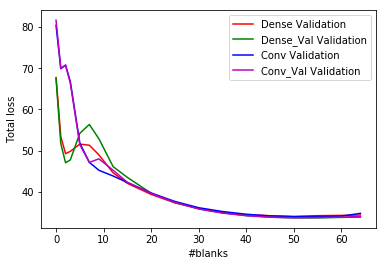

In [30]:
# plot loss
plt.plot(dense_val_evals[:, 0], dense_val_evals[:, 1], 'r-', label='Dense Validation')
# plt.plot(dense_train_evals[:, 0], dense_train_evals[:, 1], 'r--', label='Dense Train')
plt.plot(dense_val_val_evals[:, 0], dense_val_val_evals[:, 1], 'g-', label='Dense_Val Validation')
# plt.plot(dense_val_train_evals[:, 0], dense_val_train_evals[:, 1], 'g--', label='Dense_Val Train')
plt.plot(conv_val_evals[:, 0], conv_val_evals[:, 1], 'b-', label='Conv Validation')
# plt.plot(conv_train_evals[:, 0], conv_train_evals[:, 1], 'b--', label='Conv Train')
plt.plot(conv_val_val_evals[:, 0], conv_val_val_evals[:, 1], 'm-', label='Conv_Val Validation')
# plt.plot(conv_val_train_evals[:, 0], conv_val_train_evals[:, 1], 'm--', label='Conv_Val Train')
plt.xlabel('#blanks')
plt.ylabel('Total loss')
plt.legend(loc='best')
plt.show()

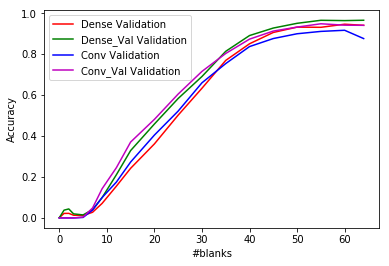

In [29]:
# plot accuracy
plt.plot(dense_val_evals[:, 0], dense_val_evals[:, 2], 'r-', label='Dense Validation')
# plt.plot(dense_train_evals[:, 0], dense_train_evals[:, 2], 'r--', label='Dense Train')
plt.plot(dense_val_val_evals[:, 0], dense_val_val_evals[:, 2], 'g-', label='Dense_Val Validation')
# plt.plot(dense_val_train_evals[:, 0], dense_val_train_evals[:, 2], 'g--', label='Dense_Val Train')
plt.plot(conv_val_evals[:, 0], conv_val_evals[:, 2], 'b-', label='Conv Validation')
# plt.plot(conv_train_evals[:, 0], conv_train_evals[:, 2], 'b--', label='Conv Train')
plt.plot(conv_val_val_evals[:, 0], conv_val_val_evals[:, 2], 'm-', label='Conv_Val Validation')
# plt.plot(conv_val_train_evals[:, 0], conv_val_train_evals[:, 2], 'm--', label='Conv_Val Train')

plt.xlabel('#blanks')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

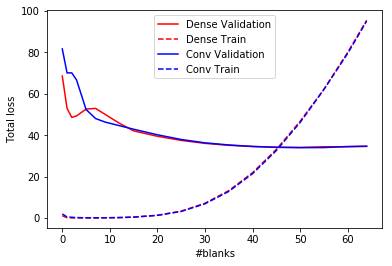

In [28]:
# plot loss
plt.plot(dense_losses[:, 2], dense_losses[:, 5], 'r-', label='Dense Validation')
plt.plot(dense_losses[:, 2], dense_losses[:, 4], 'r--', label='Dense Train')
# plt.plot(dense_val_losses[:, 2], dense_val_losses[:, 5], 'g-', label='Dense_Val Validation')
# plt.plot(dense_val_losses[:, 2], dense_val_losses[:, 4], 'g--', label='Dense_Val Train')
plt.plot(conv_losses[:, 2], conv_losses[:, 5], 'b-', label='Conv Validation')
plt.plot(conv_losses[:, 2], conv_losses[:, 4], 'b--', label='Conv Train')
# plt.plot(conv_val_losses[:, 2], conv_val_losses[:, 5], 'm-', label='Conv_Val Validation')
# plt.plot(conv_val_losses[:, 2], conv_val_losses[:, 4], 'm--', label='Conv_Val Train')
plt.xlabel('#blanks')
plt.ylabel('Total loss')
plt.legend(loc='best')
plt.show()

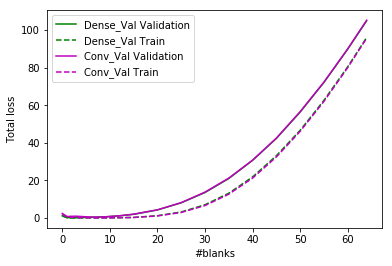

In [27]:
# plot loss
# plt.plot(dense_losses[:, 2], dense_losses[:, 5], 'r-', label='Dense Validation')
# plt.plot(dense_losses[:, 2], dense_losses[:, 4], 'r--', label='Dense Train')
plt.plot(dense_val_losses[:, 2], dense_val_losses[:, 5], 'g-', label='Dense_Val Validation')
plt.plot(dense_val_losses[:, 2], dense_val_losses[:, 4], 'g--', label='Dense_Val Train')
# plt.plot(conv_losses[:, 2], conv_losses[:, 5], 'b-', label='Conv Validation')
# plt.plot(conv_losses[:, 2], conv_losses[:, 4], 'b--', label='Conv Train')
plt.plot(conv_val_losses[:, 2], conv_val_losses[:, 5], 'm-', label='Conv_Val Validation')
plt.plot(conv_val_losses[:, 2], conv_val_losses[:, 4], 'm--', label='Conv_Val Train')
plt.xlabel('#blanks')
plt.ylabel('Total loss')
plt.legend(loc='best')
plt.show()

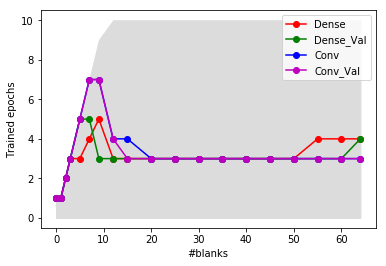

In [26]:
# Number of epochs trained before early stop
trained_epochs = [[0, 1, 2, 3, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64], # #blanks
                  [1, 1, 2, 3, 5, 7, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], # maximum epochs
                  [1, 1, 2, 3, 3, 4, 5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4], # dense
                  [1, 1, 2, 3, 5, 5, 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4], # dense_val
                  [1, 1, 2, 3, 5, 7, 7,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3], # conv
                  [1, 1, 2, 3, 5, 7, 7,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]] # conv_val

# plot the graph
plt.fill_between(trained_epochs[0], trained_epochs[1], [0] * len(trained_epochs[0]), color='gainsboro')
plt.plot(trained_epochs[0], trained_epochs[2], 'ro-', label='Dense')
plt.plot(trained_epochs[0], trained_epochs[3], 'go-', label='Dense_Val')
plt.plot(trained_epochs[0], trained_epochs[4], 'bo-', label='Conv')
plt.plot(trained_epochs[0], trained_epochs[5], 'mo-', label='Conv_Val')
plt.xlabel('#blanks')
plt.ylabel('Trained epochs')
plt.legend()
plt.show()

### Evaluate on test set

In [3]:
# load latest model
dense = keras.models.load_model('./models/dense_model-64.h5')
conv = keras.models.load_model('./models/conv_model-64.h5')
dense_val = keras.models.load_model('./models/dense_val-64.h5')
conv_val = keras.models.load_model('./models/conv_val-64.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
# Evaluate on test set
start = time.time()
test_performance = evaluate_model(dense, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense model performance:")
print("\tNumber of test puzzles:", X_kaggle_test.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 119.75972890853882 seconds
Dense model performance:
	Number of test puzzles: 10000
	Number of correctly predicted puzzles: 9431
	Accuracy: 0.9431


In [20]:
# Evaluate on test set
start = time.time()
test_performance = evaluate_model(dense_val, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense with random-delete validation model performance:")
print("\tNumber of test puzzles:", X_kaggle_test.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 161.9462718963623 seconds
Dense with random-delete validation model performance:
	Number of test puzzles: 10000
	Number of correctly predicted puzzles: 9637
	Accuracy: 0.9637


In [11]:
# Evaluate on test set
start = time.time()
test_performance = evaluate_model(conv, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Convolutional model performance:")
print("\tNumber of test puzzles:", X_kaggle_test.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 174.26100373268127 seconds
Convolutional model performance:
	Number of test puzzles: 10000
	Number of correctly predicted puzzles: 8776
	Accuracy: 0.8776


In [21]:
# Evaluate on test set
start = time.time()
test_performance = evaluate_model(conv_val, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Convolutional with random-delete validation model performance:")
print("\tNumber of test puzzles:", X_kaggle_test.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 212.94306421279907 seconds
Convolutional with random-delete validation model performance:
	Number of test puzzles: 10000
	Number of correctly predicted puzzles: 9443
	Accuracy: 0.9443


In [12]:
# Evaluate best model on hold-out 950,000 puzzles
start = time.time()
test_performance = evaluate_model(dense_val, X_kaggle_hold)
print("Runtime: {} seconds".format(time.time() - start))
print("Best model on 950,000 hold-out puzzles:")
print("\tNumber of test puzzles:", X_kaggle_hold.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("\tAccuracy:", test_performance['accuracy'])

Runtime: 10586.668819189072 seconds
Best model on 950,000 hold-out puzzles:
	Number of test puzzles: 950000
	Number of correctly predicted puzzles: 917093
	Accuracy: 0.9653610526315789


### Additional evaluation

##### 17-givens.txt dataset with only 17 clues each puzzle

In [6]:
# load 17-givens dataset
given17 = pd.read_csv('./datasets/17-givens.csv').values
print("Full shape:", given17.shape)

Full shape: (49151, 1)


In [7]:
given17

array([['000000010400000000020000000000050407008000300001090000300400200050100000000806000'],
       ['000000010400000000020000000000050604008000300001090000300400200050100000000807000'],
       ['000000012000035000000600070700000300000400800100000000000120000080000040050000600'],
       ...,
       ['140805000006000070000000300000200010300070000500000000800000002010400000000000500'],
       ['080020000030000600000001000000630080100000500200000000000500401002300000700000000'],
       ['060000300400700000000000080000008012500600000000000050082000700000500600000010000']],
      dtype=object)

In [8]:
# reshape
given17 = preprocess(given17[:, 0], 
                     from_string=True,
                     reshape=True,
                     one_hot=False)[0]

Initial shape of X: (49151,)
Convert strings in X to: (49151, 81)
Reshape X to: (49151, 9, 9)


In [6]:
given17[0]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0],
       [4, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 4, 0, 7],
       [0, 0, 8, 0, 0, 0, 3, 0, 0],
       [0, 0, 1, 0, 9, 0, 0, 0, 0],
       [3, 0, 0, 4, 0, 0, 2, 0, 0],
       [0, 5, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 8, 0, 6, 0, 0, 0]])

In [8]:
# Count clues
clues = np.sum(given17 != 0, axis=(1, 2))
print("Maximum #clues:", np.max(clues))
print("Minimum #clues:", np.min(clues))
print("Average #clues:", np.mean(clues))

Maximum #clues: 17
Minimum #clues: 17
Average #clues: 17.0


In [9]:
#   DEGREE OF DIFFICULTY   |  SCORE                                                
# -------------------------+------------------------------------------             
#   TRIVIAL                |  80 points or less                                    
#   EASY                   |  81 - 150 points                                      
#   MEDIUM                 |  151 - 250 points                                     
#   HARD                   |  251 - 400 points                                     
#   VERY HARD              |  401 - 900 points                                     
#   DIABOLICAL             |  901 and up                                           

evals = calculate_difficulty(given17)

In [10]:
# Number of solutions
counts = list(map(lambda x: int(x['counts'][0]), evals))
print("Maximum #solutions:", np.max(counts))
print("Minimum #solutions:", np.min(counts))
print("Average #solutions:", np.mean(counts))

Maximum #solutions: 1
Minimum #solutions: 1
Average #solutions: 1.0


In [11]:
# scores
scores = list(map(lambda x: int(x['scores'][0]), evals))
print("Maximum score:", np.max(scores))
print("Minimum score:", np.min(scores))
print("Average score:", np.mean(scores))
print("Std score:", np.std(scores))

Maximum score: 881806
Minimum score: 144
Average score: 1178.8239710280563
Std score: 10386.983919226592


In [9]:
# one_hot
given17 = preprocess(given17,
                     from_string=False,
                     reshape=False,
                     one_hot=True)[0]

Initial shape of X: (49151, 9, 9)
Shape of one-hot X: (49151, 9, 9, 10)


In [37]:
# run evaluate
start = time.time()
given17_performance = evaluate_model(dense, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense performance on 17-given puzzles:")
print("\tNumber of test puzzles:", given17.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("\tAccuracy:", given17_performance['accuracy'])

Runtime: 748.8157165050507 seconds
Dense performance on 17-given puzzles:
	Number of test puzzles: 49151
	Number of correctly predicted puzzles: 22
	Accuracy: 0.00044760025228377854


In [10]:
# run evaluate
start = time.time()
given17_performance = evaluate_model(dense_val, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense with random-delete validation performance on 17-given puzzles:")
print("\tNumber of test puzzles:", given17.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("\tAccuracy:", given17_performance['accuracy'])

Runtime: 972.6062707901001 seconds
Dense with random-delete validation performance on 17-given puzzles:
	Number of test puzzles: 49151
	Number of correctly predicted puzzles: 18
	Accuracy: 0.0003662183882321825


In [38]:
# run evaluate
start = time.time()
given17_performance = evaluate_model(conv, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Conv performance on 17-given puzzles:")
print("\tNumber of test puzzles:", given17.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("\tAccuracy:", given17_performance['accuracy'])

Runtime: 1037.2923321723938 seconds
Conv performance on 17-given puzzles:
	Number of test puzzles: 49151
	Number of correctly predicted puzzles: 23
	Accuracy: 0.0004679457182966776


In [11]:
# run evaluate
start = time.time()
given17_performance = evaluate_model(conv_val, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Convolutional random-delete validation performance on 17-given puzzles:")
print("\tNumber of test puzzles:", given17.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("\tAccuracy:", given17_performance['accuracy'])

Runtime: 1267.0977718830109 seconds
Convolutional random-delete validation performance on 17-given puzzles:
	Number of test puzzles: 49151
	Number of correctly predicted puzzles: 26
	Accuracy: 0.0005289821163353747


##### UNL Sudoku dataset

In [4]:
# load UNL sudoku dataset
with open('./datasets/sudokus-unl.json') as read_file:
    sudokus_unl = np.array(json.load(read_file))
    
sudokus_unl.shape

(472, 13)

In [5]:
sudokus_unl[0]

array(['99', 'Base', 'Omaha World-Herald', '1', '2', '5',
       'March 24, 2009', '', 'Puzzle added by Jason Gaare',
       '100000026200709010030060000000800700710526038003007000000010050050603007960000004',
       '1', 'GAC', '29'], dtype='<U81')

In [6]:
# reshape
sudoku_unl_puzzles = preprocess(sudokus_unl[:, 9],
                                from_string=True,
                                reshape=True,
                                one_hot=False)[0]

Initial shape of X: (472,)
Convert strings in X to: (472, 81)
Reshape X to: (472, 9, 9)


In [7]:
sudoku_unl_puzzles[0]

array([[1, 0, 0, 0, 0, 0, 0, 2, 6],
       [2, 0, 0, 7, 0, 9, 0, 1, 0],
       [0, 3, 0, 0, 6, 0, 0, 0, 0],
       [0, 0, 0, 8, 0, 0, 7, 0, 0],
       [7, 1, 0, 5, 2, 6, 0, 3, 8],
       [0, 0, 3, 0, 0, 7, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 5, 0],
       [0, 5, 0, 6, 0, 3, 0, 0, 7],
       [9, 6, 0, 0, 0, 0, 0, 0, 4]])

Maximum #clues: 50
Minimum #clues: 17
Average #clues: 23.055084745762713


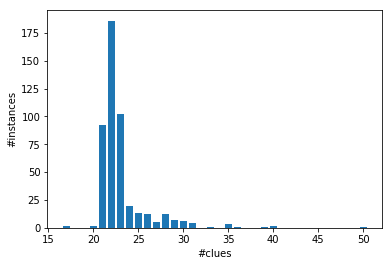

In [7]:
# Count clues
clues = np.sum(sudoku_unl_puzzles != 0, axis=(1, 2))
print("Maximum #clues:", np.max(clues))
print("Minimum #clues:", np.min(clues))
print("Average #clues:", np.mean(clues))

# plot bar
counter = Counter(clues)
plt.bar(counter.keys(), counter.values())
plt.xlabel('#clues')
plt.ylabel('#instances')
plt.show()

In [8]:
# estimate difficulty
evals = calculate_difficulty(sudoku_unl_puzzles)

In [9]:
# Number of solutions
counts = list(map(lambda x: int(x['counts'][0]), evals))
print("Maximum #solutions:", np.max(counts))
print("Minimum #solutions:", np.min(counts))
print("Average #solutions:", np.mean(counts))

Maximum #solutions: 11
Minimum #solutions: 1
Average #solutions: 1.0254237288135593


In [10]:
# scores
scores = list(map(lambda x: int(x['scores'][0]), evals))
print("Maximum score:", np.max(scores))
print("Minimum score:", np.min(scores))
print("Average score:", np.mean(scores))
print("Std score:", np.std(scores))

Maximum score: 2797500
Minimum score: 41
Average score: 390014.48728813557
Std score: 422457.60651448683


In [8]:
# one_hot
sudoku_unl_puzzles = preprocess(sudoku_unl_puzzles,
                                from_string=False,
                                reshape=False,
                                one_hot=True)[0]

Initial shape of X: (472, 9, 9)
Shape of one-hot X: (472, 9, 9, 10)


In [9]:
# run evaluate
start = time.time()
dense_sudoku_unl_performance = evaluate_model(dense, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense performance on UNL puzzles:")
print("\tNumber of test puzzles:", sudoku_unl_puzzles.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(dense_sudoku_unl_performance['validations']))
print("\tAccuracy:", dense_sudoku_unl_performance['accuracy'])

Runtime: 13.251564741134644 seconds
Dense performance on UNL puzzles:
	Number of test puzzles: 472
	Number of correctly predicted puzzles: 16
	Accuracy: 0.03389830508474576


In [11]:
# run evaluate
start = time.time()
dense_val_unl_performance = evaluate_model(dense_val, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Dense with random-delete validation performance on UNL puzzles:")
print("\tNumber of test puzzles:", sudoku_unl_puzzles.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(dense_val_unl_performance['validations']))
print("\tAccuracy:", dense_val_unl_performance['accuracy'])

Runtime: 13.31641697883606 seconds
Dense with random-delete validation performance on UNL puzzles:
	Number of test puzzles: 472
	Number of correctly predicted puzzles: 22
	Accuracy: 0.046610169491525424


In [10]:
# run evaluate
start = time.time()
conv_sudoku_unl_performance = evaluate_model(conv, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Conv performance on UNL puzzles:")
print("\tNumber of test puzzles:", sudoku_unl_puzzles.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(conv_sudoku_unl_performance['validations']))
print("\tAccuracy:", conv_sudoku_unl_performance['accuracy'])

Runtime: 16.32040309906006 seconds
Conv performance on UNL puzzles:
	Number of test puzzles: 472
	Number of correctly predicted puzzles: 14
	Accuracy: 0.029661016949152543


In [12]:
# run evaluate
start = time.time()
conv_val_unl_performance = evaluate_model(conv_val, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Conv with random-delete validation performance on UNL puzzles:")
print("\tNumber of test puzzles:", sudoku_unl_puzzles.shape[0])
print("\tNumber of correctly predicted puzzles:", np.sum(conv_val_unl_performance['validations']))
print("\tAccuracy:", conv_val_unl_performance['accuracy'])

Runtime: 15.769872665405273 seconds
Conv with random-delete validation performance on UNL puzzles:
	Number of test puzzles: 472
	Number of correctly predicted puzzles: 15
	Accuracy: 0.03177966101694915


In [13]:
# append to original array
sudoku_unl_combined = np.concatenate((sudokus_unl, 
                                      np.expand_dims(dense_sudoku_unl_performance['validations'], 
                                                     axis=1),
                                      np.expand_dims(dense_val_unl_performance['validations'], 
                                                     axis=1),
                                      np.expand_dims(conv_sudoku_unl_performance['validations'], 
                                                     axis=1),
                                      np.expand_dims(conv_val_unl_performance['validations'], 
                                                     axis=1)), 
                                     axis=1)
sudoku_unl_combined

array([['99', 'Base', 'Omaha World-Herald', ..., 'False', 'False',
        'True'],
       ['98', 'Base', 'Daily Nebraskan', ..., 'True', 'False', 'True'],
       ['100', 'Base', 'LA Times', ..., 'False', 'False', 'False'],
       ...,
       ['637', 'Base', 'Lincoln Journal Star', ..., 'False', 'False',
        'False'],
       ['638', 'Base', 'Evan', ..., 'False', 'False', 'False'],
       ['639', 'Base', 'RWallace', ..., 'False', 'False', 'False']],
      dtype='<U81')

In [36]:
algo_order = {'AC': 0, 'GAC': 1, 'SAC': 2, 'SAC + GAC': 3, 'SGAC': 4,
              'BiSGAC': 5, 'SSAC': 6, 'BiSGAC + SSAC': 7, 'SSGAC': 8,
              'Unsolved': 9}

Dense solvable puzzles: 16


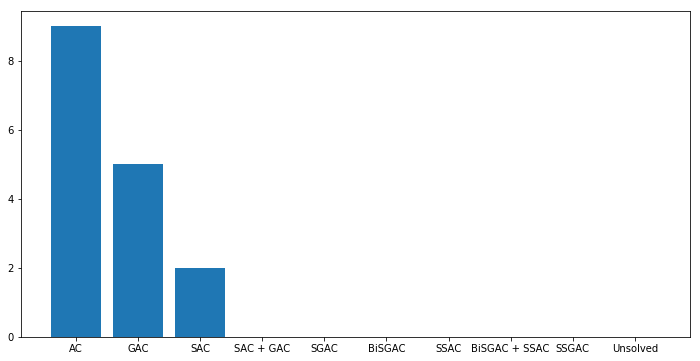

In [37]:
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -4] == 'True']

print("Dense solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Dense with random-delete validation solvable puzzles: 22


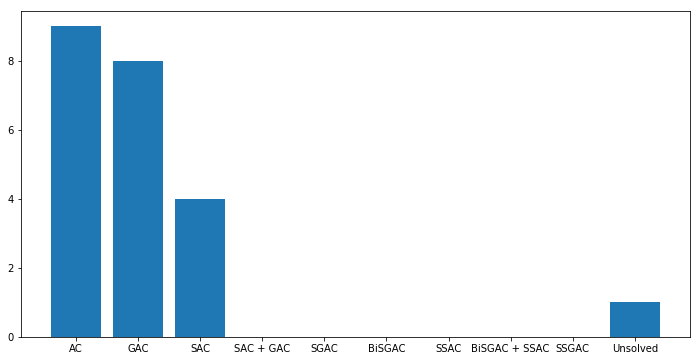

In [38]:
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -3] == 'True']

print("Dense with random-delete validation solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Dense models common solvable puzzles: 10


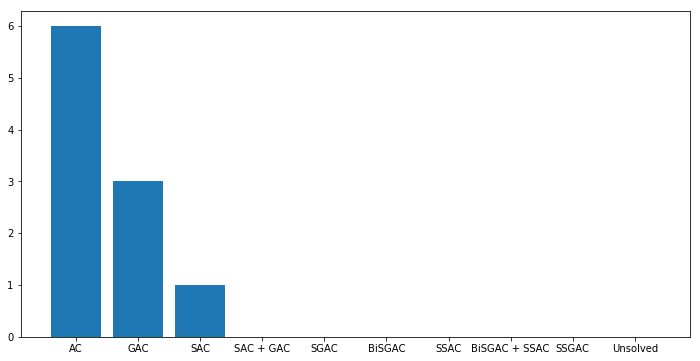

In [39]:
# get solvable instances
solvables = sudoku_unl_combined[np.logical_and(sudoku_unl_combined[:, -4] == 'True', 
                                               sudoku_unl_combined[:, -3] == 'True')]

# Puzzles that are solved in common of dense models
print("Dense models common solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Dense models total solvable puzzles: 28


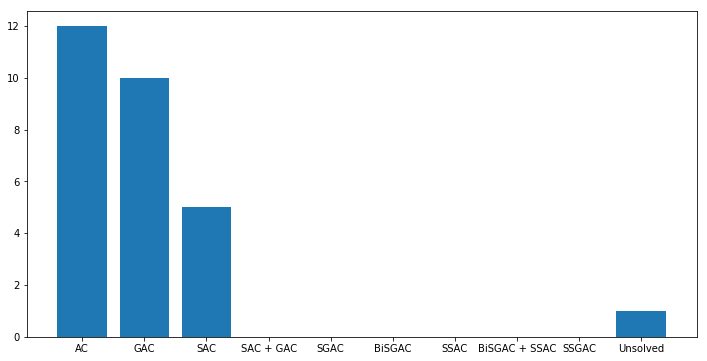

In [40]:
# get solvable instances
solvables = sudoku_unl_combined[np.logical_or(sudoku_unl_combined[:, -4] == 'True', 
                                              sudoku_unl_combined[:, -3] == 'True')]

# Puzzles that are solved in total of dense models
print("Dense models total solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Conv solvable puzzles: 14


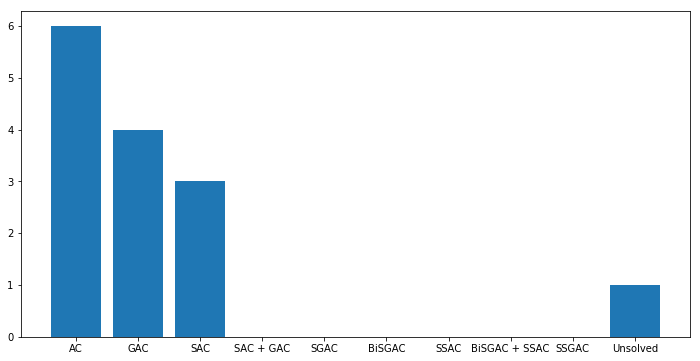

In [41]:
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -2] == 'True']

print("Conv solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Conv with random-delete validation solvable puzzles: 15


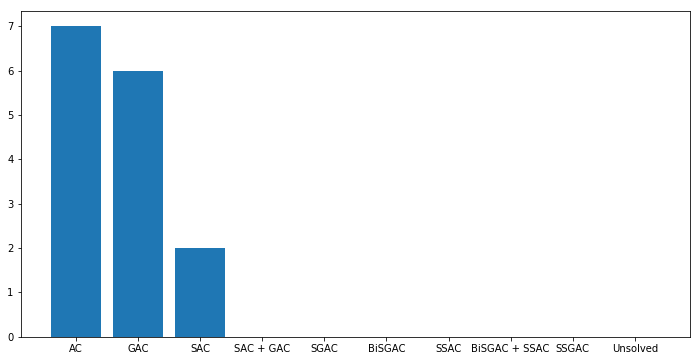

In [42]:
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -1] == 'True']

print("Conv with random-delete validation solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Conv models common solvable puzzles: 5


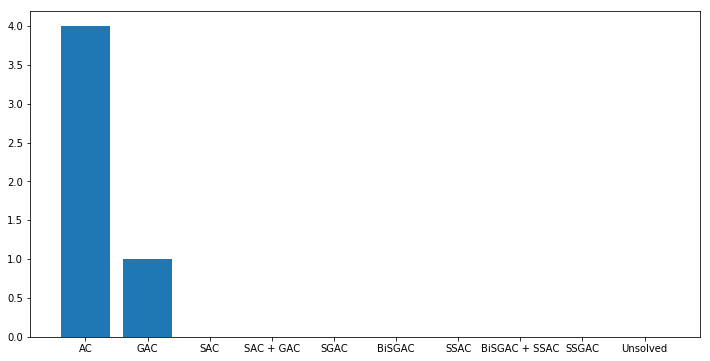

In [43]:
# get solvable instances
solvables = sudoku_unl_combined[np.logical_and(sudoku_unl_combined[:, -2] == 'True', 
                                               sudoku_unl_combined[:, -1] == 'True')]

# Puzzles that are solved in common of conv models
print("Conv models common solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Conv models total solvable puzzles: 24


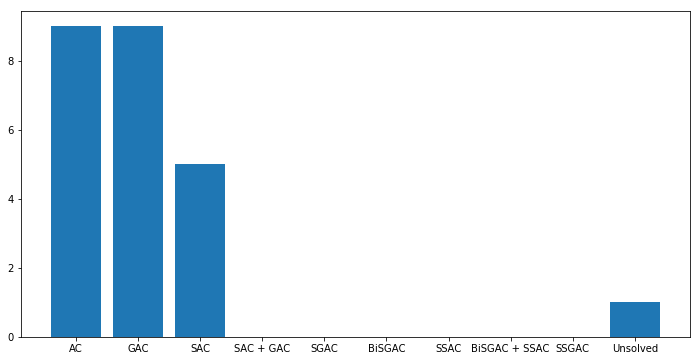

In [44]:
# get solvable instances
solvables = sudoku_unl_combined[np.logical_or(sudoku_unl_combined[:, -2] == 'True', 
                                              sudoku_unl_combined[:, -1] == 'True')]

# Puzzles that are solved in total of conv models
print("Conv models total solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Common solvable puzzles: 4


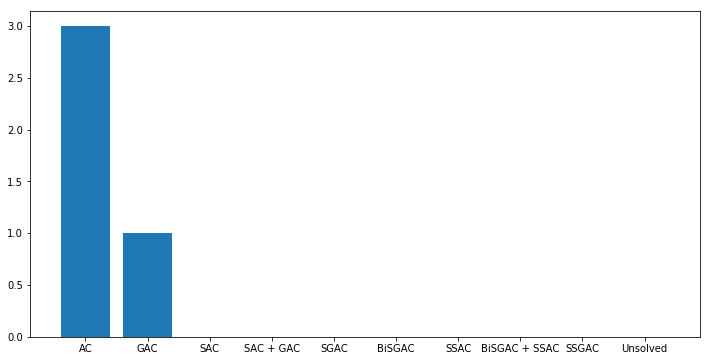

In [45]:
# get solvable instances
solvables = sudoku_unl_combined[np.logical_and(np.logical_and(sudoku_unl_combined[:, -2] == 'True', 
                                                              sudoku_unl_combined[:, -1] == 'True'),
                                               np.logical_and(sudoku_unl_combined[:, -4] == 'True', 
                                                              sudoku_unl_combined[:, -3] == 'True'))]

# Puzzles that are solved in common
print("Common solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()

Total solvable puzzles: 32


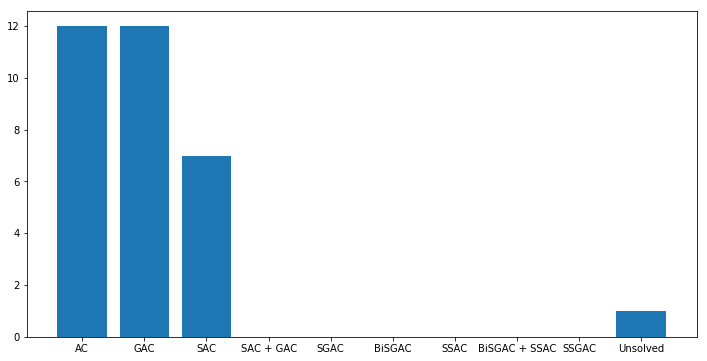

In [46]:
# get solvable instances
solvables = sudoku_unl_combined[np.logical_or(np.logical_or(sudoku_unl_combined[:, -2] == 'True', 
                                                            sudoku_unl_combined[:, -1] == 'True'),
                                               np.logical_or(sudoku_unl_combined[:, -4] == 'True', 
                                                             sudoku_unl_combined[:, -3] == 'True'))]

# Puzzles that are solved in total
print("Total solvable puzzles:", len(solvables))

# Examine algorithms
solvable_algos = solvables[:, 11]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()